<a href="https://colab.research.google.com/github/theresaxx/DataScience2021/blob/main/Final_Report_Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introduction

Since the original Notebook was created in Google Colab, we also want to provide a link (https://colab.research.google.com/drive/1fbhrLIIrULWuFdQ00lq630K2uQHaUJVj?usp=sharing#scrollTo=REGnaxAm_WPA) for that in regards to best experience. Please contact us if the link should not work. 

This project notebook will cover the problem of predicting if a defendant is a recidivist and their COMPAS-scores. The assessment of whether a defendant will become a recidivist is conducted with COMPAS (Correctional Offender Management Profiling for Alternative Sanctions), which is a case management and decision support tool used in courts in the United States. 

On the basis of this [ProPublica article](https:////www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm), our project is grounded on the fact that we want to analyze the COMPAS algorithm. The key problem we want to focus on now is to predict the recidivism and the COMPAS scores of the defendants. 

By that, our goals are set as the following:
- What are the best performing models in regards to predicting COMPAS scores and the recidivism of the defendants?
- Are our models possibly biased towards certain races / How fair are our models?
- How accurately are we going to predict the COMPAS scores and the recidivism of the defendants?
- What are possible model limitations? What are the most important factors or features that lead to a defendant’s COMPAS score and reoffend prediction?

These are the questions that guide us through the following analysis. 

In the first section, we want to preprocess the data according to the features we are going to use in our analysis and explore the data provided. In the second section, we are going to perform and explain our models we have chosen to predict recidivism for the defendants using classification models. In the next part, we are going to describe the model performances and explanations of our models we have chosen to predict the COMPAS scores of the defendants using regression models. Finally, the conclusion will provide a summary of our key findings and further steps that can be conducted to proceed with our results. The appendix will include observations and derivations of race features omission.

# 2 General Data Preprocessing

## 2.1 Feature Selection

In [ ]:
# needed for data interpretation
!pip install shap

     |████████████████████████████████| 564 kB 16.3 MB/s 


In [ ]:
#Import basic libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Import common sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import partial_dependence, plot_partial_dependence, PartialDependenceDisplay

# Import common Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix, log_loss, auc, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# import common regression libraries
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_squared_log_error, median_absolute_error, mean_absolute_percentage_error, mean_absolute_error

In [ ]:
# Links to Propublica and Extra Data
url_charges = 'https://raw.githubusercontent.com/chrrtonch/compas_extra_data/main/extra_info_charges.csv'
url_prison = 'https://raw.githubusercontent.com/chrrtonch/compas_extra_data/main/extra_info_prison.csv'
url_two_years = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
url_violent = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv'

url_fictional = 'https://raw.githubusercontent.com/chrrtonch/compas_extra_data/main/fictional_characters.csv'

# read CSVs
charges = pd.read_csv(url_charges, header=0)
prison = pd.read_csv(url_prison, header=0)
two_years = pd.read_csv(url_two_years, header=0)
two_years_v = pd.read_csv(url_violent, header=0)

fictional_characters = pd.read_csv(url_fictional, header=0)

# drop duplicate columns between violent and not violent data
id = two_years_v['id']
two_years_v = two_years_v.drop(columns=two_years.columns)
two_years_v['id'] = id

In [ ]:
fictional_characters

juv_fel_count  decile_score  ...  c_charge_degree_F  c_charge_degree_M
0              0             0  ...                  1                  0
1              1             0  ...                  1                  0

[2 rows x 30 columns]

In [ ]:
# join data 
df = pd.merge(left=two_years,right=two_years_v,how='left',on='id')
df = pd.merge(left=df,right=charges,how='left',left_on='c_case_number',right_on='case_number')
df = pd.merge(left=df,right=prison,how='left',left_on='c_case_number',right_on='case_number')
df = df.drop(columns=["two_year_recid.1"]).drop_duplicates()

In [ ]:
# change dates to datetime
date_variables = ["c_jail_in", "c_jail_out", "in_custody", "out_custody"]
df[date_variables] = df[date_variables].apply(pd.to_datetime)

# Create new features
df["dob"] = pd.DatetimeIndex(df["dob"]).year  
df["compas_screening_date"] = pd.DatetimeIndex(df["compas_screening_date"]).year
df["jail_stay"] = (df["c_jail_out"] - df["c_jail_in"]).dt.days
df["age_at_cscreening"] = df["compas_screening_date"] - df["dob"]
df["juv_total_count"] = df["juv_fel_count"] + df["juv_misd_count"] + df["juv_other_count"]
df['age_first_offense'] = df['age_first_offense'].fillna(df["age_at_cscreening"])

# was dropped since it is directly connected to the Compas Score
#df["custody_duration"] = (df["out_custody"] - df["in_custody"]).dt.days

In [ ]:
# clear like Propublica
df = df.loc[df['days_b_screening_arrest']<=30].loc[df['days_b_screening_arrest']>=-30].loc[df['is_recid']!=-1].loc[df['c_charge_degree']!= "O"].loc[df['score_text']!= "N/A"]

In [ ]:
df.sort_values('case_m',ascending=False).head()

id             name  ... age_at_cscreening juv_total_count
4238  6471  jonathan kenney  ...                46               0
1048  1608    ellen brezner  ...                48               0
4211  6428  cynthia lanford  ...                42               0
328    487     timothy ryan  ...                51               0
5031  7661    tammy trotter  ...                46               0

[5 rows x 68 columns]

In [ ]:
# get_dummies
df_lin = pd.get_dummies(df, columns = ["race", "sex","c_charge_degree"], drop_first=True) #drop_first=True --> Depends on model
df_tree = pd.get_dummies(df, columns = ["race", "sex","c_charge_degree"])
# get age category
size_mapping2 = {"Less than 25": 1, "25 - 45": 2, "Greater than 45": 3}
df_lin["age_cat"] = df_lin["age_cat"].map(size_mapping2)
df_tree["age_cat"] = df_tree["age_cat"].map(size_mapping2)

In [ ]:
# choose possible features and drop rest
possible_features_lin = ['id','juv_fel_count','decile_score','juv_misd_count','juv_other_count','two_year_recid','case_total','case_m','case_f','case_gambling','case_hard','case_drugs','time_in_prison','count_prison_stays','age_first_offense','count_arrests', 'age_at_cscreening','juv_total_count','race_Asian','race_Caucasian','race_Hispanic','race_Native American','race_Other','sex_Male','c_charge_degree_M']
possible_features_tree = ['id','juv_fel_count','decile_score','juv_misd_count','juv_other_count','two_year_recid','case_total','case_m','case_f','case_gambling','case_hard','case_drugs','time_in_prison','count_prison_stays','age_first_offense','count_arrests','age_at_cscreening','juv_total_count','race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native American','race_Other','sex_Female','sex_Male','c_charge_degree_F','c_charge_degree_M']

df_lin = df_lin[possible_features_lin]
df_tree = df_tree[possible_features_tree]

In [ ]:
# Can be used instead of a Imputer since NA = 0 
df_lin = df_lin.fillna(0) 
df_tree = df_tree.fillna(0) 

## 2.2 Feature Overview


sources:
SQL: https://github.com/chrrtonch/compas_extra_data                              
Propublica: https://github.com/propublica/compas-analysis
Violent and non Violent

| Target name | Description |
| --- | --- |
| two_year_recid | defendent reoffended within 2 year after screening | 
| decile_score | compas recidivism score |

| Feature name | Description |
| --- | --- |
| age_at_cscreening | age at compas-screening |
| age_cat | age category  1: less than 25, 2: 25-45, 3: greater than 45 |
| age_first_offense | age at first charge |
| c_charge_degree | categorical variable, misdemeanor or felony |
| case_drug | prior drug related charges |
| case_f | prior felony charges |
| case_m | prior misdemeanor charges|
| case_gambling | prior gambling related charges |
| case_hard | prior "hard" charges, definition in SQL |
| case_total | prior total charges |
| count_arrests | prior total arrests |
| count_prison_stays | count prior prison stays |
| jail_stay | time spent in jail for screening |
| juv_fel_count | count felonies while being a minor |
| juv_misd_count | count misdemeanors while being a minor |
| juv_other_count | count other charges while being a minor |
| juv_total_count | count total charges while being a minor |
| race | race |
| sex | male or female |
| time_in_prison | count days spent in prison prior to screening |

The variable "id" was left in the dataframe to rejoin original data for analysis


# 3 General EDA

In [ ]:
%matplotlib inline

In [ ]:
df_lin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6172 entries, 0 to 7213
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    6172 non-null   int64  
 1   juv_fel_count         6172 non-null   int64  
 2   decile_score          6172 non-null   int64  
 3   juv_misd_count        6172 non-null   int64  
 4   juv_other_count       6172 non-null   int64  
 5   two_year_recid        6172 non-null   int64  
 6   case_total            6172 non-null   float64
 7   case_m                6172 non-null   float64
 8   case_f                6172 non-null   float64
 9   case_gambling         6172 non-null   float64
 10  case_hard             6172 non-null   float64
 11  case_drugs            6172 non-null   float64
 12  time_in_prison        6172 non-null   float64
 13  count_prison_stays    6172 non-null   float64
 14  age_first_offense     6172 non-null   float64
 15  count_arrests        

In [ ]:
#Checking for distribution of labels in the dataset --> Is the target variable balanced? Do we need to stratify our train/test split? 
df["two_year_recid"].value_counts()

0    3363
1    2809
Name: two_year_recid, dtype: int64

Below is the distribution of the decile scores among the defendants

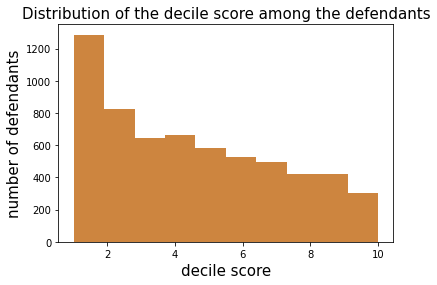

In [ ]:
plt.hist(df["decile_score"], color="peru")
plt.title("Distribution of the decile score among the defendants", fontsize = 15)
plt.xlabel("decile score", fontsize = 15)
plt.ylabel("number of defendants", fontsize = 15)
plt.show()

Distribution of defendants who were recidivists within the two years documented

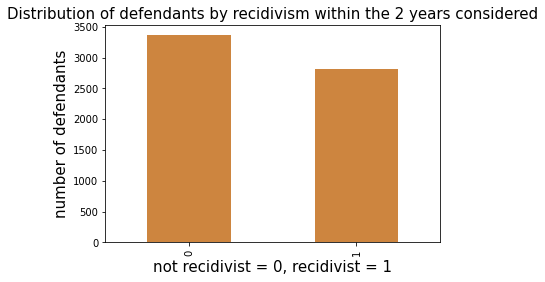

In [ ]:
df["two_year_recid"].value_counts().plot(kind="bar", color="peru")
plt.title("Distribution of defendants by recidivism within the 2 years considered", fontsize = 15)
plt.xlabel("not recidivist = 0, recidivist = 1", fontsize = 15)
plt.ylabel("number of defendants", fontsize = 15)
plt.show()

Distribution of the defendants among the decile score, visualizing which of them recidivated within the two years.

As we can see in the figure below, the defendants being recid are not really dependent on the decile scores, it is almost constant along the decile scores, whilst the predicion for not recid is negative correlated to the decile score. 

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


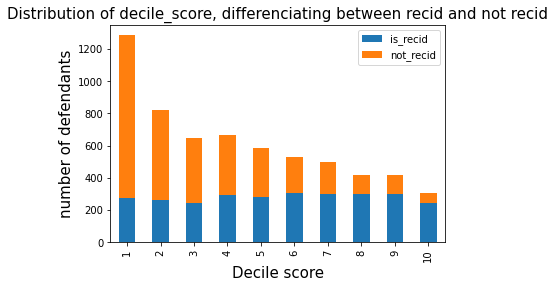

In [ ]:
df["is_recid"] = df["two_year_recid"]==1
df["not_recid"] = df["two_year_recid"]==0
df.groupby("decile_score")["is_recid", "not_recid"].sum().plot(kind='bar', stacked = True)
plt.title("Distribution of decile_score, differenciating between recid and not recid", fontsize = 15)
plt.xlabel("Decile score", fontsize = 15)
plt.ylabel("number of defendants", fontsize = 15)
plt.show()

Distribution of the defendants among their race and being recidivists within the two years documented

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


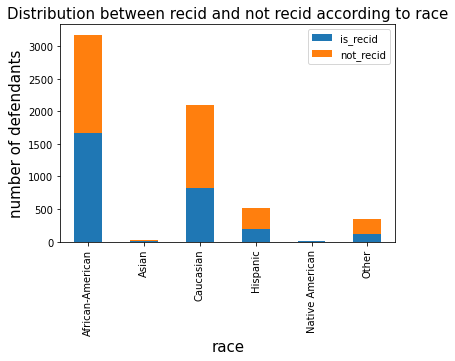

In [ ]:
df["is_recid"] = df["two_year_recid"]==1
df["not_recid"] = df["two_year_recid"]==0
df.groupby("race")["is_recid", "not_recid"].sum().plot(kind='bar', stacked = True)
plt.title("Distribution between recid and not recid according to race", fontsize = 15)
plt.xlabel("race", fontsize = 15)
plt.ylabel("number of defendants", fontsize = 15)
plt.show()

Distribution of the defendants among their race and the received decile score

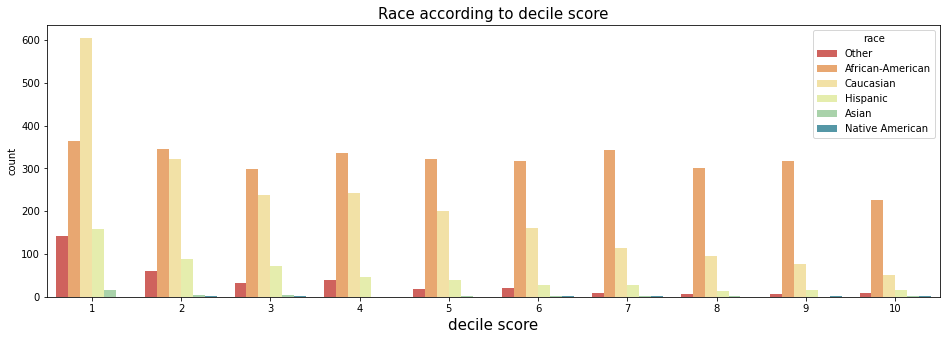

In [ ]:
plt.figure(figsize=(16,5))
sns.countplot(x="decile_score",hue="race", data=df, palette="Spectral")
plt.title("Race according to decile score", fontsize = 15)
plt.xlabel("decile score", fontsize = 15)
plt.show()

Distribution of the defendants among their charge degree and the received decile score

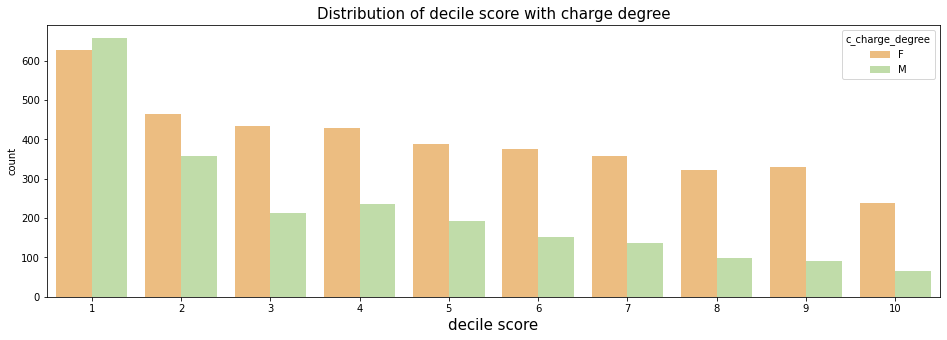

In [ ]:
plt.figure(figsize=(16,5))
sns.countplot(x="decile_score",hue="c_charge_degree", data=df, palette="Spectral")
plt.title("Distribution of decile score with charge degree", fontsize = 15)
plt.xlabel("decile score", fontsize = 15)
plt.show()

### 3.1 Distribution Plots
This function plots the distribution for the variables defined. The distribution plot visualizes, how the variables are distributed - if the data is Normally Distributed or if the data is unequally distributed. Most varaibles are exponential distributed, only the age category is normally distributed.

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open

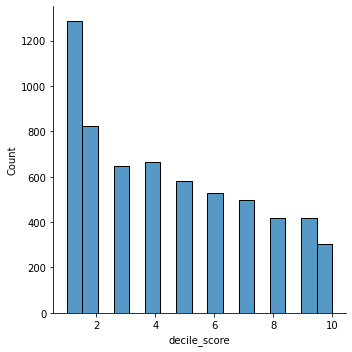

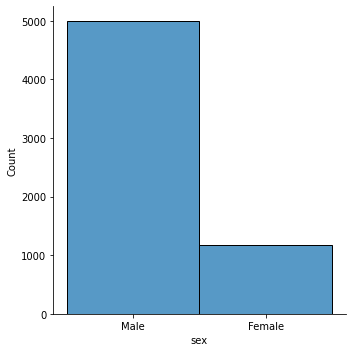

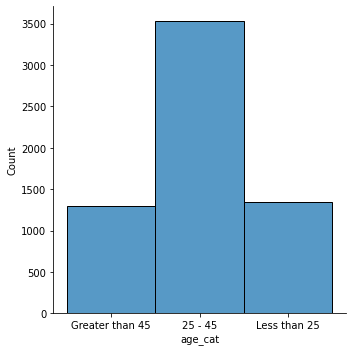

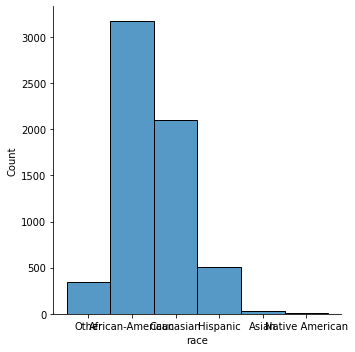

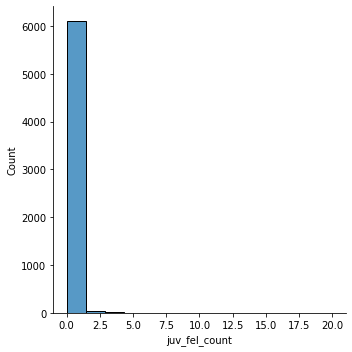

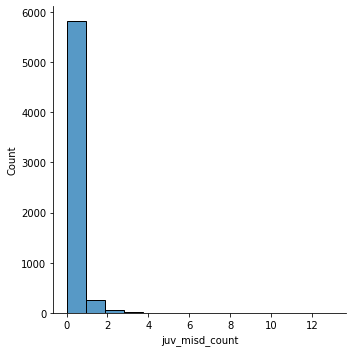

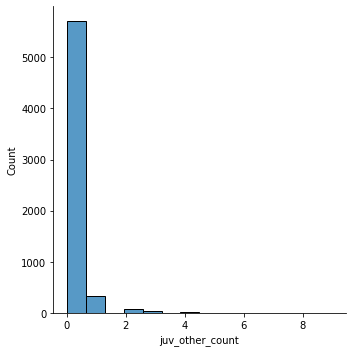

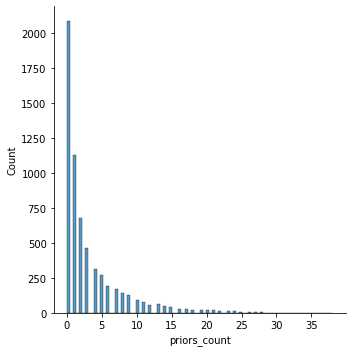

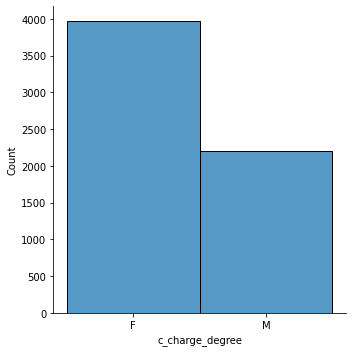

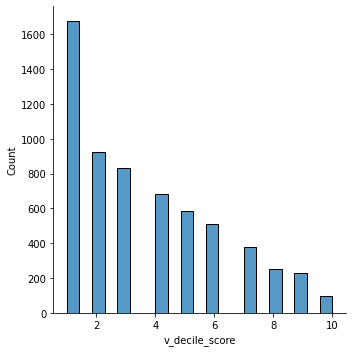

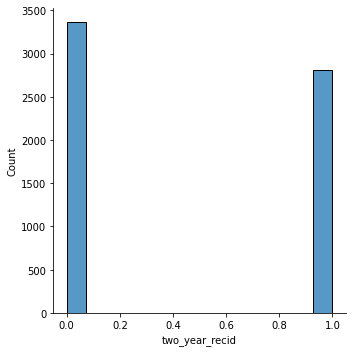

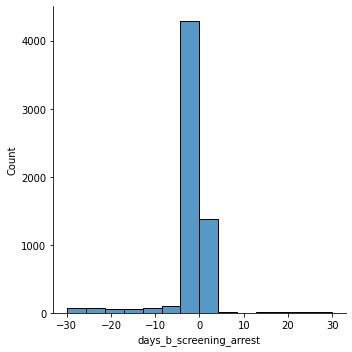

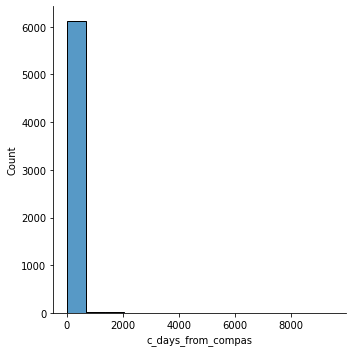

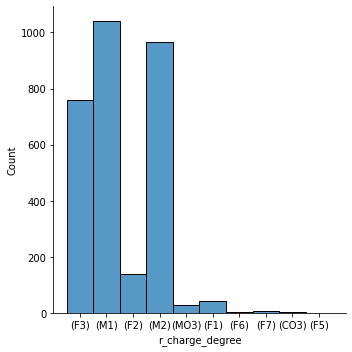

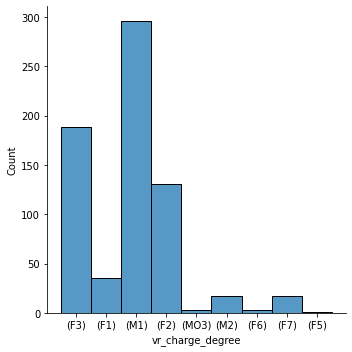

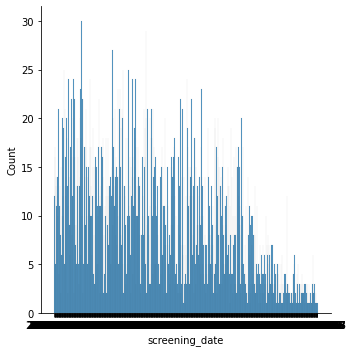

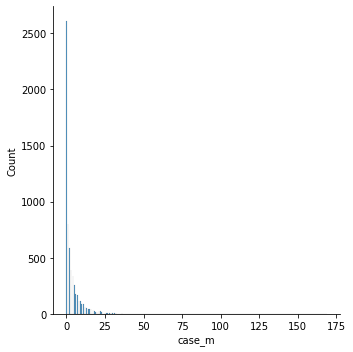

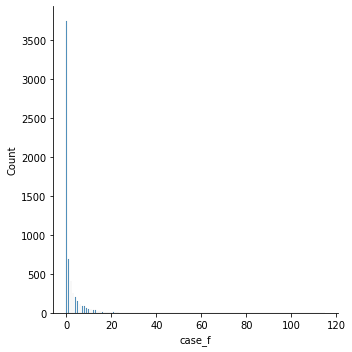

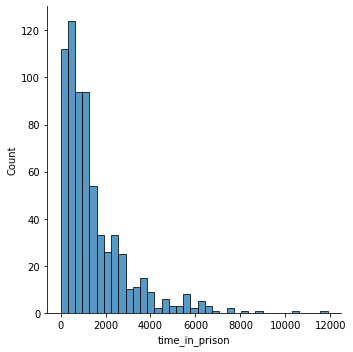

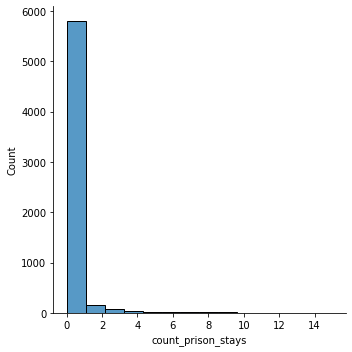

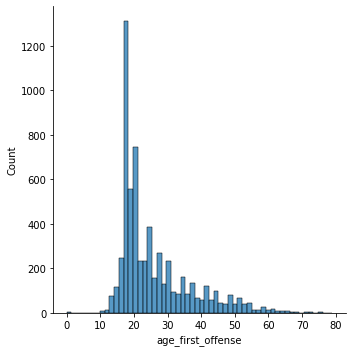

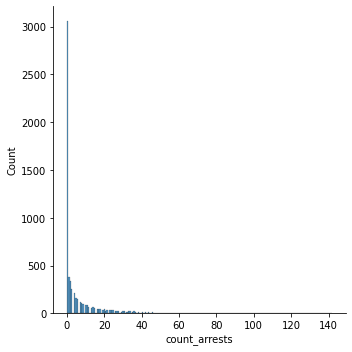

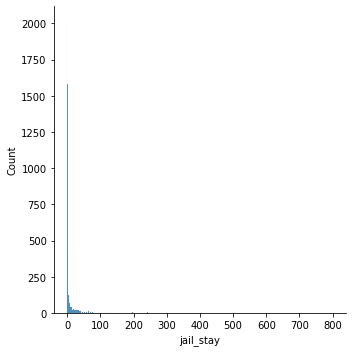

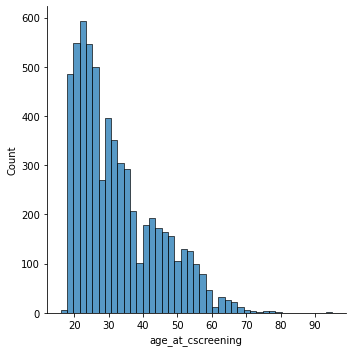

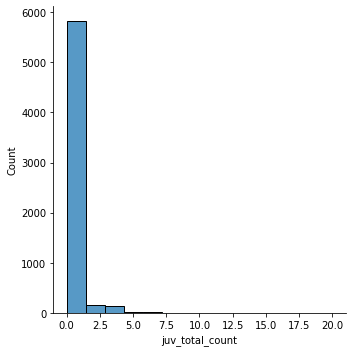

In [ ]:
column = ["decile_score", "sex", "age_cat", "race", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "v_decile_score", 
          "two_year_recid", "days_b_screening_arrest", "c_days_from_compas", "r_charge_degree", "vr_charge_degree", "screening_date","case_m", "case_f", 
          "time_in_prison", "count_prison_stays", "age_first_offense", "count_arrests", "jail_stay", "age_at_cscreening", "juv_total_count"]
df_plot = df[column]

for column in df_plot:
     sns.displot(x=column, data=df_plot)

# As visualized in the plots, the distribution of the variables are not Normally Distributed

### 3.2 The Spread of the Values and Detecting Outliers
Box plots are visualizing the spread of the values in a column and show the distribution of outliers. This analysis is very important before using models on a data frame, because many of the Machine Learning algorithms, such as Linear Regression and K-Nearest Neighbors, are sensitive to outliers. On the other hand, models such as Random Forest are not affected by Outliers at all.

As visualzied through the output of the boxplots, many variables have far higher maximum values (outliers) compared to the most other values. As algorithms learn from the provided data, outliers may induce the algorithm to overweight the likelihood of extremely low or high values, overfitting the training set. This would limit the algorithm to generalize well to new data. For some models standardizing the data will be necessary, especially models which use distance when making predictions.

Major outliers are in the columns: case_m, age, juv_fel_count, juv_total_count, age_at_screening

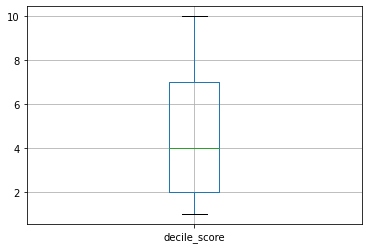

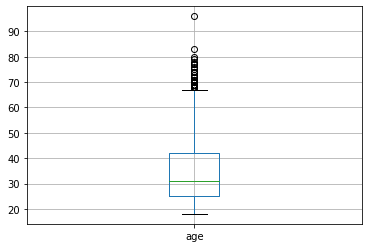

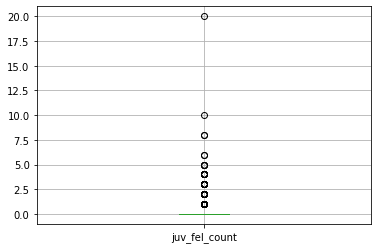

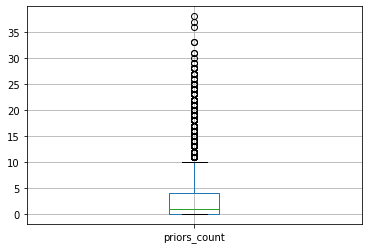

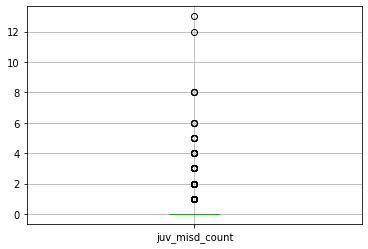

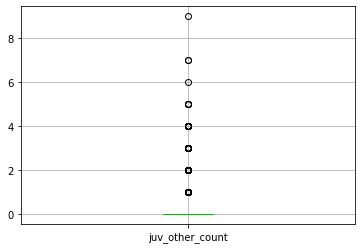

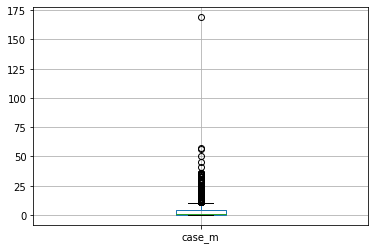

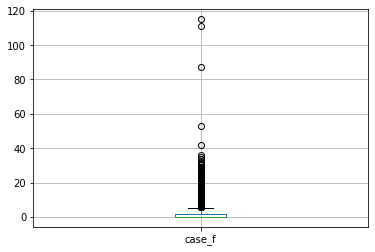

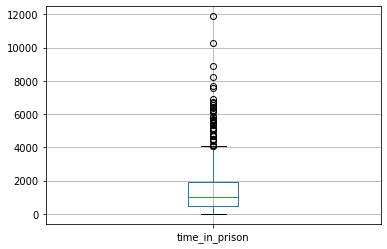

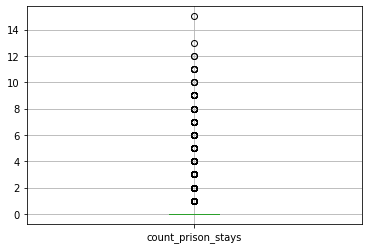

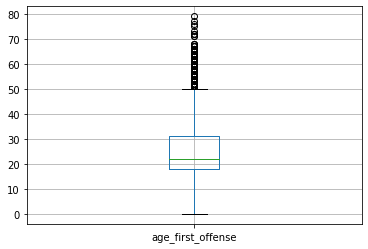

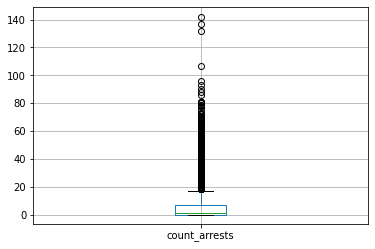

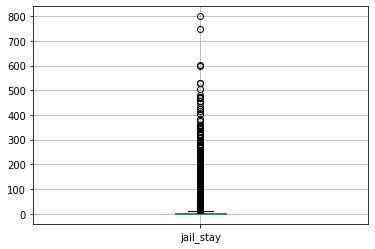

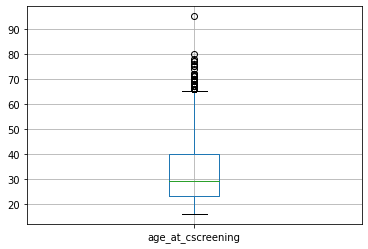

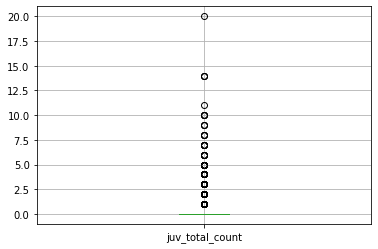

In [ ]:
column_boxplot = ["decile_score", "age", "juv_fel_count", "priors_count", "juv_misd_count", "juv_other_count", "case_m", "case_f", 
                  "time_in_prison", "count_prison_stays", "age_first_offense", "count_arrests", "jail_stay", "age_at_cscreening", "juv_total_count"]
df_boxplot = df[column_boxplot]


for column_boxplot in df_boxplot:
   plt.figure()
   df_boxplot.boxplot([column_boxplot])


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

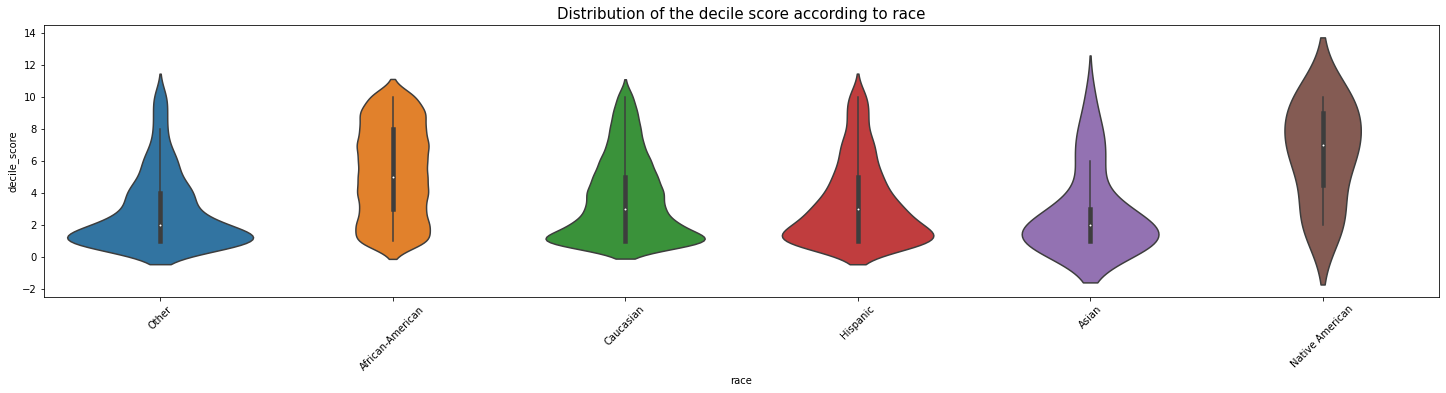

In [ ]:
plt.figure(figsize=(25,5))
sns.violinplot(x="race",y="decile_score",data=df)
plt.title("Distribution of the decile score according to race", fontsize = 15)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

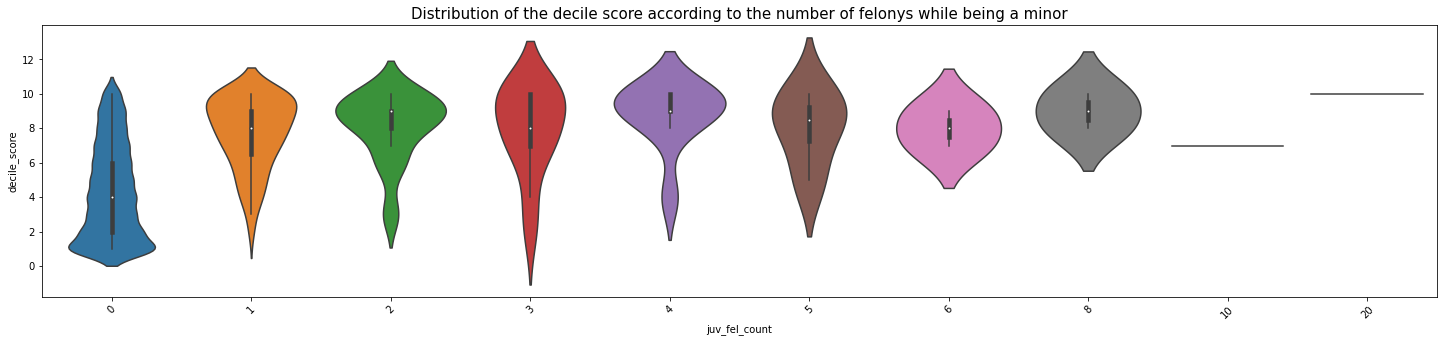

In [ ]:
plt.figure(figsize=(25,5))
sns.violinplot(x="juv_fel_count",y="decile_score",data=df)
plt.title("Distribution of the decile score according to the number of felonys while being a minor", fontsize = 15)
plt.xticks(rotation=45)

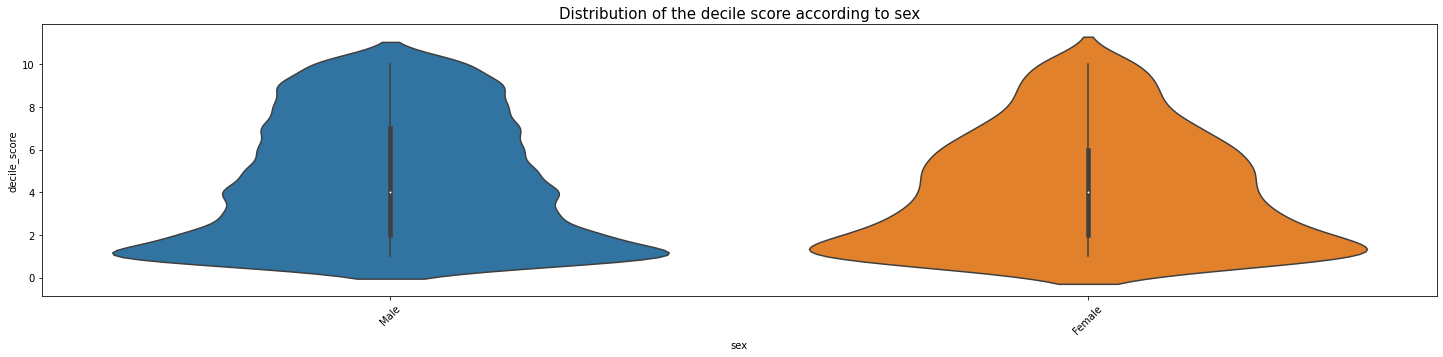

In [ ]:
plt.figure(figsize=(25,5))
sns.violinplot(x='sex',y='decile_score',data=df)
plt.title("Distribution of the decile score according to sex", fontsize = 15)
plt.xticks(rotation=45);

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

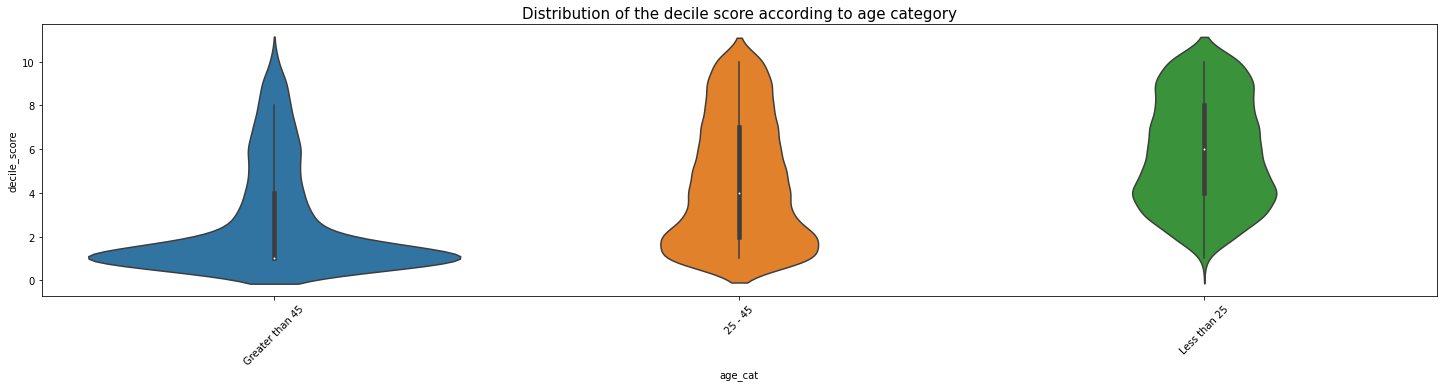

In [ ]:
plt.figure(figsize=(25,5))
sns.violinplot(x='age_cat',y='decile_score',data=df)
plt.title("Distribution of the decile score according to age category", fontsize = 15)
plt.xticks(rotation=45)

### 3.3 Correlation between Variables
The Correlation Matrix determines the correlation coefficients between the variables in a dataset. The correlation values are bound between values of –1 and +1, where +1 describes a positive correlation, 0 no linear correlation and -1 negative correlation. The Corrleation Matrix is only for linear relationships and numeric values.

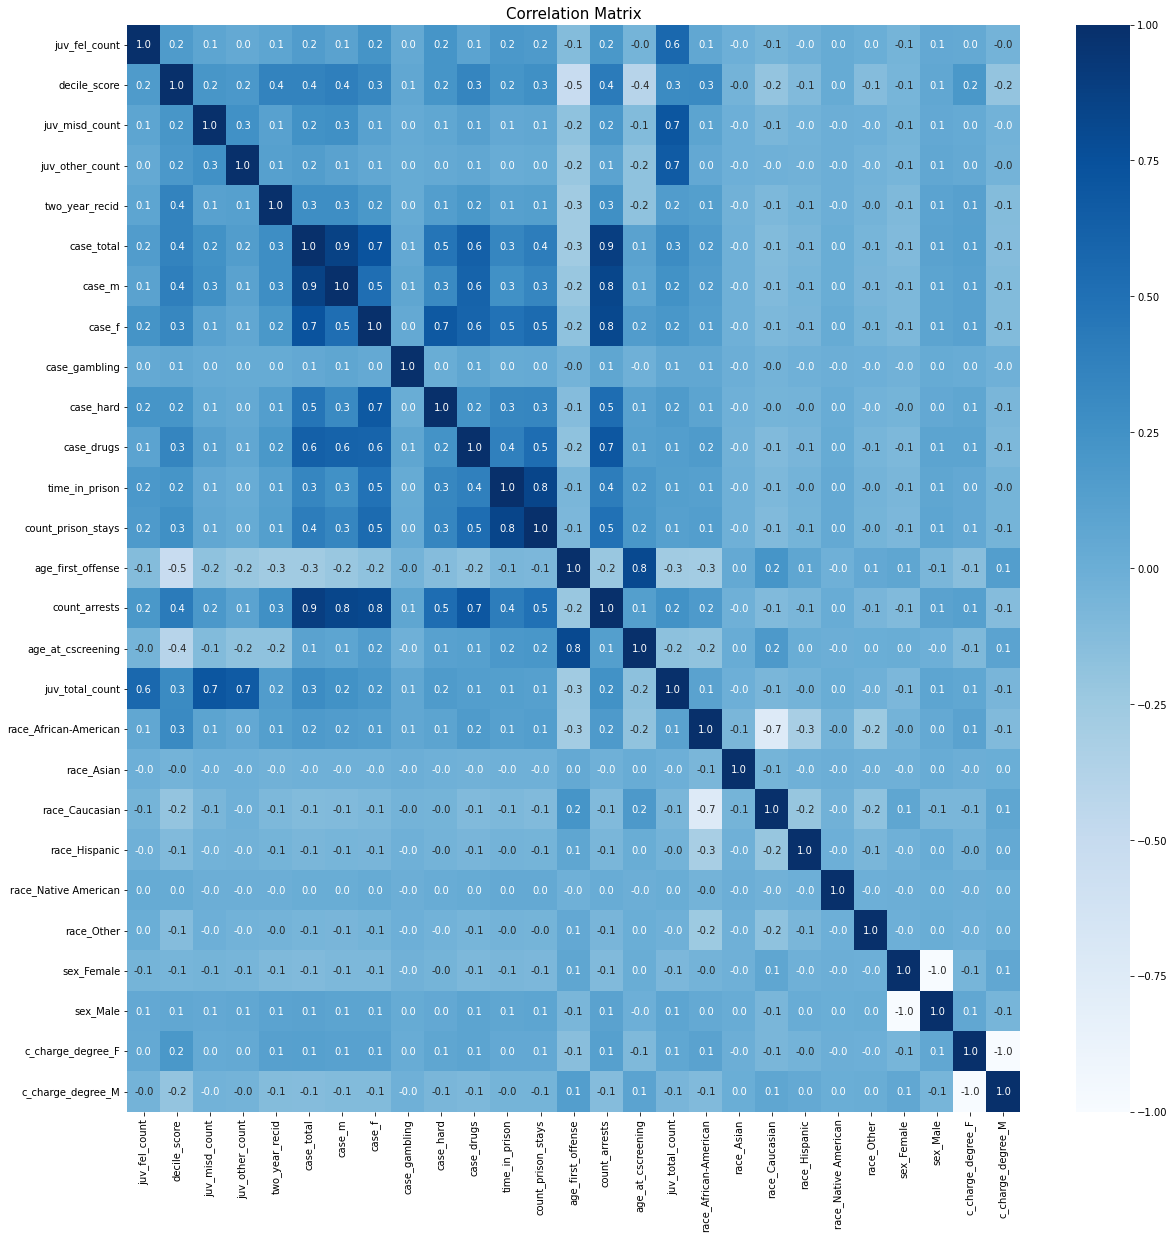

In [ ]:
df_corr = df_tree.drop(columns=["id"]).dropna(axis=1, how="any")
correlation_matrix = df_corr.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cbar=True, fmt=".1f", annot=True, cmap="Blues")
plt.title("Correlation Matrix", fontsize = 15)
plt.savefig("Correlation Heat map")

Below is the relationship between the target variables decile score and the number of juvenile felonies of the defendants.

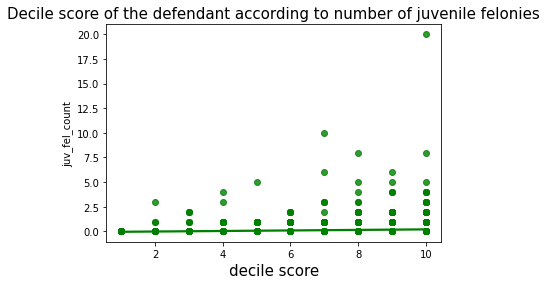

In [ ]:
sns.regplot(x="decile_score", y="juv_fel_count", data =df, color="g")
plt.title("Decile score of the defendant according to number of juvenile felonies", fontsize = 15)
plt.xlabel("decile score", fontsize = 15)
plt.show()

The relationship between the variables decile score and age of the defendants

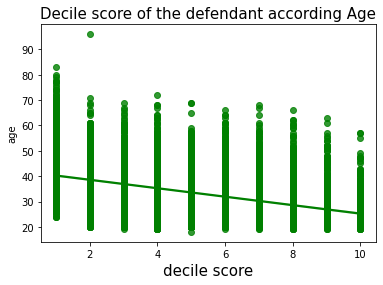

In [ ]:
sns.regplot(x="decile_score", y="age", data =df, color="g")
plt.title("Decile score of the defendant according Age", fontsize = 15)
plt.xlabel("decile score", fontsize = 15)
plt.show()

The relationship between the variables decile score and the priors count of the defendants

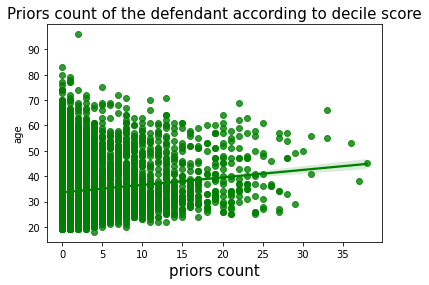

In [ ]:
sns.regplot(x="priors_count", y="age", data =df, color="g")
plt.title("Priors count of the defendant according to decile score", fontsize = 15)
plt.xlabel("priors count", fontsize = 15)
plt.show()

The relationship between the variables decile score and age at first offense of the defendants

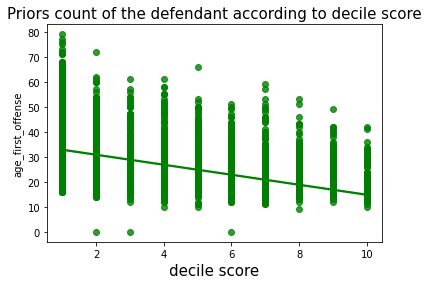

In [ ]:
sns.regplot(x="decile_score", y="age_first_offense", data =df_lin, color="g")
plt.title("Priors count of the defendant according to decile score", fontsize = 15)
plt.xlabel("decile score", fontsize = 15)
plt.show()

# 4 Functions

Below are the 5 functions that we will use throughout our Notebook.

In [ ]:
# Create function for classification metrics

def classification_metricsCV(model, X, y):
  
  cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
  cv_acc = cross_val_score(model, X, y, cv=5, scoring='accuracy')
  cv_pre = cross_val_score(model, X, y, cv=5, scoring='precision')
  cv_rec = cross_val_score(model, X, y, cv=5, scoring='recall')
  cv_f1 = cross_val_score(model, X, y, cv=5, scoring='f1')

  print("AUC score (5-fold cross-validation): {}".format(cv_auc))
  print("Average AUC score: {}".format(cv_auc.mean())) 
  
  print("Accuracy (5-fold cross-validation): {}".format(cv_acc))
  print("Average Accuracy: {}".format(cv_acc.mean()))

  print("Precision (5-fold cross-validation): {}".format(cv_pre))
  print("Average Precision: {}".format(cv_pre.mean()))

  print("Recall (5-fold cross-validation): {}".format(cv_rec))
  print("Average Recall: {}".format(cv_rec.mean()))

  print("F1 score (5-fold cross-validation): {}".format(cv_f1))
  print("Average F1 score: {}".format(cv_f1.mean()))


# Create function for plotting ROC curve

def plot_roc_curve(y_test, y_pred_prob, model, model_roc_auc):

  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

  plt.figure(figsize=(8,6))
  plt.plot([0, 1], [0, 1],'k--')
  plt.plot(fpr, tpr, label= str(model) + ' (area = %0.2f)' % model_roc_auc)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.show()

# function for train_test_split while saving ids
def id_split(X,y):

  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
  train_id = X_train['id']
  test_id = X_test['id']
  X_train = X_train.drop('id',axis=1)
  X_test = X_test.drop('id',axis=1) 
  
  return X_train,X_test,y_train,y_test,train_id,test_id

# function for comparing compas scores and predictions
def get_comparison_df(clf):
  # ids for later
  id_total = np.concatenate((test_id,train_id))

  # did recede
  id_recidivist = df_tree[['id','two_year_recid']]

  # preparation of arrays
  y_pred_test = clf.predict(X_test)
  y_pred_train = clf.predict(X_train)
  y_pred_total = np.concatenate((y_pred_test,y_pred_train))
  y_total = np.concatenate((y_test,y_train))

  # cut y_pred_total into Scores
  bins = [1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]
  binned = np.digitize(y_pred_total,bins=bins,right=False)+1

  # put everything in a DataFrame for easier handling
  df_comparison = pd.DataFrame(id_total,columns=['id'])
  df_comparison['y_pred'] = y_pred_total
  df_comparison['y_true'] = y_total
  df_comparison['y_pred_binned'] = binned
  df_comparison = pd.merge(left=df_comparison,right=id_recidivist, how='left', on='id')
  df_comparison = pd.merge(left=df_comparison,right=df[['id','race']], how='left', on='id')
  return df_comparison

# function for plotting comparison between compas scores and predictions
# Using it with multiple races works, just looks bad

def plot_comparison(df_comparison,race=False,yticks=np.arange(0,1300,200)):
  if race == False:
    race_used = df_comparison['race'].unique()
    race_name = 'total'
  else:
    race_used = race
    race_name = str(race)

  _ = plt.figure(figsize=(12,3),dpi = 200)
  _ = plt.subplot(1, 3, 1)
  _ = plt.hist([df_comparison[df_comparison['race'].isin(race_used)]['y_pred_binned']], bins = np.arange(1,12)-0.5,label=('prediction, total'),stacked=True,range=(1,10),align='mid',rwidth=0.5,alpha=1)
  _ = plt.hist([df_comparison[df_comparison['race'].isin(race_used)]['y_true']], bins = np.arange(1,12)-0.5,label=('compas, total'),stacked=True,range=(1,10),align='mid',rwidth=0.5, alpha=0.7)
  _ = plt.xticks(np.arange(1,11))
  _ = plt.yticks(yticks)
  _ = plt.legend()
  _ = plt.title('Distribution of Scores'+ race_name)

  _ = plt.subplot(1, 3, 2)
  #_ = plt.figure(figsize=(4,3),dpi = 200)
  _ = plt.hist([df_comparison[df_comparison['race'].isin(race_used)][df_comparison['two_year_recid']==1]['y_pred_binned']], bins = np.arange(1,12)-0.5,label=('prediction, recid'),stacked=True,range=(1,10),align='mid',rwidth=0.5,alpha=1)
  _ = plt.hist([df_comparison[df_comparison['race'].isin(race_used)][df_comparison['two_year_recid']==1]['y_true']], bins = np.arange(1,12)-0.5,label=('compas, recid'),stacked=True,range=(1,10),align='mid',rwidth=0.5, alpha=0.7)
  _ = plt.xticks(np.arange(1,11))
  _ = plt.yticks(yticks)
  _ = plt.legend()
  _ = plt.title('Distribution of Scores recid ' + race_name)

  _ = plt.subplot(1, 3, 3)
  #_ = plt.figure(figsize=(4,3),dpi = 200)
  _ = plt.hist([df_comparison[df_comparison['race'].isin(race_used)][df_comparison['two_year_recid']==0]['y_pred_binned']], bins = np.arange(1,12)-0.5,label=('prediction, not recid'),stacked=True,range=(1,10),align='mid',rwidth=0.5,alpha=1)
  _ = plt.hist([df_comparison[df_comparison['race'].isin(race_used)][df_comparison['two_year_recid']==0]['y_true']], bins = np.arange(1,12)-0.5,label=('compas, not recid'),stacked=True,range=(1,10),align='mid',rwidth=0.5, alpha=0.7)
  _ = plt.xticks(np.arange(1,11))
  _ = plt.yticks(yticks)
  _ = plt.legend()
  _ = plt.title('Distribution of Scores not recid ' + race_name)


# 5 Predicting Recidivism

In [ ]:
# Import common classification libraries

from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix, log_loss, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

## 5.1 Logistic Regression

### 5.1.1 Model Building

In [ ]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [ ]:
# Create dataframe
df_lr = df_lin
df_lr = df_lr.drop(columns=["decile_score","juv_fel_count","juv_misd_count","juv_other_count"]).dropna(axis=1, how="any")

The decile score needs to be dropped as our target variable will be "two_year_recid". Furthermore, the other defined columns are being dropped as well, because the correlation matrix in the general EDA displayes that there is almost no correlation between these variables and the recidivism of a defendant within two years.

In [ ]:
# Handle outlier
print(df_lr.case_m.max())
df_lr.drop(df_lr[df_lr.case_m == 169].index, inplace=True)

169.0


There seems to be a big outlier of a defendant having 169 prior misdemeanor charges, which may cause difficulties or improper scaling in the later points of analysis. Thus, the outlier has to be deleted.

In [ ]:
# Handle outlier
print(df_lr.case_m.max())

57.0


In [ ]:
# Load and split dataset
X = df_lr.drop(columns=["two_year_recid"])
y = df_lr.two_year_recid.values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train,X_test,y_train,y_test,train_id,test_id = id_split(X,y)

In [ ]:
feature_names = X_train.columns

Before using the dataset, we load and split it into a size of 70% training dataset and 30% test dataset. 

In [ ]:
# Standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

The dataset needs standardisation by removing the means and creating a dataset in a scaled range of values.



In [ ]:
# Create and fit logistic regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Make prediction
y_pred = lr.predict(X_test)
print('The accuracy of logistic regression classifier on the test set is at {:.2f}'.format(lr.score(X_test, y_test)))

The accuracy of logistic regression classifier on the test set is at 0.69


In order to make the predictions with logistic regression as a binary classifier, we first need to train the dataset  by fitting it to the model. Afterwards, the model can be used to make predictions.

It becomes apparent that with the logistic regression classifier, the mean accuracy on the test dataset lies at 69%.

### 5.1.2 Model Performance

In [ ]:
# Cross validate score
X = sc.fit_transform(X)

cv_auc = cross_val_score(lr, X, y, cv=5, scoring='roc_auc')
print("AUC score (5-fold cross-validation): {}".format(cv_auc))
print("Average AUC score: {}".format(cv_auc.mean())) 

cv_acc = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
print("Accuracy (5-fold cross-validation): {}".format(cv_acc))
print("Average Accuracy: {}".format(cv_acc.mean()))

cv_pre = cross_val_score(lr, X, y, cv=5, scoring='precision')
print("Precision (5-fold cross-validation): {}".format(cv_pre))
print("Average Precision: {}".format(cv_pre.mean()))

cv_rec = cross_val_score(lr, X, y, cv=5, scoring='recall')
print("Recall (5-fold cross-validation): {}".format(cv_rec))
print("Average Recall: {}".format(cv_rec.mean()))

cv_f1 = cross_val_score(lr, X, y, cv=5, scoring='f1')
print("F1 score (5-fold cross-validation): {}".format(cv_f1))
print("Average F1 score: {}".format(cv_f1.mean()))

AUC score (5-fold cross-validation): [0.74818759 0.72311437 0.7222721  0.74612883 0.71393885]
Average AUC score: 0.7307283492587784
Accuracy (5-fold cross-validation): [0.68340081 0.68395462 0.67017828 0.69205835 0.66288493]
Average Accuracy: 0.6784953969514236
Precision (5-fold cross-validation): [0.73424658 0.68874172 0.67579909 0.67913386 0.64038462]
Average Precision: 0.6836611715214186
Recall (5-fold cross-validation): [0.47686833 0.55614973 0.52762923 0.613879   0.59252669]
Average Recall: 0.5534105974968441
F1 score (5-fold cross-validation): [0.57820928 0.61538462 0.59259259 0.64485981 0.6155268 ]
Average F1 score: 0.6093146201035677


By using a 5-fold cross-validation on the data, we can see that the AUC scores in the logistic regression is at 73%, the accuracy and precision at 68%, the recall at 55% and the F1 score at 61%.

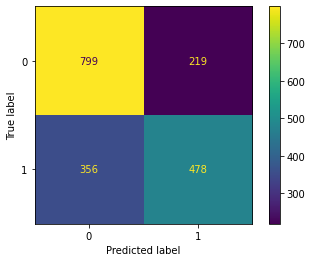

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_) 

disp.plot()

The confusion matrix shows, that the logistic regression classifier classified 799 defendants as recidivists and 478 defendants as non-recidivsts correctly. It also incorrectly predicts 219 non-recidivists as recidivists and 356 recidivists as non-recidivists. This equals to a TPR of 69%, a FNR of 31%, a TNR of 69% and FPR of 31%. 

In [ ]:
# Precision
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.78      0.74      1018
           1       0.69      0.57      0.62       834

    accuracy                           0.69      1852
   macro avg       0.69      0.68      0.68      1852
weighted avg       0.69      0.69      0.69      1852



Again, the classification report shows that the model classified 69% correctly (F1 score is the measure of the test's accuracy). From all the classes we have predicted as positive, 69% of the positively classified defendants are actually recidivists and were classified correctly (Precision score).

From all the positively identified recidivists, 57% of actual recidivists were correctly classified (Recall score).

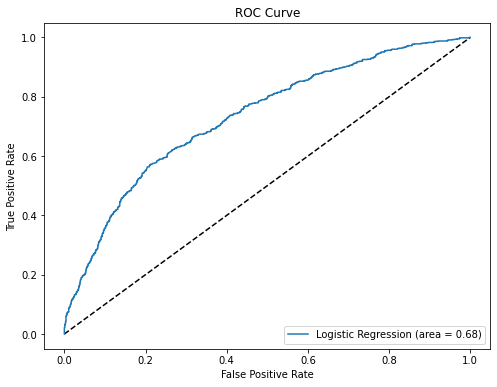

In [ ]:
# Plot ROC curve

y_pred_prob = lr.predict_proba(X_test)[:,1]
model_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
model = 'Logistic Regression'

plot_roc_curve(y_test, y_pred_prob, model, model_roc_auc)

The ROC curve above shows that the logistic regression model is not perfect in assessing the correct positive data points. However, the best threshold that separates best the defendants from recidivists and non-recidivists is at 0.68, which can be deducted from the ROC curve as the ability to separate the recidivists from non-recidivists.

In [ ]:
# Log loss function
lr_probs = lr.predict_proba(X_test)
print('Prediction probability: {:.2f}'.format(np.mean(lr_probs)))
print('Log-loss: {:.2f}'.format(log_loss(y_test, lr_probs)))

Prediction probability: 0.50
Log-loss: 0.61


The log-loss function implies how close the prediction probability is to the actual value. It seems that there is a difference of around 0.11 between the prediction probability with the logistic regression model and the log loss. Thus, it does not differ too much from the actual value.

### 5.1.3 Model Interpretation (Global)

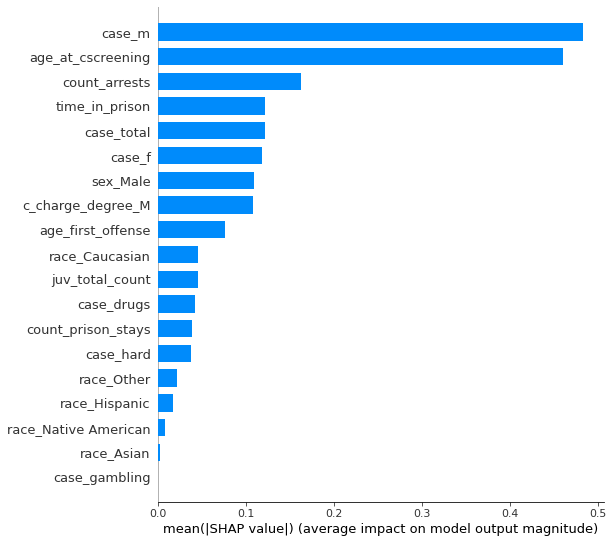

In [ ]:
# Feature importance
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=feature_names)

On a global level and global importance, when it comes to the prediction with the logistic regression model of classifying defendants as recidivists or non-recidivists, the features with large Shapley values are the prior misdemeanor charges, the age at the time the compas screening is conducted for the defendant, the count of prior arrests, the time in prison and the count of all the cases which all account for high weights into the predictions. For instance, the age at the compas screening changed the predicted absolute probability of recidivism by roughly 5 percentage points.

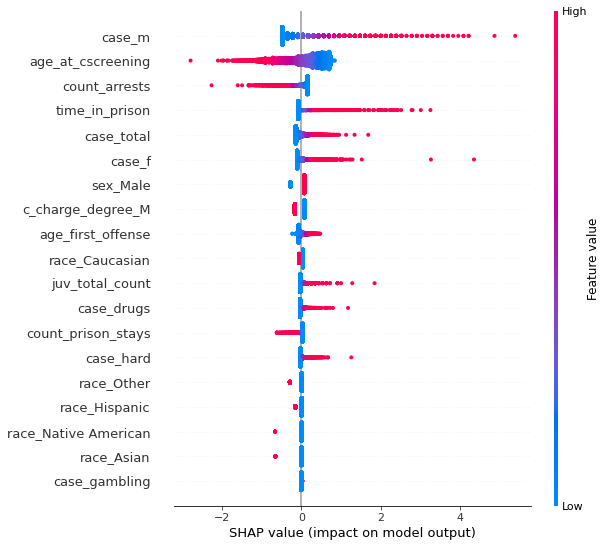

In [ ]:
# Summary plot
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

Looking at the summary plot that combines the feature importances with its feature effects, the features are also here displayed according to their impact on the predictions. With the most significant feature being the count of prior misdemeanor charges or count of prior crimes, it seems that higher counts or numbers lead to a higher probability of being classified as a recidivist. For the age at the compas screening, the diagram indicates that a younger age tends to increase the probability of being classified as a recidivist, whilst higher ages reduce the probability of being classified as a recidivist.

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


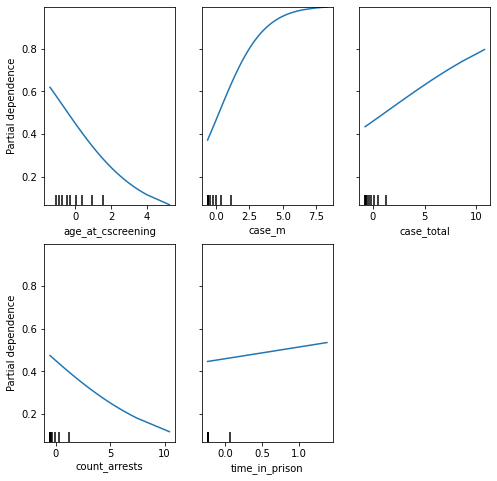

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_partial_dependence(lr, X_train, feature_names=feature_names, features = ['age_at_cscreening', 'case_m', 'case_total', 'count_arrests', 'time_in_prison'], ax=ax)

The partial dependence plots for the age at compas screening, the count of misdemeanor charges, the count of prior crimes, the count of arrests and the time in prison. Generally, the higher the age at the compas screening and the higher the count of arrests, the less a person is classified as a recidivist. On the contrary, the higher the count of misdemeanor charges, total cases and the time in prison the higher the probability is that a person is classified as a recidivist.

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


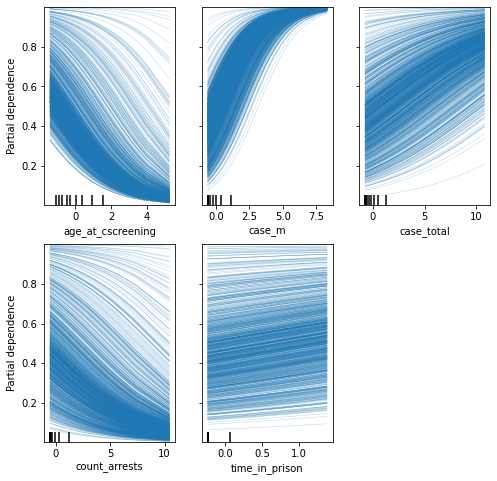

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_partial_dependence(lr, X_train, feature_names=feature_names, features = ['age_at_cscreening', 'case_m', 'case_total', 'count_arrests', 'time_in_prison'], ax=ax, kind='individual')

The individual conditional expectation (ICE) plots display how the prediction of a defendant being a recidivist within two years changes, when one of the 5 features changes. Each line represents one defendant.
For most defendants, there is a decrease in the probability of being classified as a recidivist when the defendant is older at the time of the compas screening and lower numbers of arrests are registered. On the contrary, there is an increase in the probability of being classified as a recidivist the more misdemeanor charges, the time in prison and the total number of prior total charges the defendant has.

### 5.1.4 Model Interpretation (Local)

In [ ]:
train_id

3115    4757
4351    6638
1833    2777
874     1326
5768    8787
        ... 
4414    6733
6064    9248
6102    9299
6296    9609
1006    1545
Name: id, Length: 4319, dtype: int64

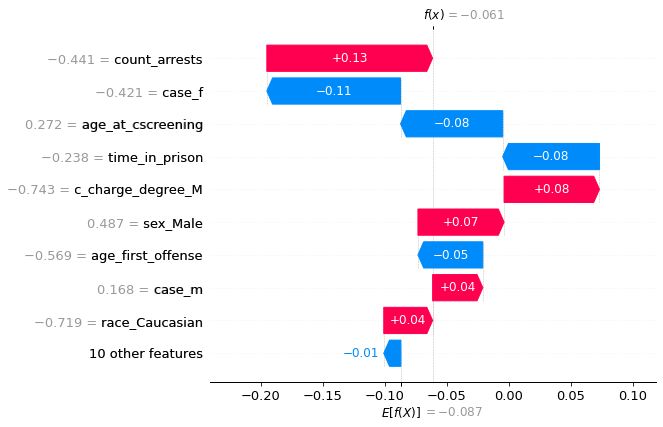

In [ ]:
example_case = X_train[train_id.isin([4757])]
two_year_recid = y_train[train_id.isin([4757])]
cases = lr.predict(example_case)
shap_values = explainer(example_case)
shap.plots.waterfall(shap.Explanation(values = shap_values[0], feature_names=feature_names))

This is an example of a local model explanation, where we visualize on particular defendant. We can see that by starting at the bottom, the expected value of being a recidivist in the two-year follow-up period would be at around 0. However, the different features, such as the race, the count of misdemeanor cases, the sex, the charge degree and the count of arrests counteract against the age of the defendant at the first offense and at compas screening, the time in prison and felony charges. It becomes apparent, that the expected value does not differ too much from the actual value.

## 5.2 KNN Classifier

### 5.2.1 Model Building

In [ ]:
# Import libraries
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

In [ ]:
# Create dataframe
df_knn = df_lin
df_knn = df_knn.drop(columns=["decile_score","juv_fel_count","juv_misd_count","juv_other_count"]).dropna(axis=1, how="any")

As conducted in the logistic regression model, the decile score has to be dropped as our target variable will be "two_year_recid". Furthermore, the other columns need to be dropped equally as the correlation matrix in the general EDA displayes that there is almost no correlation between these variables and the recidivism of a defendant within two years.

In [ ]:
# Handle outlier
print(df_knn.case_m.max())
df_knn.drop(df_knn[df_knn.case_m == 169].index, inplace=True)

169.0


There seems to be a big outlier of a defendant having 169 prior misdemeanor charges which may cause difficulties or biases in the later points of analysis. Thus, the outlier has to be deleted.

In [ ]:
# Load and split dataset
X = df_knn.drop(columns=["two_year_recid"])
y = df_knn['two_year_recid'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
X_train,X_test,y_train,y_test,train_id,test_id = id_split(X,y)

Again we loaded and split the dataset for the defendants only to be classified as recidivists (1) or non-recidivists (0) with a test size of 30%.

In [ ]:
# Create and fit k-NN classifier 
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

We started with the number of neighbours of 15 at first and then fitted the model with the training dataset in order to make the predictions with the test dataset.

### 5.2.2 Model Performance

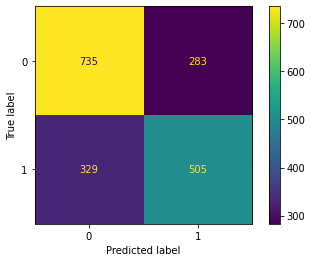

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_) 

disp.plot()

The confusion matrix shows that the K-nearest neighbors classifier classified 735 defendants as recidivists and 505 defendants as non-recidivsts correctly. It also incorrectly predicts 283 non-recidivists as recidivists and 329 recidivists as non-recidivists. This equals to a TPR of 69%, a FNR of 31%, a TNR of 64% and FPR of 36%. 

In [ ]:
# Evaluate algorithm
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.72      0.71      1018
           1       0.64      0.61      0.62       834

    accuracy                           0.67      1852
   macro avg       0.67      0.66      0.66      1852
weighted avg       0.67      0.67      0.67      1852



It turns out that 65% of the test dataset were correctly identified as recidivists or non-recidivists. 

Looking at the precision value, from all the defendants correctly predicted as non-recidivists, we have predicted 69% correctly, whilst 64% of the recidivists were predicted correctly. 

Looking at the recall scores, it becomes obvious that actually 72% of the non-recidivists are non-recidivists, whilst 61% of the recidivists are recidivists.

In [ ]:
# Tuning
#parameters = {"n_neighbors": range(1, 100)}
#gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
#gridsearch.fit(X_train, y_train)
#gridsearch.best_params_

# Get the best parameters: {'n_neighbors': 67}

The K-nearest neighbors classifier can be tuned with the hyperparameter of the number of neighbours. By setting the range between 1 and 100, with GridSearch the best number of neighbors appeared to be 67.

In [ ]:
# Fit k-NN classifier to tuned parameter 'n_neighbors'
knn = KNeighborsClassifier(n_neighbors=67)
knn.fit(X_train, y_train)

# Make its predictions
y_pred = knn.predict(X_test)

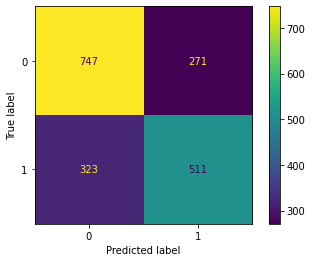

In [ ]:
# Build confusion matrix with new 'n_neighbors'
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_) 

disp.plot()

Looking at the hypertuned confusion matrix, one can see that the K-nearest neighbors classifier classified 757 defendants as recidivists and 503 defendants as non-recidivsts correctly. It also incorrectly predicts 261 non-recidivists as recidivists and 331 recidivists as non-recidivists. This equals to a TPR of 70%, a FNR of 30%, a TNR of 66% and FPR of 34%. 

In [ ]:
# Evaluate algorithm with new 'n_neighbors'
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1018
           1       0.65      0.61      0.63       834

    accuracy                           0.68      1852
   macro avg       0.68      0.67      0.67      1852
weighted avg       0.68      0.68      0.68      1852



When computing the confusion matrix and classification report again, the values do not differ too significantly from the ones before tuning. Our accuracy is at 68% being one percentage points higher than when using k = 15 neighbors.

In [ ]:
# Accuracy
print('The accuracy of the K-nearest neighbor classifier equals to {:.2f}.'.format(knn.score(X_test, y_test)))

The accuracy of the K-nearest neighbor classifier equals to 0.68.


In [ ]:
# Cross validate score
X = sc.fit_transform(X)

cv_auc = cross_val_score(knn, X, y, cv=5, scoring='roc_auc')
print("AUC score (5-fold cross-validation): {}".format(cv_auc))
print("Average AUC score: {}".format(cv_auc.mean())) 

cv_acc = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
print("Accuracy (5-fold cross-validation): {}".format(cv_acc))
print("Average Accuracy: {}".format(cv_acc.mean()))

cv_pre = cross_val_score(knn, X, y, cv=5, scoring='precision')
print("Precision (5-fold cross-validation): {}".format(cv_pre))
print("Average Precision: {}".format(cv_pre.mean()))

cv_rec = cross_val_score(knn, X, y, cv=5, scoring='recall')
print("Recall (5-fold cross-validation): {}".format(cv_rec))
print("Average Recall: {}".format(cv_rec.mean()))

cv_f1 = cross_val_score(knn, X, y, cv=5, scoring='f1')
print("F1 score (5-fold cross-validation): {}".format(cv_f1))
print("Average F1 score: {}".format(cv_f1.mean()))

AUC score (5-fold cross-validation): [0.73626086 0.70872037 0.69991895 0.72840806 0.69599565]
Average AUC score: 0.7138607759071041
Accuracy (5-fold cross-validation): [0.65910931 0.66207455 0.6636953  0.69124797 0.64424635]
Average Accuracy: 0.6640746986528783
Precision (5-fold cross-validation): [0.73421927 0.65189873 0.67804878 0.70521542 0.66487936]
Average Precision: 0.6868523119675017
Recall (5-fold cross-validation): [0.39323843 0.55080214 0.49554367 0.55338078 0.44128114]
Average Recall: 0.48684923338471586
F1 score (5-fold cross-validation): [0.51216686 0.59710145 0.57260556 0.62013958 0.53048128]
Average F1 score: 0.5664989470045025


By using a 5-fold cross-validation on the data, we can see that the AUC scores in the K-nearest neighbours classifier is at 71%, the accuracy at 66%, the precision at 69%, the recall at 48% and the F1 score at 56%.

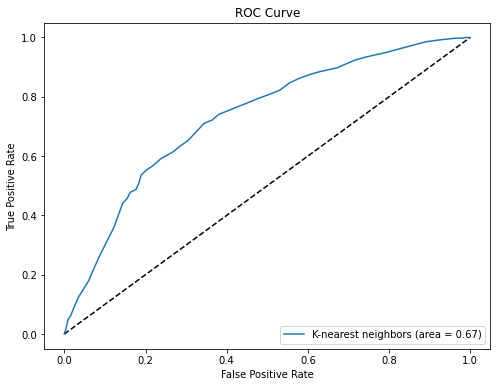

In [ ]:
# Plot ROC curve

y_pred_prob = knn.predict_proba(X_test)[:, 1]
model_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
model = 'K-nearest neighbors'

plot_roc_curve(y_test, y_pred_prob, model, model_roc_auc)

The ROC curve above shows that the K-nearest neighbor classifier is not totally accurate in assessing the correct positive data points. However, the best threshold that separates the defendants best from recidivists and non-recidivists is at 0.67, which can be deducted from the area under the ROC curve as the ability to separate the recidivists from non-recidivists.

In [ ]:
# Log loss function
knn_probs = knn.predict_proba(X_test)
log_loss(y_test, knn_probs)
print('Prediction probability: {:.2f}'.format(np.mean(knn_probs)))
print('Log-loss: {:.2f}'.format(log_loss(y_test, knn_probs)))

Prediction probability: 0.50
Log-loss: 0.60


The log-loss function implies how close the prediction probability is to the actual value. It seems that there is a difference of around 0.10 between the prediction probability with the logistic regression model and the log loss. Thus, it does not differ too much from the actual value.

Explaining the prediction with the K-nearest neighbors classifier cannot be performed with SHAP values or partial dependence plots as there is no definition for feature importances in case of a K-nearest neighbor classification algorithm. What can be stated considering all features in the dataframe is, that the optimal number of neighbours, where the model would not be underfitting or overfitting, was assessed.

## 5.3 XGBoost and Random Forest

### 5.3.1 Model Building

Moving forward in our task to predict recidivism directly, this chapter is dedicated to ensemble-Learning methods, using Random Forest and 
XGBoost as our go-to models. As with previous classification algorithms, the first step consists of preparing our dataset by splitting it into train and test sets. 

Next, we use a GridSearchCV for each model respectively to hypertune selected features. By applying this technique, we try to find the optimal number of trees used (n_estimators) and their depth (max_depth) for both models. In regards to our XGBoost, we also hypertune for the learning rate which shrinks the feature weights to ultimately make the boosting process more conservative.

By utilizing the described approach, we want to minmize overfitting for both models and increase their performance.  

Lastly, we fit our classifiers onto the training data and make predictions.

In [ ]:
# Import classifiers

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Prepare data

df_ens = df_tree
df_ens = df_ens.drop(columns=["decile_score", "id"]).dropna(axis=1, how="any")

X = df_ens.drop(columns=["two_year_recid"])
y = df_ens['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
# Define parameters for RF

#n_estimators = np.arange(1,51,1)
#max_depth = np.arange(1,21,1)

#test_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

# Initiate classifier

#forrest = RandomForestClassifier(random_state=42)


# Create GridSearch

#gs = GridSearchCV(forrest, test_params, cv=5)
#gs.fit(X_train, y_train)

# Get the best parameters

#gs.best_params # --> {'max_depth': 6, 'n_estimators': 20}

In [ ]:
# Initiate RF classifier with best parameters

rf = RandomForestClassifier(random_state=42, max_depth=6, n_estimators=20)


# Fit RF

rf.fit(X_train, y_train)


# Make predictions 

y_pred1 = rf.predict(X_test)

In [ ]:
# Define parameters for XGBoost

#n_estimators = np.arange(1,51,1)
#max_depth = np.arange(1,21,1)
#learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

#test_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate' : learning_rate}

# Initiate classifier

#boost = XGBClassifier(random_state=42)

# Create GridSearch

#gs2 = GridSearchCV(boost, test_params, cv=5)
#gs2.fit(X_train, y_train)

# Get the best parameters

#gs2.best_params_ # --> {'max_depth': 3, 'n_estimators': 38, 'learning_rate' : 0.2}

In [ ]:
# Initiate XGBoost classifier with best parameters

xgb = XGBClassifier(random_state=42, max_depth=3, n_estimators=38, learning_rate=0.2)


# Fit XGBoost

xgb.fit(X_train, y_train)


# Make predictions 

y_pred2 = xgb.predict(X_test)

### 5.3.2 Model Performance

The first step to validate our models is to conduct a safety check in regards to overfitting. For that purpose, we compute a basic accuracy score for both models, using training and test data-sets.

Seeing higher scores on the train data, while having relatively low results on the test data indicate overfitting. The model performs well on seen data (train set) but is unable to generalize on unseen information (test set).

For both models, we see slightly higher scores for the train sets, which makes sense. The delta between training and testing scores seem moderate. We therefore assume that our models do not overfit.  

In [ ]:
# Use .score() on train and test data to check overfitting

print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.7138888888888889
0.6841252699784017
0.7175925925925926
0.6808855291576674


After checking for overfitting, we want to measure the performance of our models by using a 5-fold cross-validation and display the average of all folds.

This helps us to minimize the possible over-/underestimation of our models due to the arbitrary train/test split and the validation on only one hold-out set.

In [ ]:
# Validate XGBoost model using 5-fold Cross-Validation

classification_metricsCV(xgb, X, y)

AUC score (5-fold cross-validation): [0.7648205  0.73196316 0.72932012 0.76514441 0.74090329]
Average AUC score: 0.7464302989490894
Accuracy (5-fold cross-validation): [0.70526316 0.67044534 0.67828201 0.69773096 0.68476499]
Average Accuracy: 0.6872972919769815
Precision (5-fold cross-validation): [0.6875     0.64650284 0.65830116 0.68787276 0.66539197]
Average Precision: 0.6691137453333319
Recall (5-fold cross-validation): [0.64590747 0.60854093 0.60784314 0.61565836 0.61921708]
Average Recall: 0.6194333961342544
F1 score (5-fold cross-validation): [0.66605505 0.62694775 0.63206673 0.64976526 0.64147465]
Average F1 score: 0.6432618882542952


In [ ]:
# Validate Random Forest model using 5-fold Cross-Validation

classification_metricsCV(rf, X, y)

AUC score (5-fold cross-validation): [0.75927884 0.72789417 0.7172397  0.75903581 0.73842622]
Average AUC score: 0.7403749482996964
Accuracy (5-fold cross-validation): [0.69959514 0.66963563 0.65883306 0.68962723 0.67909238]
Average Accuracy: 0.679356688692183
Precision (5-fold cross-validation): [0.69690722 0.64980545 0.63358779 0.67793241 0.66938776]
Average Precision: 0.6655241221787691
Recall (5-fold cross-validation): [0.60142349 0.59430605 0.59180036 0.60676157 0.58362989]
Average Recall: 0.595584270589504
F1 score (5-fold cross-validation): [0.64565425 0.62081784 0.61198157 0.64037559 0.62357414]
Average F1 score: 0.6284806784532754


As can be seen, the XGBoost performs the best on all given metrics when compared to the Random Forest. Also in regards to our main model comparison metric, the AUC, the XGboost performs best among all used models for classification.

In addition to that, we compute the given metrics, we also plot ROC-curves for the Random Forest and XGBoost.

In [ ]:
# Plot ROC curves 1/2

classifiers = [xgb, rf]


result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    
result_table.set_index('classifiers', inplace=True)

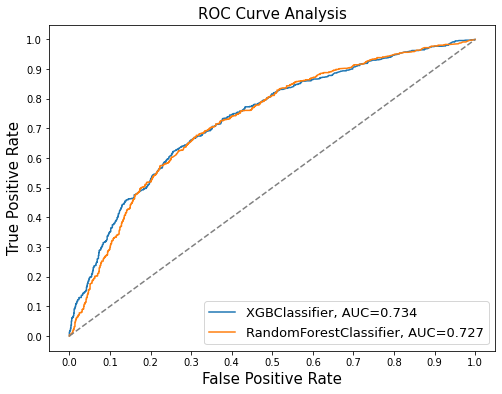

In [ ]:
# Plot ROC curves 2/2

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='grey', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Besides looking at the five metrics provided earlier, we also want to drill a bit deeper into the prediction results by plotting different confusion matrices based on the XGBoost. The first one covers all of our 1852 predictions made. We compute the false positive Rate (FPR) and false negative Rate (FNR). For the provided use case, false positives and false negatives are defined as followed: 

FP: A defendant is classified as recidivist by our model, while the ground truth says that the same person did not reoffend within a 2-year time period after the compas screening.

FN: A defendant is classified as non-recidivist by our model, while the ground truth says that the same person did reoffend within a 2-year time period after the compas screening.

We discover a higher FNR (0.36) then FPR (0.28).

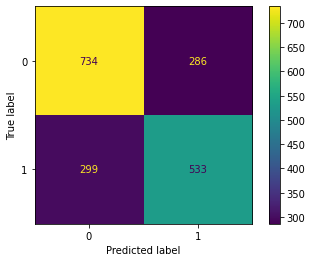

In [ ]:
# Build Confusion-Matrix

cm = confusion_matrix(y_test, y_pred2, labels=xgb.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_) 

disp.plot()

### False-Positive Rate: 0.28 
### False-Negative Rate: 0.36

Looking at the FNR and FPR, it is natural to pose the question in regards to which rate should be weighted more. Might it be worse for a person to be wrongly labeled as recidivist and being treated differently by the jurisdiction based on that? Or is it a bigger threat for communities, if defendents are labeled as non-reoffender in the next two years but actually committing a crime within that period?  

While discussing that question in our group, we clearly came to the conclusion that there is no easy answer to give. Nevertheless, we want to emphasize on the possibility to change our prediction outcomes by adapting the actual prediction threshold. By default, the value here is 0.5. If we raise this measure, we would decrease the prediction space of being labeled as recidivist and increase the prediction space of being labeled as non-recidivist and vice-versa. 

In our example provided below, we tried to balance both rates and changed the prediction threshold to 0.47, which increased the FPR to 0.32 and decreased the FNR to 0.33.   

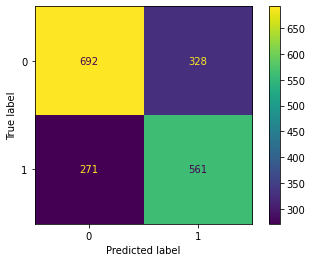

In [ ]:
# Adjust prediction threshold

y_pred3 = (xgb.predict_proba(X_test)[:,1] >= 0.47).astype(bool)

cm = confusion_matrix(y_test, y_pred3, labels=xgb.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_) 

disp.plot()


### False-Positive Rate: 0.32 
### False-Negative Rate: 0.33

In regards to the next two confusion matrices below, we filtered our predictions based on "race_African-American" and "race_Caucasian" to investigate a possible bias between privileged and non-privileged groups (privileged and unprivileged as defined by Bellamy et al. 2019). 

We discovered that predictions filtered by "race_African-American" actually hold a higher FPR (0.38) compared to the results filtered by "race_Caucasian" (0.18), while the outcomes for the FNR display the different direction. In comparison to that, the FPR and FNR from COMPAS provided by ProPublica are the following: 

Black Defendents: FPR: 0.45, FNR: 0.28
White Defendents: FPR: 0.23, FNR: 0.48

This means for that specific set of predictions, that our XGBoost is also more likely to classify African-Americans as recidivist, while the ground truth holds the opposite information, when compared directly to Caucasian-Americans.

In addition to computing FPR and FNR, we use the Average Odds Difference as a fairness metric, also applied by Grad/Koprowska (2020) and introduced by Bellamy et al. (2019). 

AOD: ((0.38 - 0.18) + (0.75 - 0.46)) / 2 = 0.245

Since a value of 0 implies that both groups have equal benefit, we see that our XGBoost classifier displays higher benefit for the unprivileged group of African-American in that particular test set since the AOD is above 0 (Bellamy et al., 2019). Based on that metric, it seems that our model is not yet completely fair.

This might collide with the first impression in regards to racial bias/difference while only comparing the FPR for African American and Caucasian.

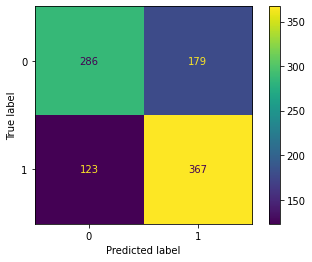

In [ ]:
# Confusion-Matrix filtered by race_African-American 

df_cm = pd.concat([X_test, pd.DataFrame(y_test)], axis=1)
df_cm_a = df_cm[df_cm["race_African-American"]==1]

y_test_a = df_cm_a["two_year_recid"]
X_test_a = df_cm_a.drop(columns=["two_year_recid"])

y_pred_a = xgb.predict(X_test_a)
ConfusionMatrixDisplay.from_predictions(y_test_a, y_pred_a)


### False-Positive Rate: 0.38
### False-Negative Rate: 0.25

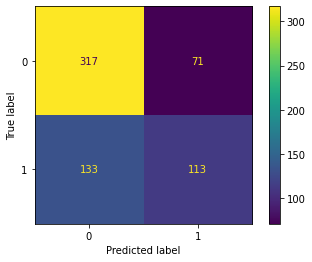

In [ ]:
# Confusion-Matrix filtered by race_Caucasian 

df_cm_b = df_cm[df_cm["race_Caucasian"]==1]


y_test_b = df_cm_b["two_year_recid"]
X_test_b = df_cm_b.drop(columns=["two_year_recid"])

y_pred_b = xgb.predict(X_test_b)
ConfusionMatrixDisplay.from_predictions(y_test_b, y_pred_b)


### False-Positive Rate: 0.18
### False-Negative Rate: 0.54

In [ ]:
# Alternative code for filtering y_pred2 without predicting again and to validate previous results 

#X_cm = X_test

#X_cm["y_test"] = y_test

#X_cm["predictions"] = y_pred2

#X_cm = X_cm[X_cm["race_African-American"]==1]


#y_test_cm = X_cm["y_test"]
#y_pred_cm = X_cm["predictions"]

#ConfusionMatrixDisplay.from_predictions(y_test_cm, y_pred_cm)

Sources:

A.Chidambaram (2021): Model Fairness & Transparency - SFU Professional Master’s Program in Computer Science, Medium, [online] https://medium.com/sfu-cspmp/model-transparency-fairness-552a747b444#:%7E:text=Average%20odds%20difference%20%E2%80%94%20This%20is,both%20groups%20have%20equal%20benefit. [abgerufen am 05.02.2022].



Bellamy, R. K. E./A. Mojsilovic/S. Nagar/K. Natesan Ramamurthy/J. Richards/D. Saha/P. Sattigeri/M. Singh/K. R. Varshney/Y. Zhang/K. Dey/M. Hind/
S. C. Hoffman/S. Houde/K. Kannan/P. Lohia/J. Martino/S. Mehta (2019): AI Fairness 360: An extensible toolkit for detecting and mitigating algorithmic bias, in: IBM Journal of Research and Development, vol. 63, no. 4/5, pp. 1–15, [online] doi:10.1147/jrd.2019.2942287.



Grad, Lukasz/Katarzyna Koprowska (2020): Chapter 10 Story COMPAS: recidivism reloaded | XAI Stories, pbiecek.github, [online] https://pbiecek.github.io/xai_stories/story-compas.html [abgerufen am 05.02.2022].



ProPublica (2016): How We Analyzed the COMPAS Recidivism Algorithm, ProPublica, [online] https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm [abgerufen am 06.02.2022].

### 5.3.3 Model Interpretation (Global)

Going into the interpretation for both ensemble models, we first start with the global explanation using SHAP feature importance, SHAP summary plots and PDPs for the five most important features.

In [ ]:
# Explain model predictions using SHAP library

explainer_xgb = shap.TreeExplainer(xgb) 
shap_values_xgb = explainer_xgb.shap_values(X_train)

explainer_rf = shap.TreeExplainer(rf) 
shap_values_rf = explainer_rf.shap_values(X_train)

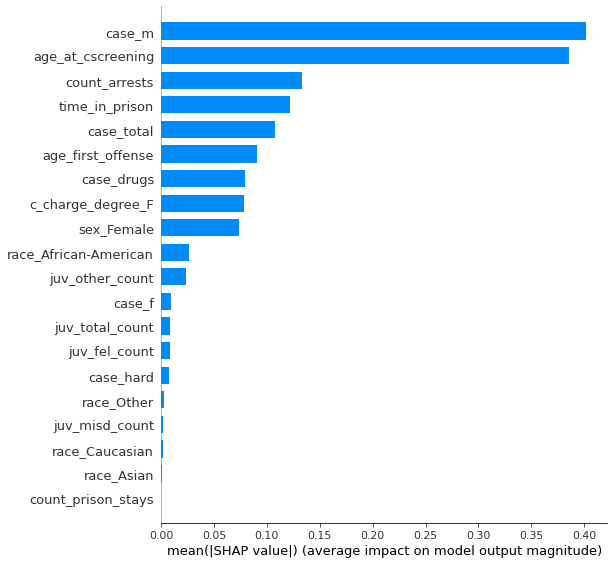

In [ ]:
# SHAP Feature Importance (XGBoost)

shap.summary_plot(shap_values_xgb, X_train, plot_type='bar', feature_names=X_train.columns)

As we can see in the figure above, the two most important features for the XGBoost are "case_m" and "age_at_cscreening" with a relatively high lead towards other features. We can also identify that the categorical features "sex_Female" and "race_African-American" have an impact on the models decision making. 

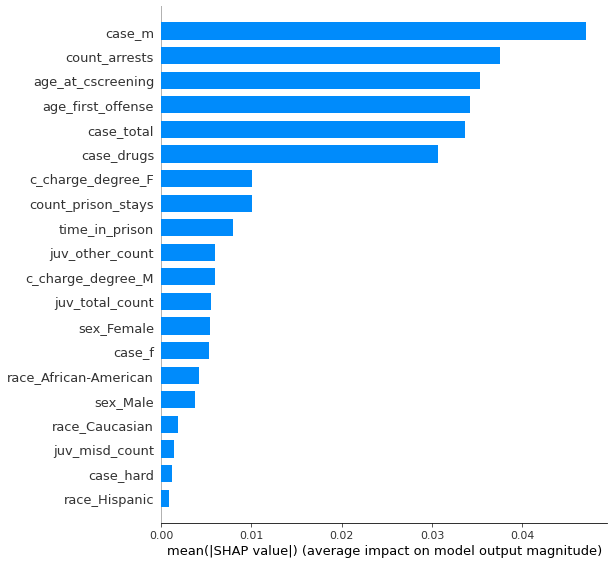

In [ ]:
# SHAP Feature Importance (Random Forest)

shap.summary_plot(shap_values_rf[0], X_train, plot_type='bar', feature_names=X_train.columns)

The Random Forest model also relies on "case_m" as the most important feature. In contrast to the XGBoost, the Random Forest seems to utilize up to five quite important and close by features in regards to their importance after the first feature. 

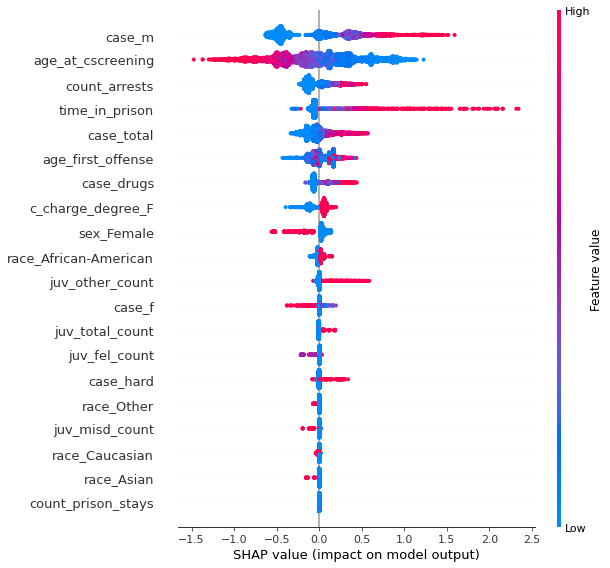

In [ ]:
# SHAP Summary Plot (XGBoost)

shap.summary_plot(shap_values_xgb, X_train)

In terms of interpretation, it seems that the more prior misdemeanor charges a defendent has, he or she is more likely to be classified by the XGBoost as recidivist. In contrast to that, older defendants at the point of the compas screening are more likely to be labeled as non-recidivist.

Counterintuitively, the other age variable "age_first_offense" has the different direction of feature value impact, when compared to "age_at_cscreening". One could assume that people who commit their first crime at a relatively young age are more likely to conduct another crime or reoffend in the future.

In regards to protected attributes, we can observe that the XGBoost favors female defendants while the model rather associates being African-American with recidivism compared to not being African-American.

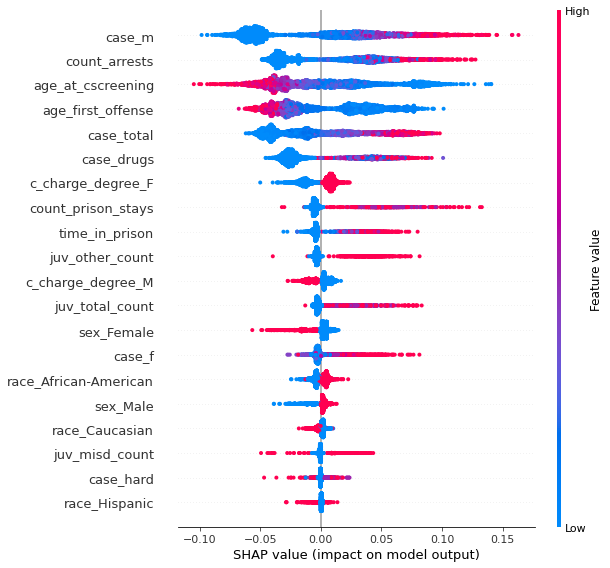

In [ ]:
# SHAP Summary Plot (Random Forest)

shap.summary_plot(shap_values_rf[1], X_train, plot_type='dot')

Regarding the direction of feature value impact, the Random Forest seems to behave quite like the XGBoost.

The only exception is "age_first_offense" which does not violate intuition here.

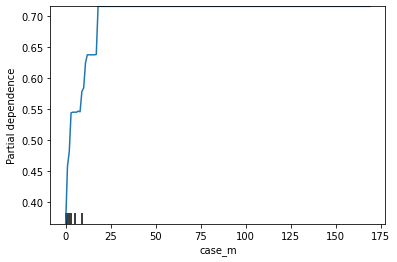

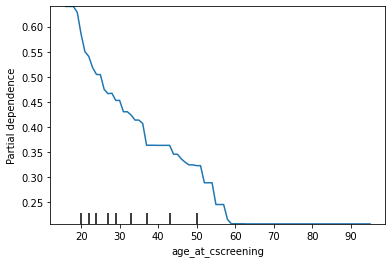

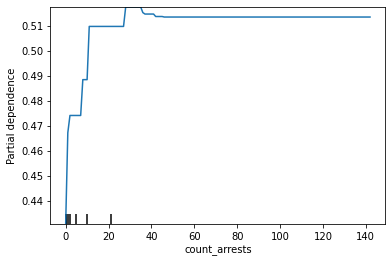

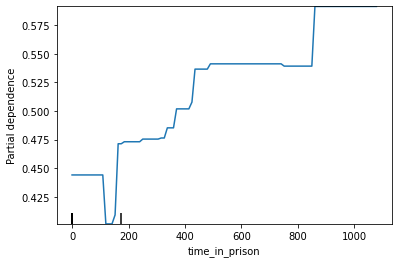

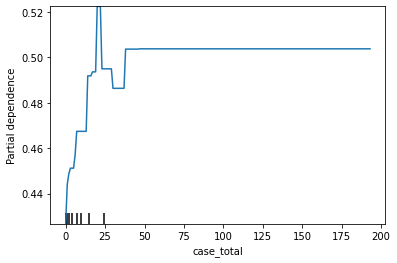

In [ ]:
# Plot PDPs (Top 5 non-categorical features, XGBoost)

features_noncat = [['case_m'], ['age_at_cscreening'], ["count_arrests"], ['time_in_prison'], ['case_total']]


for i in range(len(features_noncat)):

 PartialDependenceDisplay.from_estimator(xgb, X_train, features=features_noncat[i])

Looking at the PDPs for the Top 5 most important features of our XGBoost, we want to have a closer examination especially on the most non-linear or complex relationships.

Observing "time_in_prison", we can see a drop of the marginal effect on the prediction output at values around 170 to 180.

We can also identify this kind of drop in "case_total", starting at a value of around 25, moving downwards till approximately the value of 30.

While this might actually imply that people who have prison times around 170 and 180 are less likely to reoffend, this effect can also be due to not having enough training data for this specific range of values.

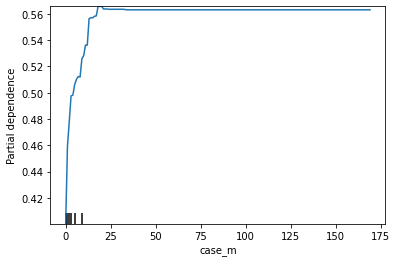

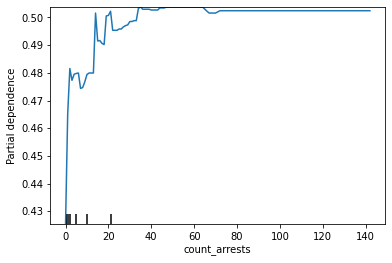

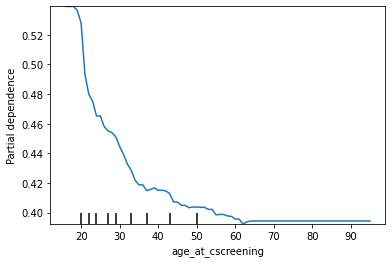

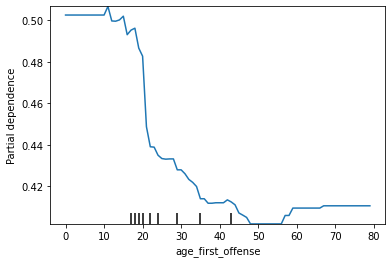

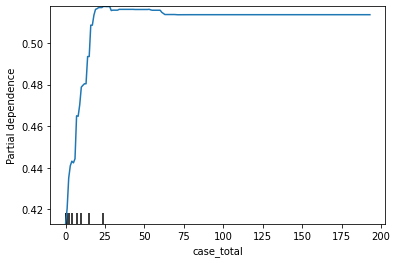

In [ ]:
# Plot PDPs (Top 5 non-categorical features, Random Forest)

features_noncat = [['case_m'], ["count_arrests"], ['age_at_cscreening'], ['age_first_offense'], ['case_total']] 

for i in range(len(features_noncat)):

 PartialDependenceDisplay.from_estimator(rf, X_train, features=features_noncat[i])

### 5.3.4 Model Interpretation (Local)

In this last section, the local model interpretation, we want to have a brief look at three examples. For that purpose, we use our best model to observe the three most important features with either minimum or maximum instances.

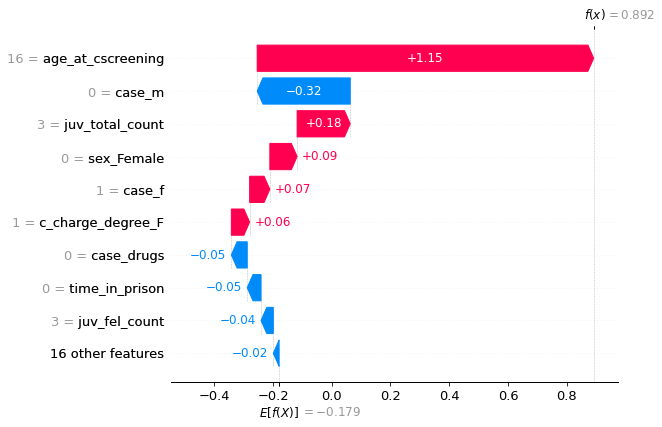

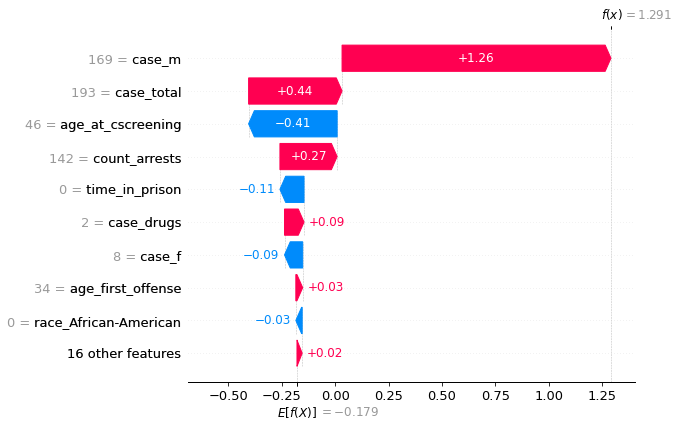

In [ ]:
# SHAP Waterfall Plots (XGBoost)

local_1 = X_train[X_train.age_at_cscreening == X_train.age_at_cscreening.min()]
local_2 = X_train[X_train.case_m == X_train.case_m.max()]


shap_values1 = explainer_xgb(local_1)
shap_values2 = explainer_xgb(local_2)


shap.plots.waterfall(shap_values1[1])
shap.plots.waterfall(shap_values2[0])

One interesting observation can be found while looking at the first SHAP waterfall plot. Here we can see that the decision-making process moves around the expected value of -0.179 until the "case_m" feature. Only when "age_at_cscreening" is taken into consideration, the value increases with a spike in favor of labeling that instance as recidivist.

Let us have a closer look at that instance:

In [ ]:
# Get index of instance

local_1.head()

juv_fel_count  juv_misd_count  ...  c_charge_degree_F  c_charge_degree_M
6293              5               0  ...                  1                  0
1357              3               0  ...                  1                  0

[2 rows x 25 columns]

In [ ]:
# Search the instance in the original data frames 1/2

df_tree.loc[[1357]]

id  juv_fel_count  ...  c_charge_degree_F  c_charge_degree_M
1357  2083              3  ...                  1                  0

[1 rows x 28 columns]

In [ ]:
# Search the instance in the original data frames 2/2

df.loc[[1357]]

id            name  ... juv_total_count not_recid
1357  2083  darren houston  ...               3     False

[1 rows x 69 columns]

In [ ]:
# Classify instance with XGBoost

pred = xgb.predict(X_train.loc[[1357]])

print(pred)

[1]


We see that this particular defendant did reoffend within two years after the compas screening. In addition, the XGBoost also labeled the instance with "1", as expected while looking at the plot. 

Even though the impact of "age_at_cscreening" seemed to have a quite strong or perhaps also too strong impact on the decision making, based on intuition, we see that the XGboost was right for that specific instance.

In [ ]:
# Example from presentation

#df.loc[[936]]

In [ ]:
# SHAP Waterfall Plots Fictional Characters

#fictional_case = xgb.predict(fictional_characters)
#fictional_case

In [ ]:
#shap_values5 = explainer(fictional_characters)
#shap.plots.waterfall(shap_values5[0])

# 6 Predicting Compas Scores

## 6.1 Elastic Net

### 6.1.1 Model Building

The elastic net regularization is a penalty term which combines L1 and L2 

In [ ]:
# Import libraries
from sklearn.linear_model import ElasticNet

Defining the Data frame for the Elastic Net and splitting the data into training and test set

In [ ]:
#Create data frame for Elastic Net: df_en
df_en = df_lin
df_en = df_en.drop(columns=["two_year_recid"]).dropna(axis=1, how="any")

In [ ]:
#Elastic nets are sensitive to outliers. For a better model generalization, delete extreme outlier which were detected on the boxplots

print(df_en.case_m.max())
print(df_en.age_at_cscreening.max())
print(df_en.juv_total_count.max())

df_en.drop(df_en[df_en.case_m == 169].index, inplace=True)
df_en.drop(df_en[df_en.age_at_cscreening == 95].index, inplace=True)
df_en.drop(df_en[df_en.juv_total_count == 20].index, inplace=True)


169.0
95
20


In [ ]:
# X is initalized with the features (independent variables), y with the labels (dependent variables)
X = df_en.drop(columns=["decile_score"])
y = df_en.decile_score.values

# Splitting the Date Frame into train / test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train,X_test,y_train,y_test,train_id,test_id = id_split(X,y)

Because the elastic net requires normailzing the data, we bulid a pipeline, which starts with the step StandardScaler for scaleing the data and then applies the ElasticNet algorithm. For the elastic net there are various hyperparameters specified in the dictionary. The corresponding hyperparameter is followed by a list or an array of values. The function GridSearchCV computes which of these values are scoring the best for that particular hyperparameter.

In [ ]:
#steps = [("scaler", StandardScaler()),
#         ("elasticnet", ElasticNet())]

#pipeline = Pipeline(steps)

#parameters for Elasticnet
#parameters = {"elasticnet__l1_ratio": np.arange(0.1,1.0,0.1),
#              "elasticnet__max_iter": [100000],
#              "elasticnet__selection": ["cyclic", "random"],
#              "elasticnet__alpha": np.arange(1e-4,1e-3,1e-4)}

#clf = GridSearchCV(pipeline, parameters)
#clf.fit(X_train, y_train)

#View best params
#print("Elasticnet best parameters: ", clf.best_estimator_.get_params()["elasticnet"])

#Elasticnet best parameters:  ElasticNet(alpha=0.0009, l1_ratio=0.9, max_iter=100000, selection='random')

The best hyperparameter for the elastic net are:

alpha=0.0009

l1_ratio=0.9 

selection='random'

------------------------------

Hyperparameter explanation:

l1_ratio = 1 

-> L1 penalty (Lasso)

l1_ratio < 1 

-> Combination of L1 & L2 penalty

alpha: constant which multiplies the penalty terms 

------------------------------


The parameters are specified in the ElasticNet, the model is trained on the training set, to validate the model and checking for overfitting of the model, we use cross validation on the whole set. 


In [ ]:
model_en = ElasticNet(alpha=0.0009, l1_ratio=0.9, selection='random', max_iter=100000, random_state=42)
model_en.fit(X_train, y_train)

CV_Result = cross_val_score(model_en, X, y, cv=5, scoring = "r2")
print(CV_Result)
print(np.mean(CV_Result))

[0.48032852 0.492386   0.4805638  0.45816602 0.45012669]
0.4723142053656934


### 6.1.2 Model Performance

In [ ]:
y_pred = model_en.predict(X_test)
print("Train-R2-Score: ", str(model_en.score(X_train,y_train)))
print("Test-R2-Score: ", str(model_en.score(X_test,y_test)))
print("Mean squared error:",str(mean_squared_error(y_test,y_pred)))
print("Mean absolute percentage error:",str(mean_absolute_percentage_error(y_test,y_pred)))
print("Mean absolute error:",str(mean_absolute_error(y_test,y_pred)))
print("Median absolute error:",str(median_absolute_error(y_test,y_pred)))

Train-R2-Score:  0.4898839921374908
Test-R2-Score:  0.446339257393065
Mean squared error: 4.448022363050881
Mean absolute percentage error: 0.6127532149732904
Mean absolute error: 1.6908316347420556
Median absolute error: 1.4788908048401126


### 6.1.3 Model Interpretation (Global)

In [ ]:
# Explain model predictions using shap library:
explainer = shap.LinearExplainer(model_en, X_train)
shap_values = explainer.shap_values(X_train)

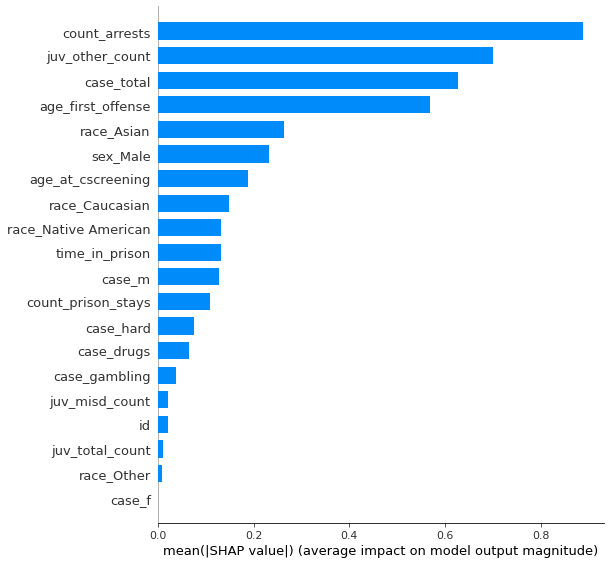

In [ ]:
# SHAP Global explanation
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=X.columns)

On a global level and global importance of the Elastic net, the features with large Shapley values are age at the first offense, the amount of time the defendand stayed in prison before and the amount of times the defendant got arrested before the charge.

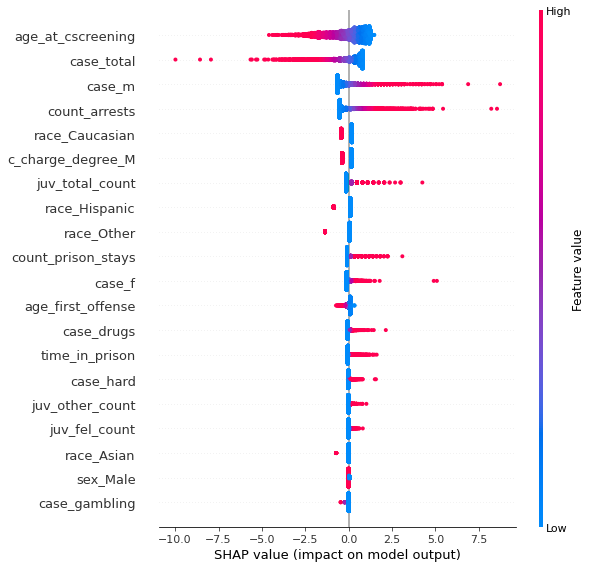

In [ ]:
# Summary plot
shap.summary_plot(shap_values, X_train)

As visualized in the summary plot, the age at custody screeing, the total amount of prior cases and arrests as well as the amount of misdemeanor charges lead to a higher compas score.

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


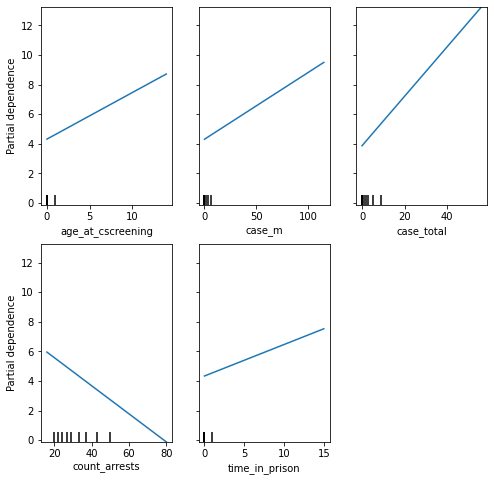

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_partial_dependence(model_en, X_train, feature_names=X.columns, features = ['age_at_cscreening', 'case_m', 'case_total', 'count_arrests', 'time_in_prison'], ax=ax)

The partial dependency between the target variable and the plotted features is linear. As visualized in the graphs above - the features "age_at_screening", "case_m", "case_total" and "time_in_prison" are positive dependent to the decile score. Which means, when the value increases for this feature, the decile score increases. The "case_total" feature increases the most extreme, as it has the highest slope.
Whilst "count_arrest" is also dependent to the decile score, the extemer the value gets, the less depentent to the score (probalby becaues of the large confidence intervalls, as there are not that many count arrests which are that high)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


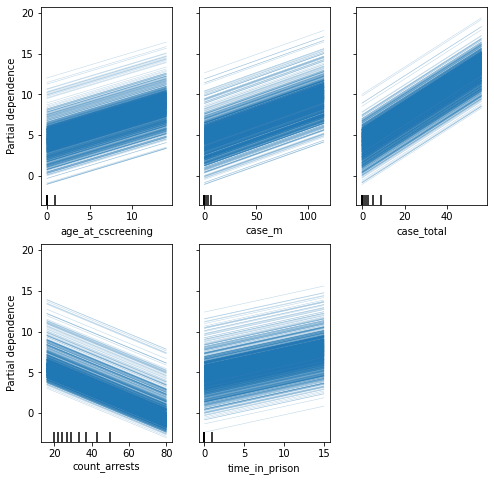

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_partial_dependence(model_en, X_train, feature_names=X.columns, features = ['age_at_cscreening', 'case_m', 'case_total', 'count_arrests', 'time_in_prison'], ax=ax, kind='individual')

Individual Conditional Expectation (ICE) plots visualize one line per instance, the graphs above show how the instance prediction changes when a value of the feature changes. The graphs show a linear dependency again, and we can see that the features vary quite high and the outliers of the features, which makes generalizaion difficult (large spread of the values, as shown in the boxplots already)


### 6.1.4 Model Interpretation (Local)

In [ ]:
train_id

5174    7891
4227    6451
1724    2618
2486    3785
232      344
        ... 
4416    6737
6066    9253
6105    9306
6298    9613
1006    1545
Name: id, Length: 4318, dtype: int64

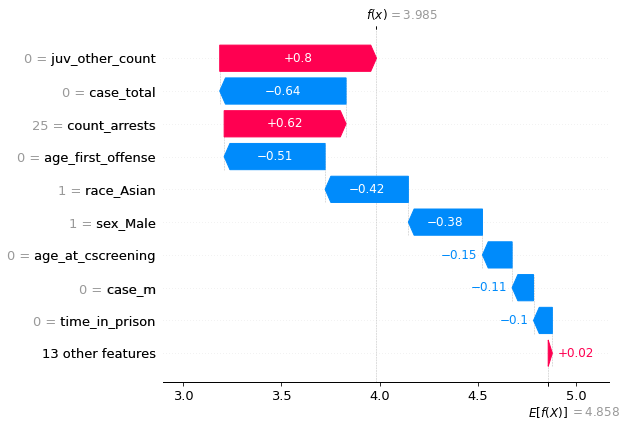

In [ ]:
local_case = X_train[train_id.isin([232])]
decile_score_en = y_train[train_id.isin([232])]
cases = model_en.predict(local_case)
shap_values = explainer(local_case)
shap.plots.waterfall(shap.Explanation(values = shap_values[0], feature_names=X.columns))

A score of 4 is surprisingly low for that many prior arrests. As aspected, the 25 count arrests are accountable for a higher score. On the other hand, being Asian and Male and having no prior cases is reducing the score. Also was not expected that age does not play a major role for this prediction, as it is quite important in the global level.

### 6.1.5 Comparison

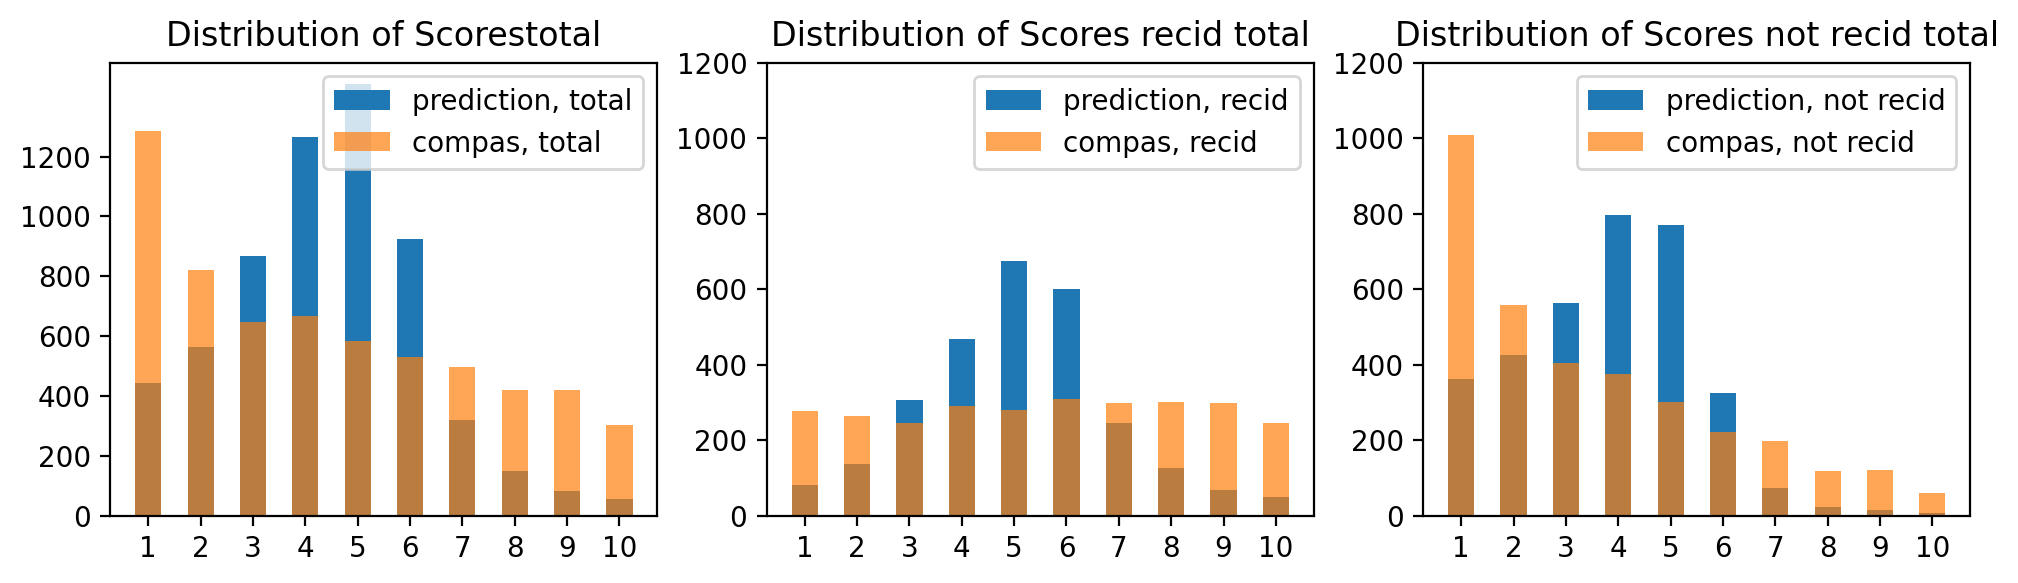

In [ ]:
df_comparison_en =  get_comparison_df(model_en)
plot_comparison(df_comparison_en, False, np.arange(0,1300,200))

Comparing the actual compas scores with the predictions of the Elastic Net.

The first graph shows the total distribution of the scores, the second and third graph are showing the distribution of the scores for defendants being recid and being not recid.

The blue color displays what our model predicted, orange what the compas score acutally is and the brown part of the pillar means that blue and orange are overlaping (prediction and compas score, the part the model predicted correct). If the pillar continues in orange, than the predicion was too low, if the pillar continues in blue than the model too many defendants on this score.

As we can see in the graph below, the elasic net predicts too little extreme values such as 0,1 and 7,8,9,10, and predicts too many defendants between the scores 3-6.

This could be because the distribution of some of the numerical values were very spread out, some of the values did not even have and Interquarantile range, which means the values are very spread out with large confidence intervals e.g.: count_arrests, case_m, case_f, juv_total_count which made it difficult for the elastic net to generalize over the data.

This is also confirmed when compareing the train and test scores of the model, as the train set preformes  better than the test set, which means the model is slighlty overfitting. 


In [ ]:
# confusion matrix preparation (Score is bigger than 5 = recid)
df_comparison_en['compas_recid'] = 0
df_comparison_en['prediction_recid'] = 0

df_comparison_en['compas_recid'] = np.where((df_comparison_en.y_true > 5),1,df_comparison_en.compas_recid)
df_comparison_en['prediction_recid'] = np.where((df_comparison_en.y_pred_binned > 5),1,df_comparison_en.prediction_recid)

0.6642891878748581


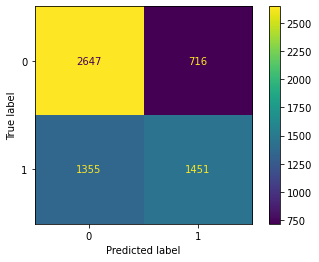

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_comparison_en['two_year_recid'],df_comparison_en['compas_recid'])).plot()
print(accuracy_score(df_comparison_en['two_year_recid'],df_comparison_en['compas_recid']))

0.6581293564597179


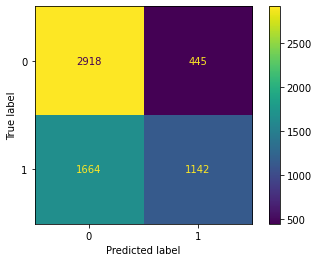

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(df_comparison_en['two_year_recid'],df_comparison_en['prediction_recid'])).plot()
print(accuracy_score(df_comparison_en['two_year_recid'],df_comparison_en['prediction_recid']))

Above we compare the confusion matrix of the actual Compas scores compared to the predicted scores of the Elastic Net, where we assume, of the score is bigger than 5, the defendant is classified as recid.

As we can see, even though the labels vary, the accuracy of recid/not recid is very similar.

## 6.2 Linear Regression

### 6.2.1 Model Building

In [ ]:
# Import needed libraries
from sklearn.linear_model import LinearRegression

In [ ]:
# remove outliers 
Q1 = df_lin.quantile(0.005) 
Q3 = df_lin.quantile(0.995) 
IQR = Q3 - Q1

df_lin = df_lin[~((df_lin < (Q1 - 1.5 * IQR)) |(df_lin > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
#Select features for Linear Regression

variables = ['id','decile_score','case_total','case_m',
                     'case_f','case_gambling','case_hard','case_drugs','time_in_prison','count_prison_stays','age_first_offense','count_arrests',
                     'age_at_cscreening','sex_Male','c_charge_degree_M','race_Asian','race_Caucasian','race_Hispanic','race_Native American','race_Other']

df_reg = df_lin[variables]

In [ ]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 0 to 7213
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    6090 non-null   int64  
 1   decile_score          6090 non-null   int64  
 2   case_total            6090 non-null   float64
 3   case_m                6090 non-null   float64
 4   case_f                6090 non-null   float64
 5   case_gambling         6090 non-null   float64
 6   case_hard             6090 non-null   float64
 7   case_drugs            6090 non-null   float64
 8   time_in_prison        6090 non-null   float64
 9   count_prison_stays    6090 non-null   float64
 10  age_first_offense     6090 non-null   float64
 11  count_arrests         6090 non-null   float64
 12  age_at_cscreening     6090 non-null   int64  
 13  sex_Male              6090 non-null   uint8  
 14  c_charge_degree_M     6090 non-null   uint8  
 15  race_Asian           

There are 19 features with 6090 non-null entries each. The model will be trained on some of the strongest features to predict the target value: decile_score

In [ ]:
#plot correlation matrix
corr = df_reg.corr()
corr.style.background_gradient(cmap='coolwarm')

All-NaN slice encountered
All-NaN slice encountered


The first column shows the correlation of the 19 features compare to the target value: decile_score. Below are the features with:
*   positive correlations: two_year_recid,	case_total, case_m,	case_f,	case_hard,	case_drugs,	time_in_prison,	count_prison_stays, count_arrests (strongest with coefficience of 0.42)
*  negative correlations: age_first_offense (strongest with coefficience of -0.52), age_at_cscreening,	sex_Male,	c_charge_degree_M,	race_Caucasian,	race_Hispanic,	race_Other
* no correlations: case_gambling, race_Asian, 	race_Native American




In [ ]:
#Select X and y to train the model
X = df_reg.drop("decile_score", axis=1)
y = df_reg["decile_score"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
X_train,X_test,y_train,y_test,train_id,test_id = id_split(X,y)

In [ ]:
# Standardization
feature_names = X_train.columns
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = pd.DataFrame(X_train,columns=feature_names)
# Create and fit linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Make prediction
y_pred = reg.predict(X_test)
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(reg.score(X_test, y_test)))

Accuracy of linear regression classifier on test set: 0.45


X does not have valid feature names, but LinearRegression was fitted with feature names
X does not have valid feature names, but LinearRegression was fitted with feature names


In [ ]:
# Import Sequential Feature Selector
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
#Select top 10 feature which would best predict the Compas Score
sfs = SequentialFeatureSelector(reg, n_features_to_select=10)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=10)

In [ ]:
# Get a mask of the features selected.
sfs.get_support()

array([ True,  True, False, False, False, False, False,  True,  True,
        True,  True, False,  True, False,  True,  True, False,  True])

two_year_recid,	case_total,	case_m,	count_prison_stays,	age_first_offense,	count_arrests,	age_at_cscreening, c_charge_degree_M,	race_Caucasian, and race_Other are the most important features for Linear Regression model. They were selected using Sequential Feature Selector.	

In [ ]:
# Narrow down the dataframe into the selected features
sfs.transform(X_train)

array([[-0.40876321, -0.61011097, -0.25308101, ...,  1.3870358 ,
        -0.31192515, -0.23990406],
       [-0.7433075 , -0.61011097, -0.25308101, ...,  1.3870358 ,
        -0.31192515, -0.23990406],
       [-0.15785499, -0.61011097, -0.25308101, ..., -0.72096192,
        -0.31192515,  4.168333  ],
       ...,
       [ 3.43849612,  1.65844817, -0.25308101, ..., -0.72096192,
        -0.31192515, -0.23990406],
       [-0.7433075 , -0.61011097, -0.25308101, ...,  1.3870358 ,
        -0.31192515, -0.23990406],
       [-0.7433075 , -0.61011097, -0.25308101, ..., -0.72096192,
         3.20589734, -0.23990406]])

In [ ]:
positive = [True, False]
parameters = {
                 'positive': positive,
                 'fit_intercept':[True, False], 
                  'copy_X':[True, False],
             }

clf = GridSearchCV(reg, parameters)
clf.fit(X_train, y_train)
pipe = Pipeline(steps=[("sc", sc),("clf", clf)])

#View best params
# print("Linear Regression", clf.best_estimator_.get_params())

CV_Result = cross_val_score(pipe, X_train, y_train, n_jobs=-1, scoring = "r2")

print(CV_Result)
print(CV_Result.mean())
print(CV_Result.std())
print("r2 / variance : ", clf.best_score_)
print("Residual sum of squares: %.2f"
              % np.mean((clf.predict(X_test) - y_test) ** 2))

[0.44653323 0.50066135 0.45505992 0.46178236 0.46876916]
0.4665612027371986
0.018568421195048403
r2 / variance :  0.4665612027371987
Residual sum of squares: 4.48


X does not have valid feature names, but LinearRegression was fitted with feature names


### 6.2.2 Model Performance

In [ ]:
print("Train-R2-Score: ", str(reg.score(X_train,y_train)))
print("Test-R2-Score: ", str(reg.score(X_test,y_test)))

Train-R2-Score:  0.4729271587280036
Test-R2-Score:  0.4461198924702877


X does not have valid feature names, but LinearRegression was fitted with feature names


In [ ]:
# mean square error
mse = mean_squared_error(y_test, y_pred)
print("%.2f"% mse)

4.48


In [ ]:
# Precision
print(r2_score(y_test, y_pred))


#The max_error metric calculates the maximum residual error.
print(max_error(y_test, y_pred))

0.4461198924702877
7.386627384809861


In [ ]:
print(mean_absolute_error(y_test, y_pred))

1.7064752055262262


In [ ]:
print(median_absolute_error(y_test, y_pred))

1.4813310459461482


In [ ]:
print(mean_absolute_percentage_error(y_test, y_pred))

0.6118643700787963


Note here that the output is not a percentage in the range [0, 100] and a value of 
100 does not mean 100% but 1e2. Furthermore, the output can be arbitrarily high when 
y_true is small (which is specific to the metric) or when abs(y_true - y_pred) is large (which is common for most regression metrics).


In [ ]:
# Cross validate score
cv_scores = cross_val_score(reg, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores:', cv_scores)
print(np.mean(cv_scores))

Cross-Validation Accuracy Scores: [0.43941949 0.44508318 0.53424476 0.46797491 0.45435539 0.45013653
 0.45724453 0.46785724 0.48158283 0.46090967]
0.46588085346572344


### 6.2.3 Model Interpretation (Global)

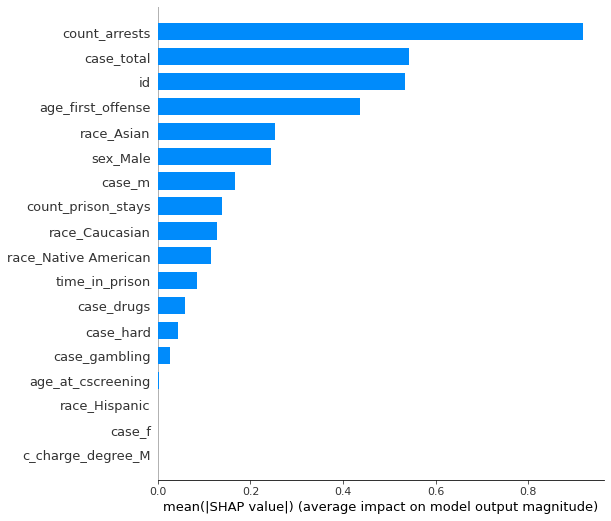

In [ ]:
# Global explanation
explainer = shap.LinearExplainer(reg, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=X.columns)

As we can see in the figure above, the two most important features for the Linear Regression are "count_arrests" and "case_total" with a relatively high lead towards other features. We can also identify that the categorical features "race_Asian" and "sex_Male" have an impact on the models decision making. 

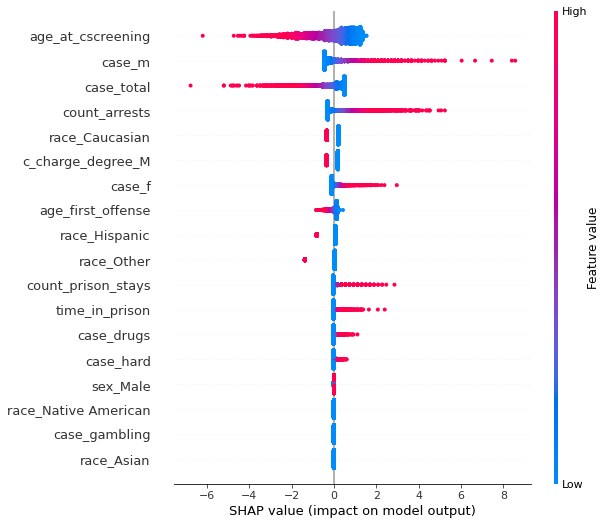

In [ ]:
#Local explanation
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

As visualized in the summary plot, the age at custody screeing, amount of misdemeanor charges the as well as total amount of prior cases and arrests the lead to a higher compas score.

### 6.2.4 Model Interpretation (Local)

In [ ]:
train_id

4682     7154
6984    10636
822      1242
6567    10018
2113     3229
        ...  
4465     6812
6147     9370
6187     9436
6378     9734
1018     1562
Name: id, Length: 4263, dtype: int64

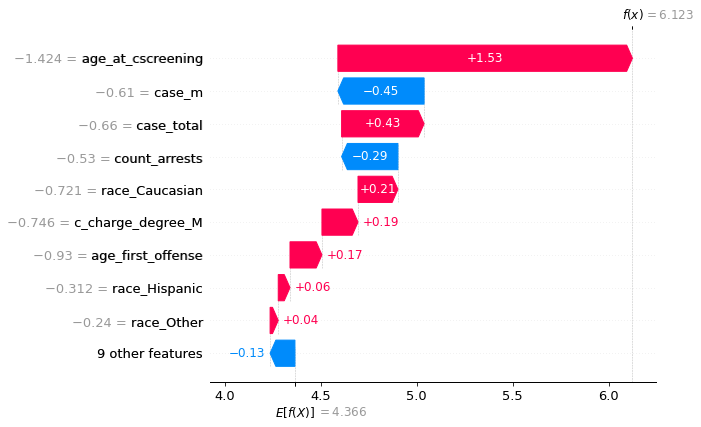

In [ ]:
local_case = X_train[X_train.age_at_cscreening == X_train.age_at_cscreening.min()]
cases = reg.predict(local_case)
shap_values = explainer(local_case)
shap.plots.waterfall(shap.Explanation(values = shap_values[0], feature_names=feature_names))

This is an example of a local model explanation, where we visualize on particular defendant with lowest age at compas screening. We can see that by starting at the bottom, the predicted compas score is 6. However, the different features, such as the count of misdemeanor cases and arrests counteract against the other features. It becomes apparent, that the expected value does not differ too much from the actual value.

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


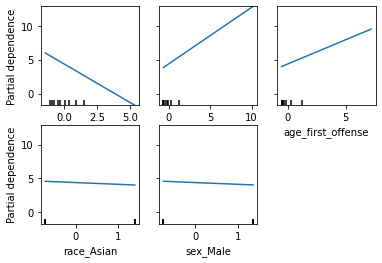

In [ ]:
# Linear Regression of each individual feature
plot_partial_dependence(reg, X_train, feature_names=X.columns, features = ['count_arrests', 'case_total', 'age_first_offense', 'race_Asian','sex_Male'])

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


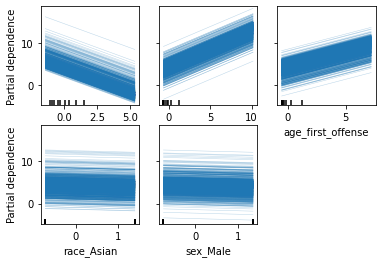

In [ ]:
plot_partial_dependence(reg, X_train, feature_names=X.columns, features = ['count_arrests', 'case_total', 'age_first_offense', 'race_Asian','sex_Male'], kind='individual')

The individual conditional expectation (ICE) plots display how the prediction of the COMPAS score changes when 5 features changes. Each line represents one defendant.
For most defendants, there is a decrease in the COMPAS score when the defendant has lower numbers of arrests, is not Asian and is Female. On the contrary, there is an increase in the COMPAS score for more total cases and higher age at first offense.

### 6.2.5 Comparison

We take a look at the predicted distribution of scores in comparison to the real compas-scores of prediction with Linear Regression.

In [ ]:
df_comparison = get_comparison_df(clf)

X does not have valid feature names, but LinearRegression was fitted with feature names


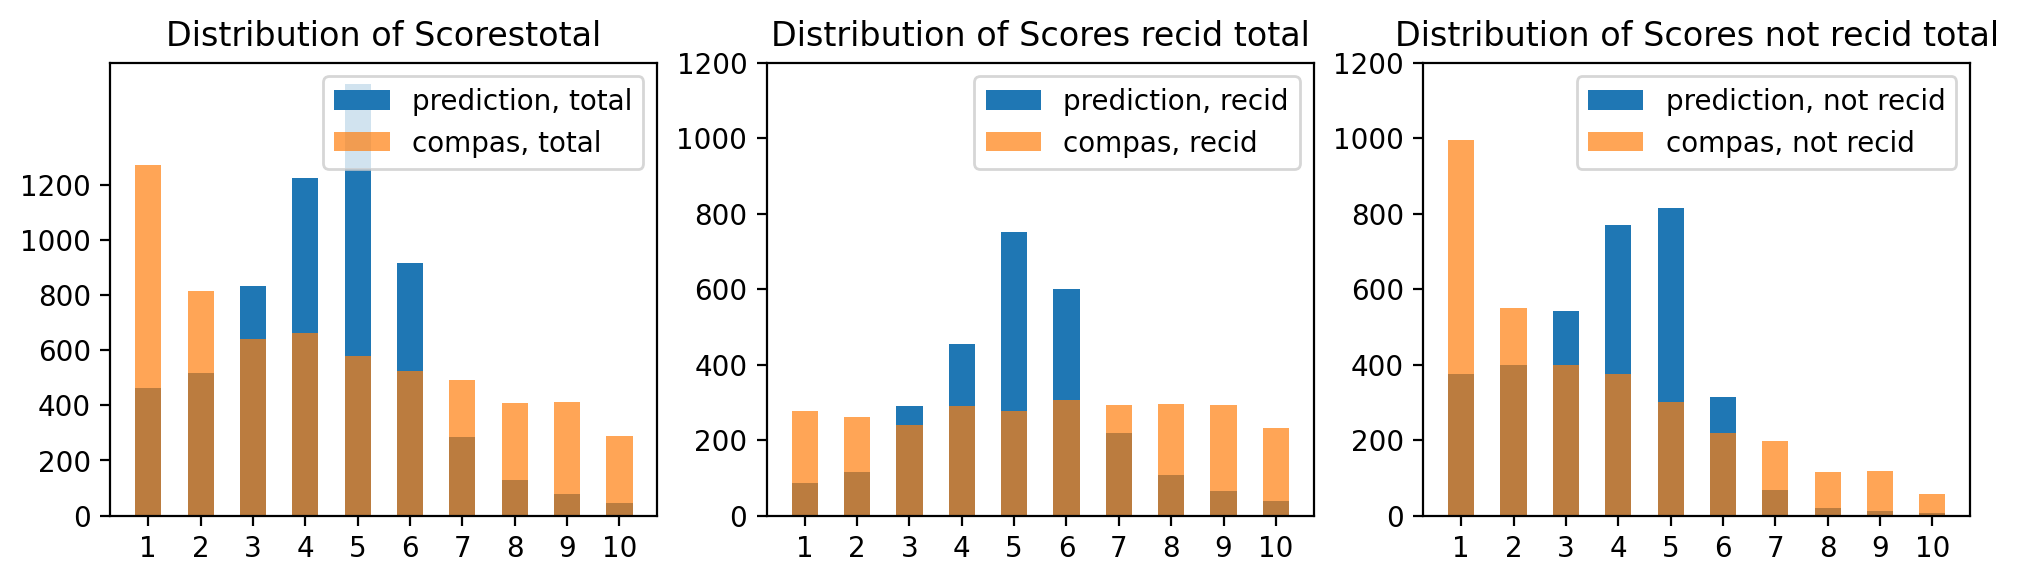

In [ ]:
plot_comparison(df_comparison,False,np.arange(0,1300,200))

As we can see the first plot our predictions center around 4 and 5, having far more cases on the all scores in comparison to compas.

In the second and third plot we can see that he the distribution of recidivists centers around 5 and 6, while the non recidivistscenter around 1, 4 and 5. In comparison the compas score also centers in 5-6 for recedevists but is more evenly distributed along the scores. For the non recedevists the compas score shows a exponential decay.

In [ ]:
# confusion matrix preparation (Score is bigger than 5 = recid)
df_comparison['compas_recid'] = 0
df_comparison['prediction_recid'] = 0

df_comparison['compas_recid'] = np.where((df_comparison.y_true > 5),1,df_comparison.compas_recid)
df_comparison['prediction_recid'] = np.where((df_comparison.y_pred_binned > 5),1,df_comparison.prediction_recid)

0.6630541871921182


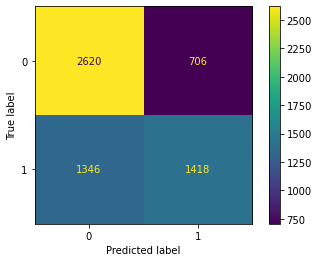

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_comparison['two_year_recid'],df_comparison['compas_recid'])).plot()
print(accuracy_score(df_comparison['two_year_recid'],df_comparison['compas_recid']))

0.6518883415435139


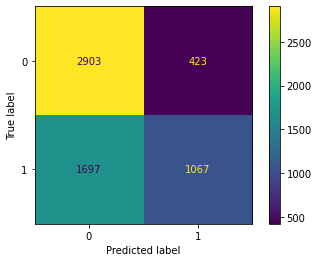

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(df_comparison['two_year_recid'],df_comparison['prediction_recid'])).plot()
print(accuracy_score(df_comparison['two_year_recid'],df_comparison['prediction_recid']))

Even though the scores are different, the accuracy stays about the same with the Linear Regression-model having more false-negatives and more false-positives

## 6.3 KNN Regressor

K-nearest-neighbors has not been designed for regression, however, the algorithm can still be used for it. For classificaton the algorithm takes the most frequent class among the k nearestneighbors. For Regression taks the value is interpolated from the values of k nearest neighbors. Instead of choosing the most frequent class, a (weighted) average is usually calculated from the regression values ("labels") of the k nearest neighbors.

### 6.3.1 Model Building

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
#Data frame for KNNRegressor: df_knn_reg
df_knn_reg = df_lin
df_knn_reg = df_knn_reg.drop(columns=["two_year_recid"]).dropna(axis=1, how="any")

#KNN is sensitive to outliers. For a better model generalization, drop extreme outlier which were detected on the boxplots
df_knn_reg.drop(df_knn_reg[df_knn_reg.case_m == 169].index, inplace=True)
df_knn_reg.drop(df_knn_reg[df_knn_reg.age_at_cscreening == 95].index, inplace=True)
df_knn_reg.drop(df_knn_reg[df_knn_reg.juv_total_count == 20].index, inplace=True)
df_knn_reg.drop(df_knn_reg[df_knn_reg.juv_fel_count == 20].index, inplace=True)

# X is initalized with the features (independent variables), y with the labels (dependent variables)
X = df_knn_reg.drop("decile_score", axis=1)
y = df_knn_reg["decile_score"]

# Splitting the Date Frame into train / test set
X_train, X_test, y_train, y_test, train_id,test_id = id_split(X, y)
X = df_knn_reg.drop("id", axis=1)

In [ ]:
#Building a pipeline and conduction GridSearchCV to get the best parameters for the model

#steps = [("scaler", StandardScaler()),
#         ("neigh", KNeighborsRegressor())]

#pipeline = Pipeline(steps)

#parameters for KNN
#parameters = {"neigh__n_neighbors": range(1, 100),
#              "neigh__weights": ["uniform", "distance"],
#              "neigh__metric" : ["manhattan", "euclidean"]}

#neigh_clf = GridSearchCV(pipeline, parameters)
#neigh_clf.fit(X_train, y_train)

#View best params
#print("KNeighborsRegressor", neigh_clf.best_params_)

#Building a pipeline and conduction GridSearchCV to get the best parameters for the model

#steps = [("scaler", StandardScaler()),
#         ("neigh", KNeighborsRegressor())]

#pipeline = Pipeline(steps)

#parameters for KNN
#parameters = {"neigh__n_neighbors": range(1, 100),
#              "neigh__weights": ["uniform", "distance"],

#KNeighborsRegressor {'neigh__metric': 'manhattan', 'neigh__n_neighbors': 19, 'neigh__weights': 'uniform'}

The best hyperparameter for the KNNRegressor are: 

**metric: "manhattan"**

Distance formular "manhattan"

**n_neighbors: 19**

Number of neighbors to use 

**weights: "uniform"**

uniform : uniform weights. The points in each neighborhood are weighted equally.

distance : weights points by the inverse of their distance. Closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [ ]:
#Enter the best parameters into the KNeighborsRegressor 
model_neigh_clf = KNeighborsRegressor(metric= "manhattan", n_neighbors= 19, weights= "uniform")
model_neigh_clf.fit(X_train, y_train)

#conduct cross validation
pred_neigh = cross_val_score(model_neigh_clf, X, y, cv=10)
print(np.mean(pred_neigh))

0.8511883006965872


### 6.3.2 Model Performance

In [ ]:
y_pred = model_neigh_clf.predict(X_test)
print("Train-R2-Score: ", str(model_neigh_clf.score(X_train,y_train)))
print("Test-R2-Score: ", str(model_neigh_clf.score(X_test,y_test)))
print("Mean squared error:",str(mean_squared_error(y_test,y_pred)))
print("Mean absolute percentage error:",str(mean_absolute_percentage_error(y_test,y_pred)))
print("Mean absolute error:",str(mean_absolute_error(y_test,y_pred)))
print("Median absolute error:",str(median_absolute_error(y_test,y_pred)))

Train-R2-Score:  0.5737909447802656
Test-R2-Score:  0.5150724142376556
Mean squared error: 3.834863929333315
Mean absolute percentage error: 0.5222243485012477
Mean absolute error: 1.5346700083542189
Median absolute error: 1.210526315789474


Explaining the prediction with the K-nearest neighbors regressor cannot be performed with SHAP values or partial dependence plots as there is no definition for feature importances in case of K-nearest neighbor regressor.


### 6.3.3 Comparison

Comparing the actual compas scores with the predictions of the KNN Regressor.

As we can see in the graph below, the KNN Regressor predicts too few extreme values such as 0 and almost no defendants for 9 and 10. Instead it predicts too many defendants between the scores 2-7.

The reasoning for this is probably similar as the reason for the distribution in the Elastic Net model - the distribution of some of the numerical values were very spread out (large confidence intervals) e.g.: count_arrests, case_m, case_f, juv_total_count which made it difficult for the elastic net to generalize over the data.

This is also confirmed when comparing the train and test scores of the model, as the train set performs better than the test set, which means the model is slighlty overfitted.

We can see, that the KNN Regessor performs better with predicting the extreme outliers (0,1) than the Elastic Net. 

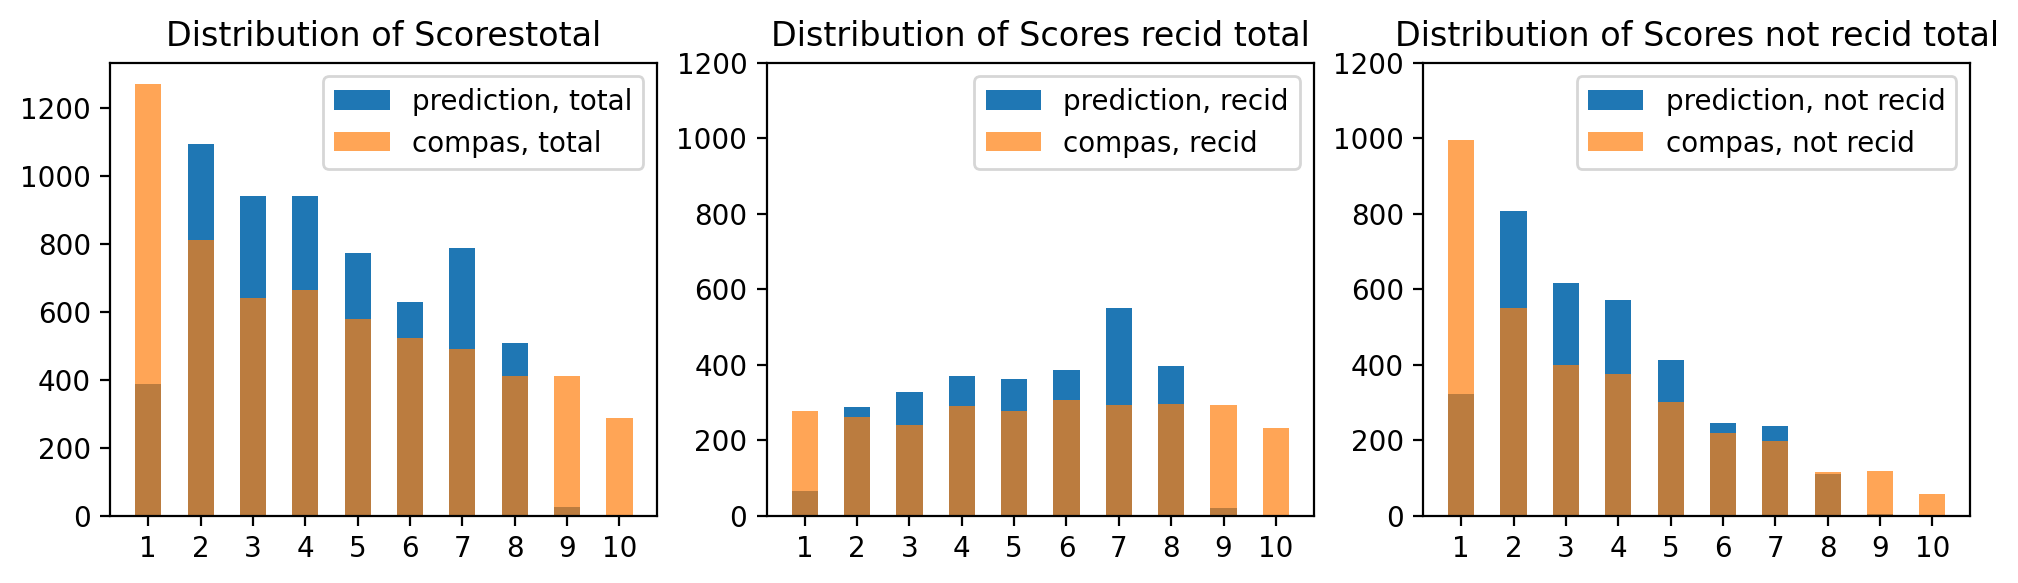

In [ ]:
df_comparison_knnreg =  get_comparison_df(model_neigh_clf)
plot_comparison(df_comparison_knnreg, False, np.arange(0,1300,200))

Below we compare the confusion matrix of the actual Compas scores compared to the predicted scores of the KNN Regressor, where we assume, of the score is bigger than 5, the defendant is classified as recid.

As we can see, even though the labels vary, the accuracy of recid/not recid is almost the same.

In [ ]:
# confusion matrix preparation (Score is bigger than 5 = recid)
df_comparison_knnreg['compas_recid'] = 0
df_comparison_knnreg['prediction_recid'] = 0

df_comparison_knnreg['compas_recid'] = np.where((df_comparison_knnreg.y_true > 5),1,df_comparison_knnreg.compas_recid)
df_comparison_knnreg['prediction_recid'] = np.where((df_comparison_knnreg.y_pred_binned > 5),1,df_comparison_knnreg.prediction_recid)

0.6631630809656758


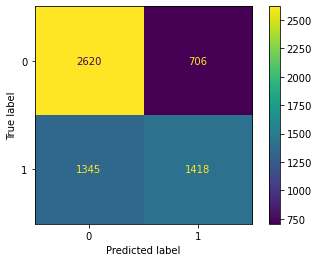

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_comparison_knnreg['two_year_recid'],df_comparison_knnreg['compas_recid'])).plot()
print(accuracy_score(df_comparison_knnreg['two_year_recid'],df_comparison_knnreg['compas_recid']))

0.6698965347347676


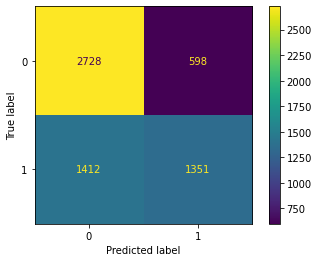

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(df_comparison_knnreg['two_year_recid'],df_comparison_knnreg['prediction_recid'])).plot()
print(accuracy_score(df_comparison_knnreg['two_year_recid'],df_comparison_knnreg['prediction_recid']))

## 6.4 Random Forest

### 6.4.1 Model Building

In [ ]:
# dropping parameters that would be unknown (two_year_recid)
df_compas_forest = df_tree
df_compas_forest = df_compas_forest.drop(columns=["two_year_recid"]).dropna(axis=1, how="any")

In [ ]:
# import Forest Regressor and stuff
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Train Test Split
y=df_compas_forest['decile_score']
X=df_compas_forest.drop('decile_score',axis=1)
X_train,X_test,y_train,y_test,train_id,test_id = id_split(X,y)

In [ ]:
# Define variables
count_trees = np.arange(1,51,1)
max_depth = np.arange(1,21,1)
min_samples_leaf = [5,10,15,20]
cv=5
param_grid = {
                 'n_estimators': [44],
                 'max_depth': [12],
                 'max_features': ['auto'],
                 'min_samples_leaf':[5],
                 'bootstrap':[True]
             }
# testing grid
#param_grid = {
#                 'n_estimators': count_trees,
#                 'max_depth': max_depth,
#                 'max_features': ['auto', 'sqrt', 'log2'],
#                 'min_samples_leaf':min_samples_leaf,
#                 'bootstrap':[True,False]
#             }

In [ ]:
# Fit model
forest = RandomForestRegressor()
clf = GridSearchCV(forest,param_grid,cv=cv)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'max_depth': [12],
                         'max_features': ['auto'], 'min_samples_leaf': [5],
                         'n_estimators': [44]})

### 6.4.2 Model Performance

In [ ]:
y_pred = clf.predict(X_test)
print("Train-R2-Score: ", str(clf.score(X_train,y_train)))
print("Test-R2-Score: ", str(clf.score(X_test,y_test)))
print("Mean squared error:",str(mean_squared_error(y_test,y_pred)))
print("Mean absolute percentage error:",str(mean_absolute_percentage_error(y_test,y_pred)))
print("Mean absolute error:",str(mean_absolute_error(y_test,y_pred)))
print("Median absolute error:",str(median_absolute_error(y_test,y_pred)))

Train-R2-Score:  0.7231354042246151
Test-R2-Score:  0.56135191790061
Mean squared error: 3.4955131608510626
Mean absolute percentage error: 0.48179572537293097
Mean absolute error: 1.4408977075192795
Median absolute error: 1.1778858778454626


The big difference between unseen data R2-Score and cross validated R2-Score leads us to believe, that the forest is a bit overfitted.

### 6.4.3 Model Interpretation (Global)

In [ ]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_train)

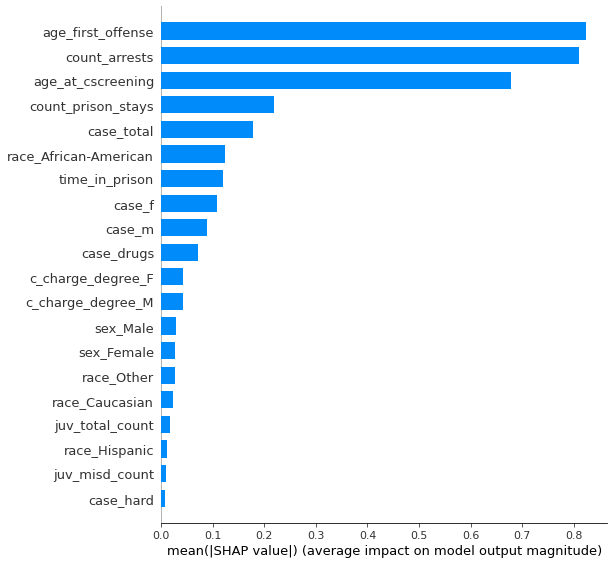

In [ ]:
# SHAP Feature Importance 
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=X_train.columns)

The age at first offense, the count of arrests and the age at cscreening have a much higher effect on the predicted score than other features. Being of African American orgin is also the 6th most important feature. 


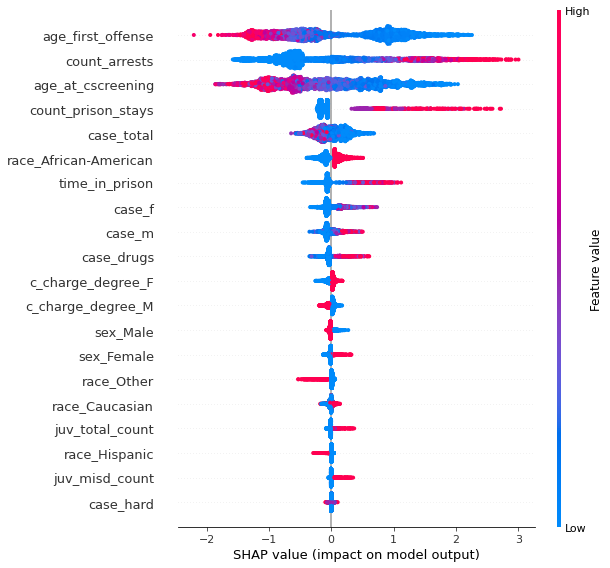

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_train)

As one would expect, the higher the age at the first offense and compas-screening, the lower your score. More arrests expectedly also lead to a higher score. Being African American also hurts your score. Interestingly the more cases one has in total the lower the score is. We think that effect happens because case_total is the sum of case_f and case_m and therefore highly correlated. It is counteracting some effects of those two features. Going forward it might be interesting to look into dropping case_total.

Attempting to set identical bottom == top == 4.409477324990321 results in singular transformations; automatically expanding.


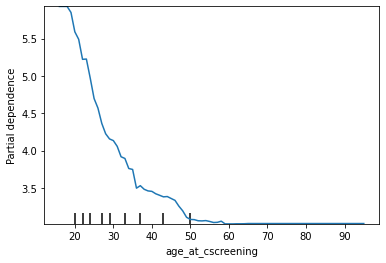

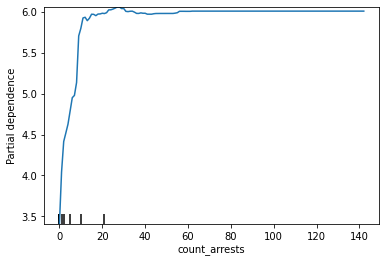

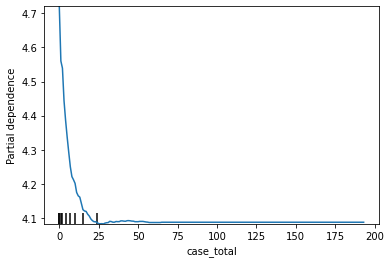

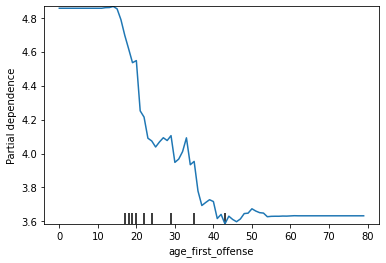

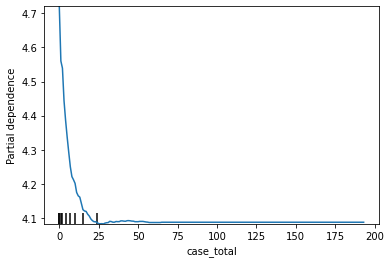

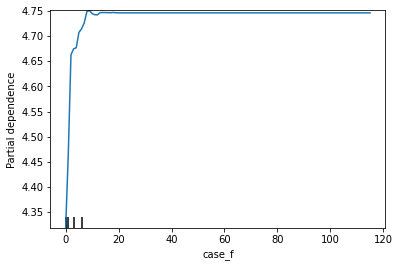

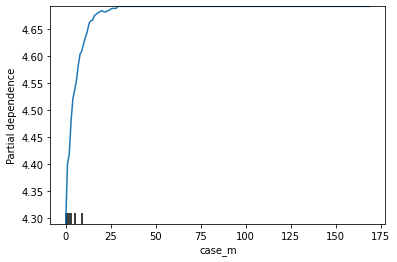

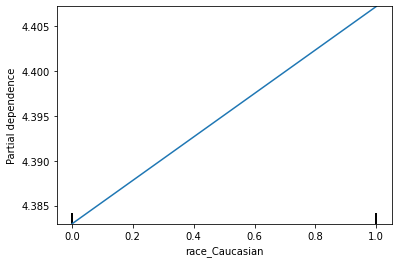

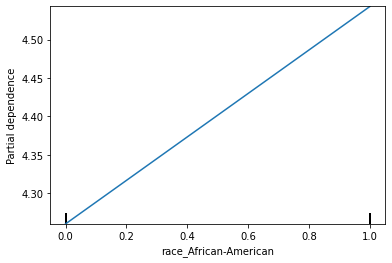

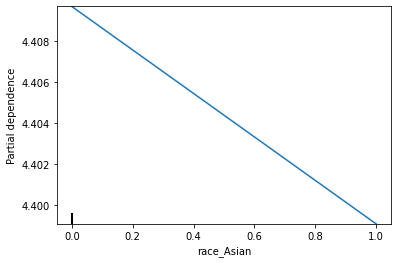

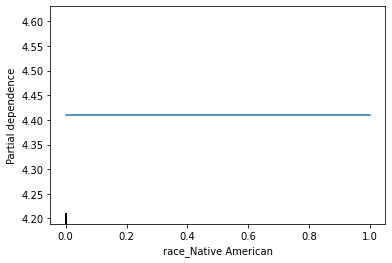

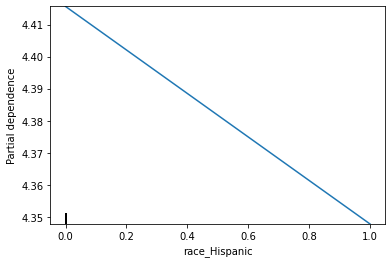

In [ ]:
# Plot PDPs (non-categorical)

features_noncat = [['age_at_cscreening'],['count_arrests'],['case_total'],['age_first_offense'],['case_total'],['case_f'],['case_m'],['race_Caucasian'],['race_African-American'],['race_Asian'],['race_Native American'],["race_Hispanic"]]

for i in range(len(features_noncat)):

  PartialDependenceDisplay.from_estimator(clf, X_train, features=features_noncat[i])

The PDPs of the most important features max out after reaching a certain point. We think this is because of outliers within the data. None of that data is unexpected. The races overall seem to only have small effects, with the Caucasian and African-American increase the predicted score while Asian and Hispanic lower it.

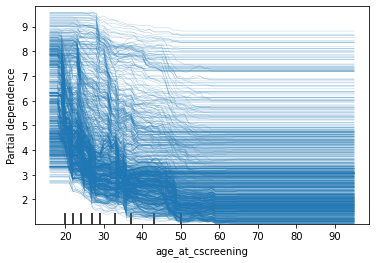

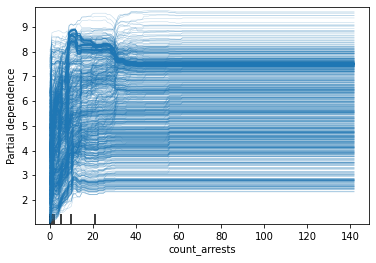

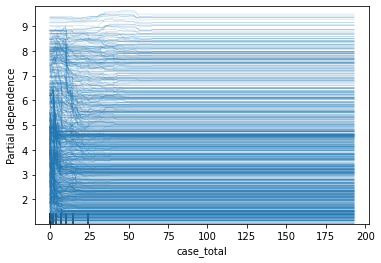

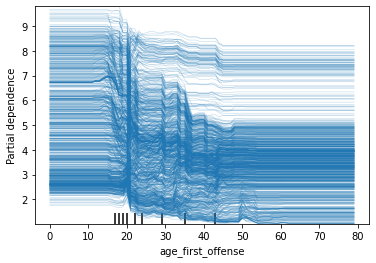

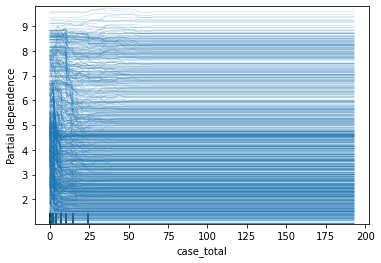

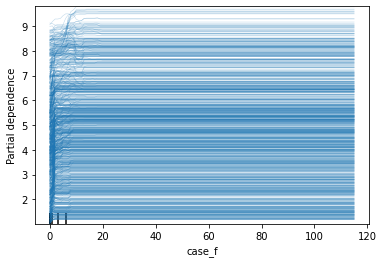

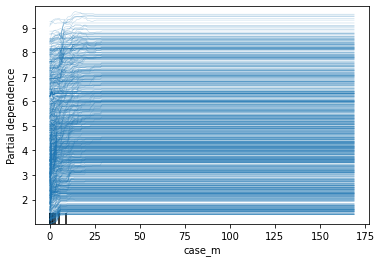

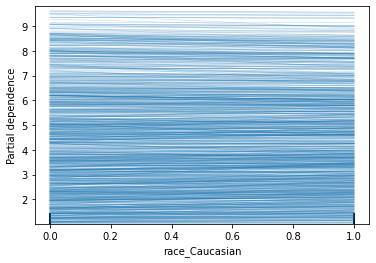

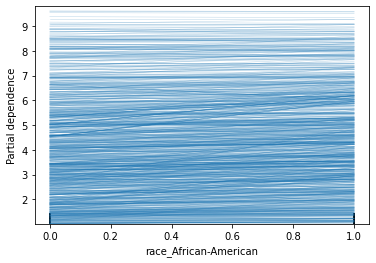

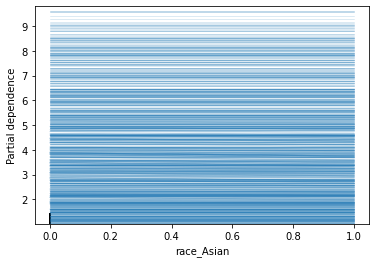

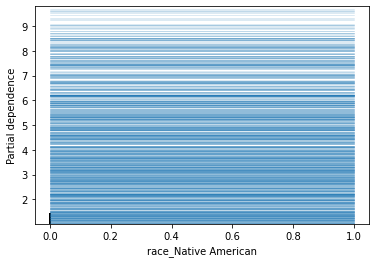

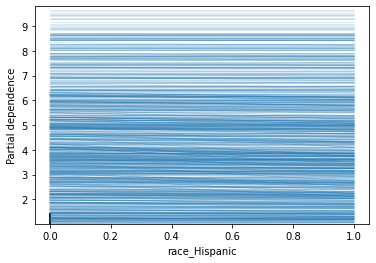

In [ ]:
# Plot ICEs (non-categorical)

for i in range(len(features_noncat)):

 PartialDependenceDisplay.from_estimator(clf, X_train, features=features_noncat[i], kind="individual")

### 6.4.4 Comparison

We take a look at the predicted distribution of scores in comparison to the real COMPAS-scores.

In [ ]:
df_comparison = get_comparison_df(clf)

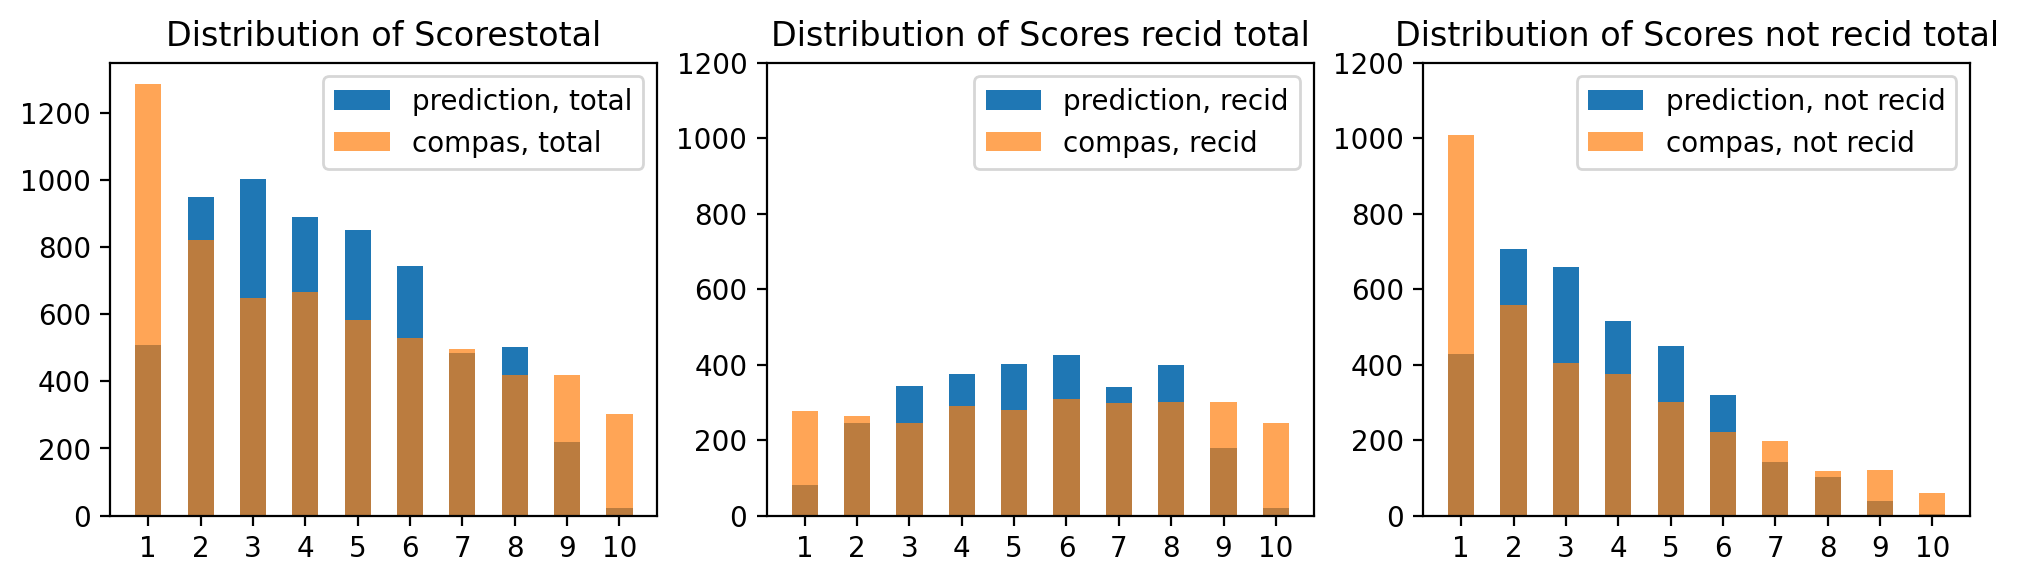

In [ ]:
plot_comparison(df_comparison,False,np.arange(0,1300,200))

The distribution of all scores is similar, with the prediction not going into extremes as much as the COMPAS-Score. The distribution of predictions for recidivist cases looks bell-shaped, centering around 5 and 6. 

In [ ]:
# confusion matrix preparation (Score is bigger than 5 = recid)
df_comparison['compas_recid'] = 0
df_comparison['prediction_recid'] = 0

df_comparison['compas_recid'] = np.where((df_comparison.y_true > 5),1,df_comparison.compas_recid)
df_comparison['prediction_recid'] = np.where((df_comparison.y_pred_binned > 5),1,df_comparison.prediction_recid)

0.6642903434867142


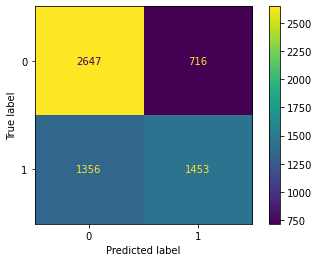

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_comparison['two_year_recid'],df_comparison['compas_recid'])).plot()
print(accuracy_score(df_comparison['two_year_recid'],df_comparison['compas_recid']))

0.6675307841866494


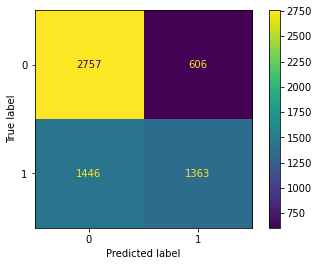

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(df_comparison['two_year_recid'],df_comparison['prediction_recid'])).plot()
print(accuracy_score(df_comparison['two_year_recid'],df_comparison['prediction_recid']))

Even though the scores are different, the accuracy stays about the same when taking 0.5 as a threshhold for recidivism. The predicted score has more False Negatives and less False positives in comparison to compas.

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


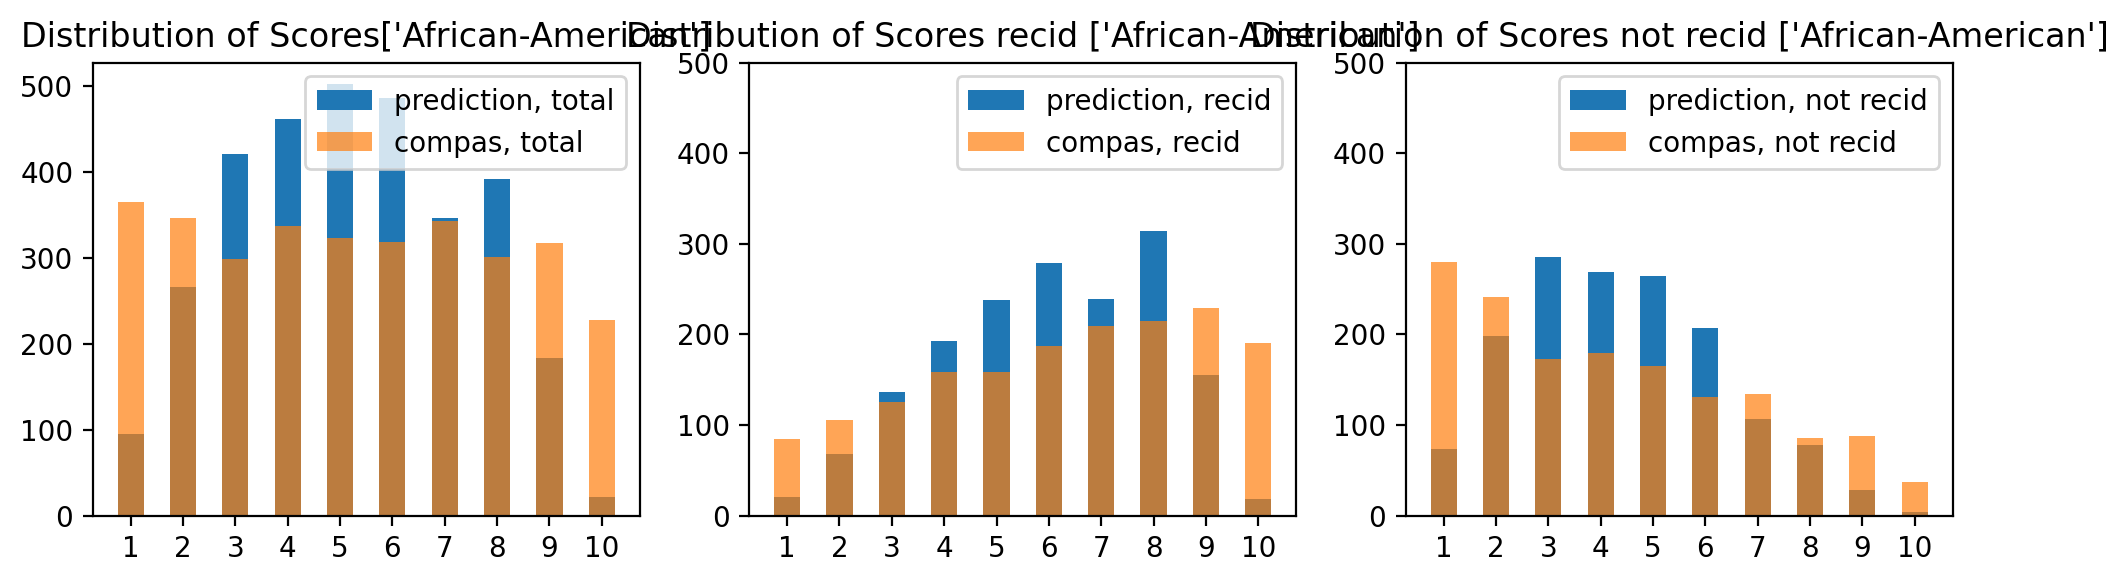

In [ ]:
plot_comparison(df_comparison,['African-American'],np.arange(0,600,100))

As expected, the overall distribution of scores centers on 5, so higher than for the total. This is unsurprising, since African Americans also scored higher on COMPAS. Interestingly, of the ~200 score 9 predictions, most seem to be African Americans.

0.6513385826771654


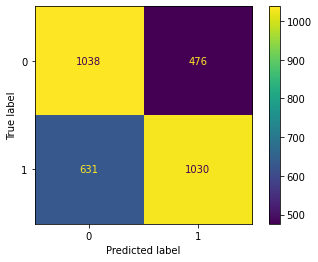

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_comparison[df_comparison['race'] == 'African-American']['two_year_recid'],df_comparison[df_comparison['race'] == 'African-American']['compas_recid'])).plot()
print(accuracy_score(df_comparison[df_comparison['race'] == 'African-American']['two_year_recid'],df_comparison[df_comparison['race'] == 'African-American']['compas_recid']))

0.6598425196850394


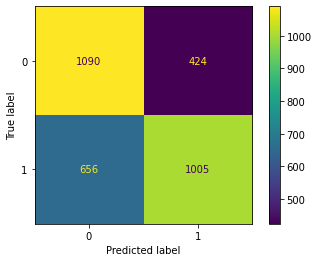

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(df_comparison[df_comparison['race'] == 'African-American']['two_year_recid'],df_comparison[df_comparison['race'] == 'African-American']['prediction_recid'])).plot()
print(accuracy_score(df_comparison[df_comparison['race'] == 'African-American']['two_year_recid'],df_comparison[df_comparison['race'] == 'African-American']['prediction_recid']))

Both models perform slightly worse for African Americans but other observations stay the same.

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


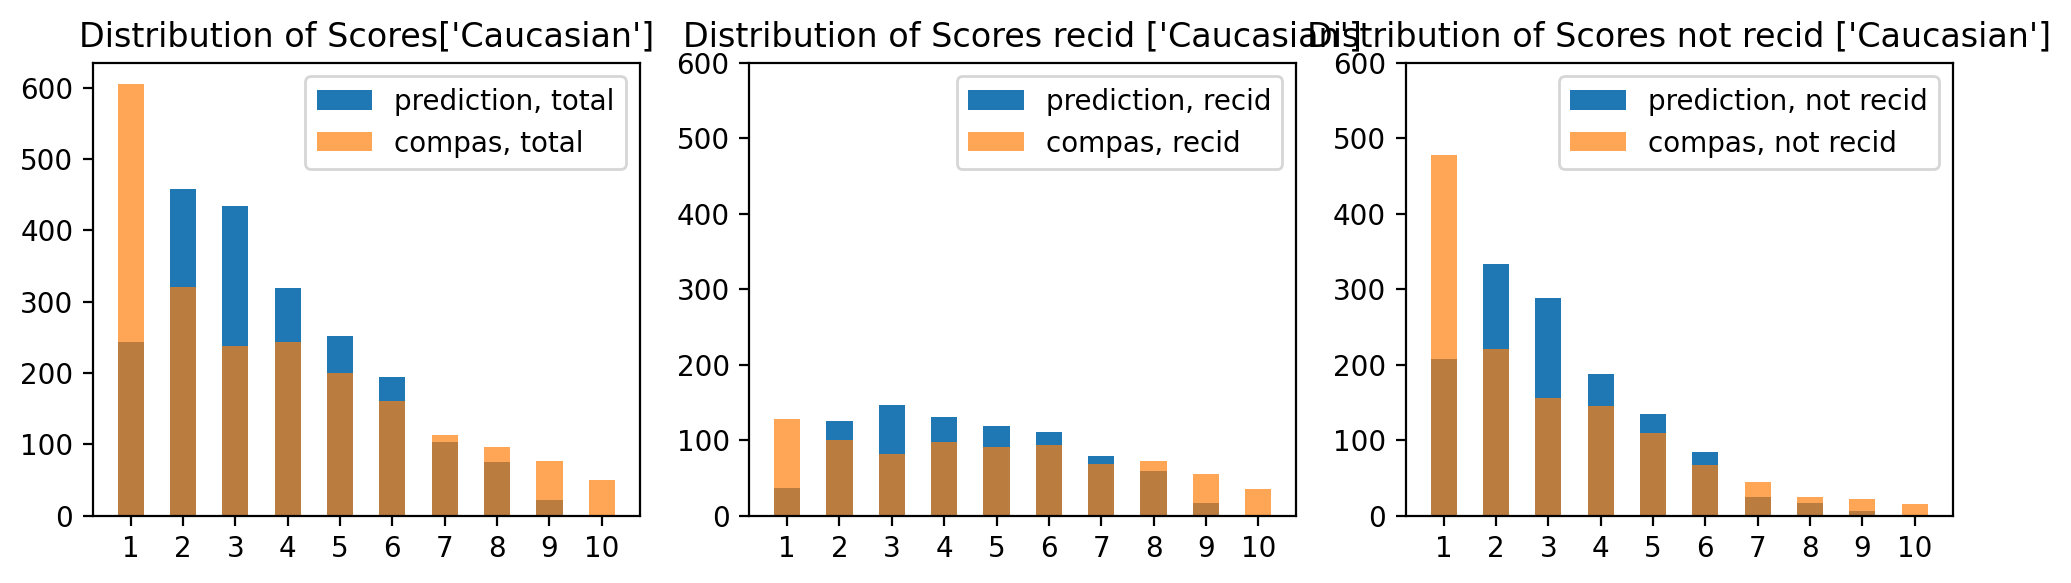

In [ ]:
plot_comparison(df_comparison,['Caucasian'],np.arange(0,700,100))

The distribution for Caucasians is very similar to the distribution of COMPAS-scores.

0.6804564907275321


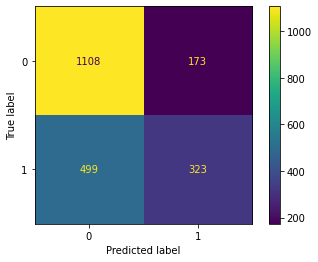

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_comparison[df_comparison['race'] == 'Caucasian']['two_year_recid'],df_comparison[df_comparison['race'] == 'Caucasian']['compas_recid'])).plot()
print(accuracy_score(df_comparison[df_comparison['race'] == 'Caucasian']['two_year_recid'],df_comparison[df_comparison['race'] == 'Caucasian']['compas_recid']))

0.6737993342843557


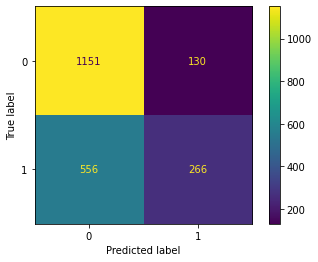

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(df_comparison[df_comparison['race'] == 'Caucasian']['two_year_recid'],df_comparison[df_comparison['race'] == 'Caucasian']['prediction_recid'])).plot()
print(accuracy_score(df_comparison[df_comparison['race'] == 'Caucasian']['two_year_recid'],df_comparison[df_comparison['race'] == 'Caucasian']['prediction_recid']))

The COMPAS prediction accuracy with this threshhold is slightly better than our Random Forest but both models perform better on Caucasians.

## 6.5 XGB Regressor

### 6.5.1 Model Building

In [ ]:
# import model
import xgboost as xgb

In [ ]:
# dropping parameters that are unknown to the model at the time of compas-screening
df_compas_forest = df_tree
df_compas_forest = df_compas_forest.drop(columns=["two_year_recid"]).dropna(axis=1, how="any")

In [ ]:
# Train Test Split while holding onto the id
y=df_compas_forest['decile_score']
X=df_compas_forest.drop('decile_score',axis=1)
X_train,X_test,y_train,y_test,train_id,test_id = id_split(X,y)

In [ ]:
# Define variables - Used for Hyperparameter-Tuning
cv=5
param_grid = {
                'learning_rate': [0.05],
                'n_estimators': [500],
                'colsample_bytree': [0.3],
                'objective': ['reg:squarederror']
             }
#param_grid = {
#                'max_depth': [3,6,10],
#                'learning_rate': [0.05],
#                'n_estimators': [100, 500, 1000],
#                'colsample_bytree': [0.3, 0.2, 0.1],
#                'objective': ['reg:squarederror']
#             }

In [ ]:
# Still using a GridSeachCV for the cross-validation
xgb_reg = xgb.XGBRegressor()
#clf = xgb.XGBRegressor(objective='reg:squarederror')
clf = GridSearchCV(xgb_reg,param_grid,cv=cv)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'colsample_bytree': [0.3], 'learning_rate': [0.05],
                         'n_estimators': [500],
                         'objective': ['reg:squarederror']})

### 6.5.2 Model Performance

In [ ]:
y_pred = clf.predict(X_test)
print("Train-R2-Score: ", str(clf.score(X_train,y_train)))
print("Test-R2-Score: ", str(clf.score(X_test,y_test)))
print("Mean squared error:",str(mean_squared_error(y_test,y_pred)))
print("Mean absolute percentage error:",str(mean_absolute_percentage_error(y_test,y_pred)))
print("Mean absolute error:",str(mean_absolute_error(y_test,y_pred)))
print("Median absolute error:",str(median_absolute_error(y_test,y_pred)))


Train-R2-Score:  0.6432432805067967
Test-R2-Score:  0.5777696370859557
Mean squared error: 3.364683104080109
Mean absolute percentage error: 0.47912659928687434
Mean absolute error: 1.416310383179919
Median absolute error: 1.1550923585891724


The model seems to be slightly overfitted since the crossvalidated training set has a better R2 score than the unseen set. Overall XGBoost still performs better then all other tested models.

### 6.5.3 Model Interpretation (Global)

In [ ]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_train)

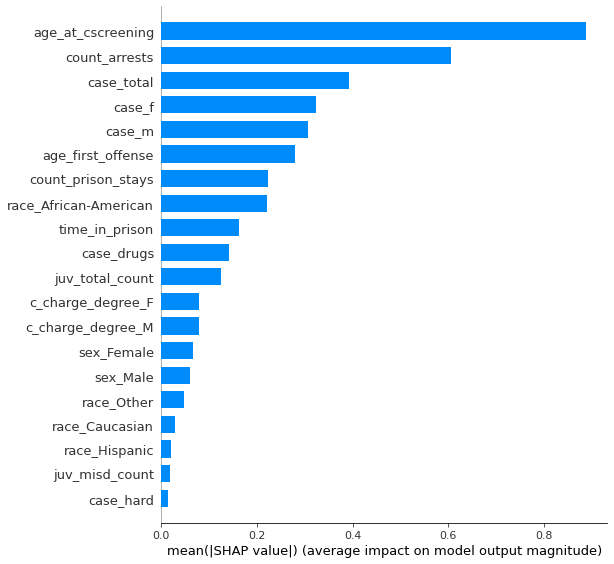

In [ ]:
# SHAP Feature Importance 
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=X_train.columns)

For the XGB-model the most important features according to SHAP are similar to the Random Forest. race_African-American is only on the 8th place.

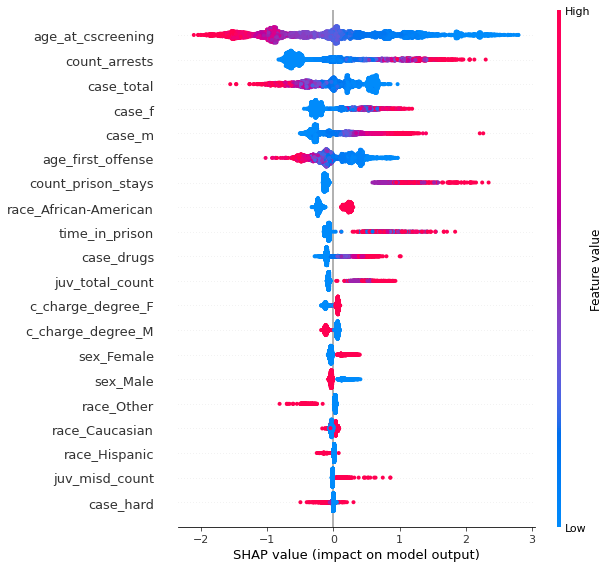

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_train)

The observed effect of case_total couteracting the other case-features can be observed much better in the XGB-model. Interestingly case_hard (count of for example murders and other horrific offences) often lowers the predicted score.

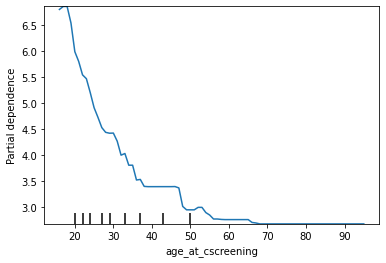

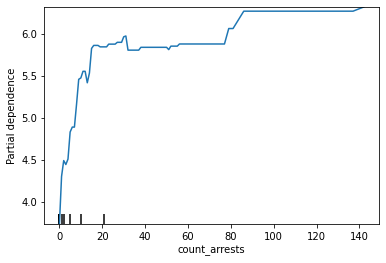

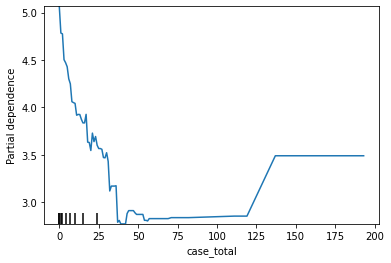

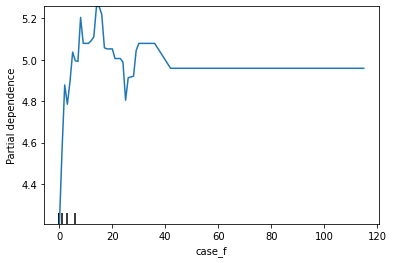

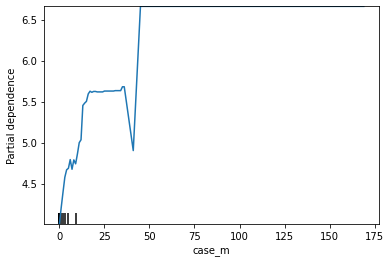

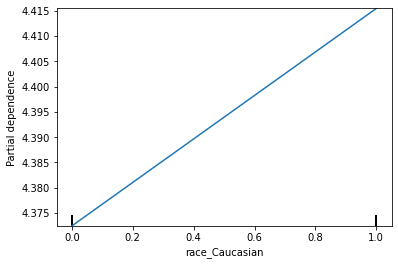

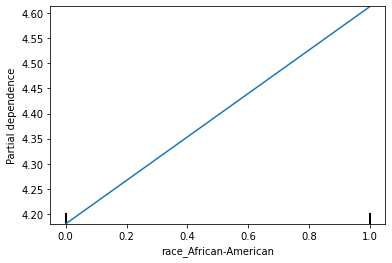

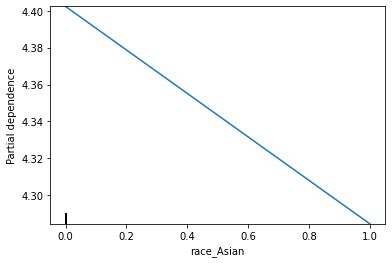

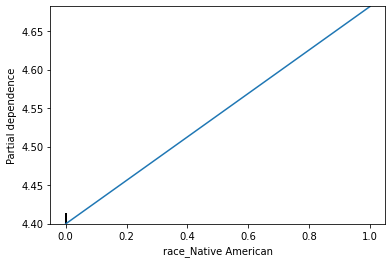

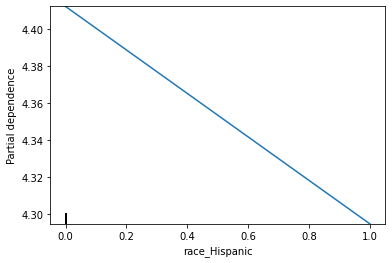

In [ ]:
# Plot PDPs (non-categorical)

features_noncat = [['age_at_cscreening'],['count_arrests'],['case_total'],['case_f'],['case_m'],['age_first_offense'],['race_Caucasian'],['race_African-American'],['race_Asian'],['race_Native American'],["race_Hispanic"]]

for i in range(len(features_noncat)):

  PartialDependenceDisplay.from_estimator(clf, X_train, features=features_noncat[i])

For the most important features there are only very few surprises, only a few spikes in extreme cases. The race PDP show a similar picture as in the random forest.

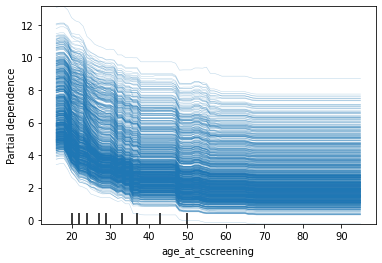

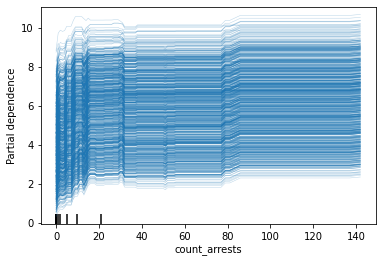

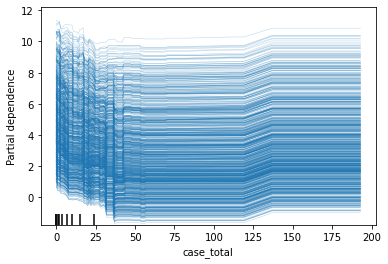

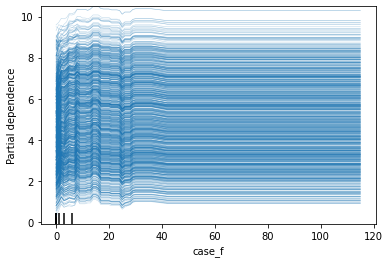

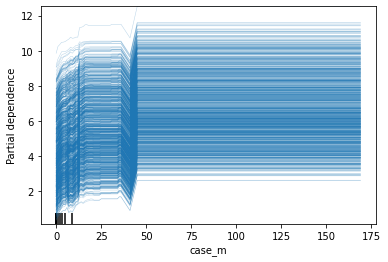

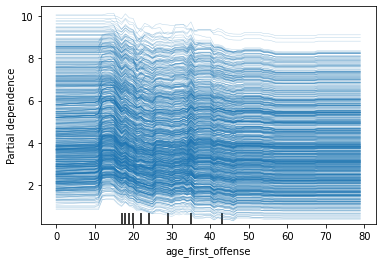

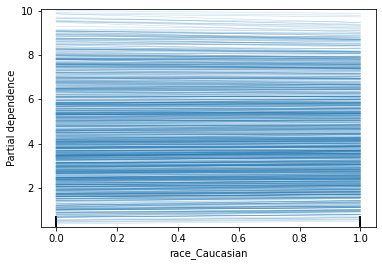

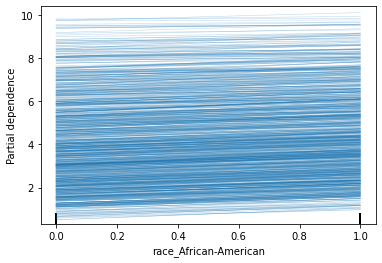

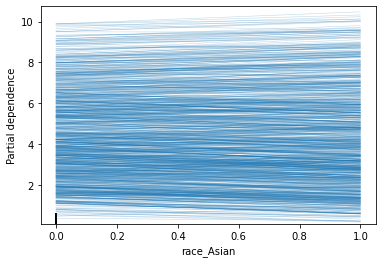

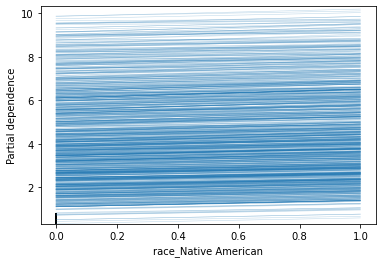

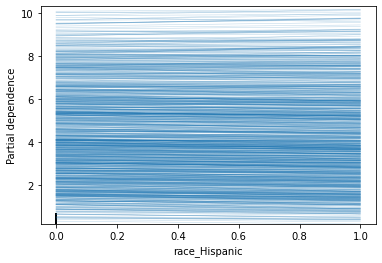

In [ ]:
# Plot ICEs (non-categorical)

for i in range(len(features_noncat)):

 PartialDependenceDisplay.from_estimator(clf, X_train, features=features_noncat[i], kind="individual")

### 6.5.4 Model Interpretation (Local)


We created a fictional character based on, in this case, Michael Myers (not all data might be as seen in the movies) and wanted to test out which score our model would give a well known serial killer.

In [ ]:
fictional_characters = fictional_characters.drop(columns=['decile_score','is_recid','is_violent_recid','two_year_recid','v_decile_score'])
fictional_case = clf.predict(fictional_characters)
print(fictional_case)
shap_values = explainer(fictional_characters)

[1.5446525 2.2022111]


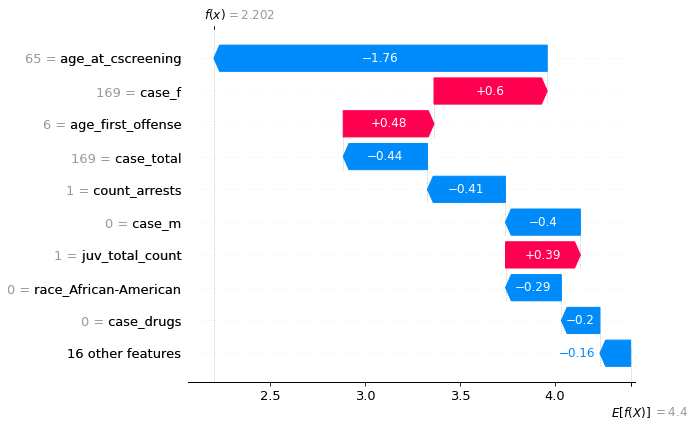

In [ ]:
shap.plots.waterfall(shap_values[1])

Surprisingly the score he gets is a 2.2. One would expect a score of 10, but our models thinks that COMPAS would give him a much lower score simply based on his current age. 

### 6.5.5 Comparison

We take a look at the predicted distribution of scores in comparison to the real compas-scores.

In [ ]:
df_comparison = get_comparison_df(clf)

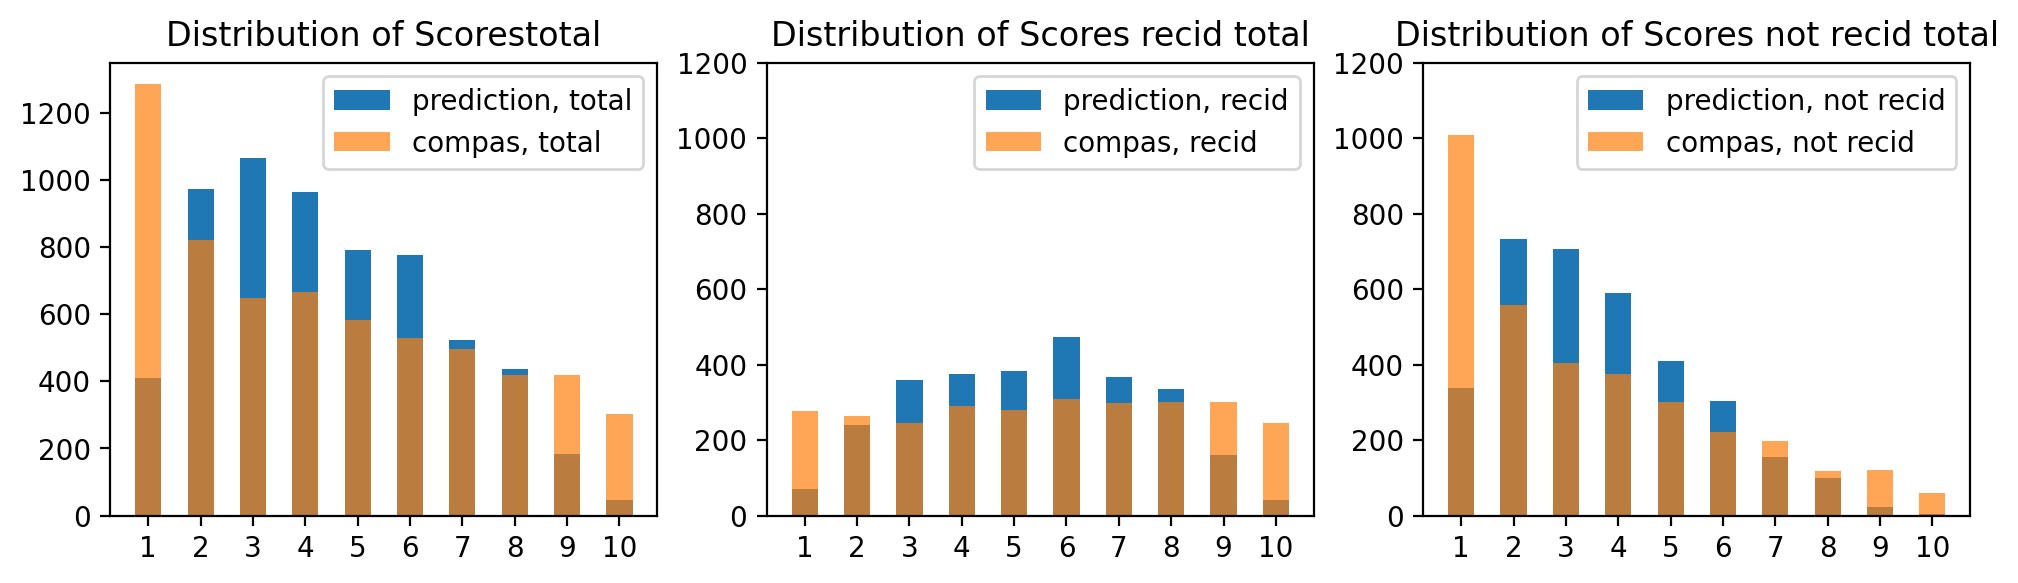

In [ ]:
plot_comparison(df_comparison,False,np.arange(0,1300,200))

As we can see in the first plot, our predictions center around 3 and 4, having far less cases on the scores 1, 9 and 10 in comparison to COMPAS.

In the second and third plot, we can see that the distribution of recidivists centers around 5 and 6, while the non-recidivists center around 3. In comparison the COMPAS-score also centers in 5-6 for recidivists but is evenly distributed along the scores. For the non-recidivists, the COMPAS-score shows a exponential decay while our predictions stay bell-shaped.

In [ ]:
# confusion matrix preparation (Score is bigger than 5 = recid)
df_comparison['compas_recid'] = 0
df_comparison['prediction_recid'] = 0

df_comparison['compas_recid'] = np.where((df_comparison.y_true > 5),1,df_comparison.compas_recid)
df_comparison['prediction_recid'] = np.where((df_comparison.y_pred_binned > 5),1,df_comparison.prediction_recid)

0.6642903434867142


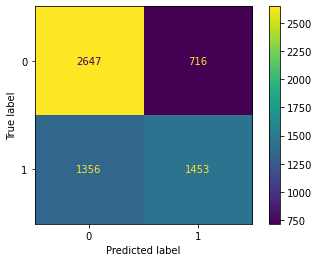

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_comparison['two_year_recid'],df_comparison['compas_recid'])).plot()
print(accuracy_score(df_comparison['two_year_recid'],df_comparison['compas_recid']))

0.6733635774465327


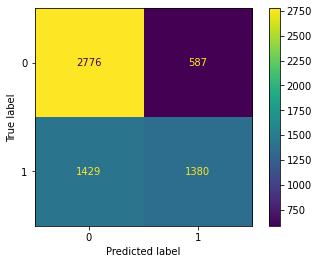

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(df_comparison['two_year_recid'],df_comparison['prediction_recid'])).plot()
print(accuracy_score(df_comparison['two_year_recid'],df_comparison['prediction_recid']))

Even though the scores are different, the accuracy stays about the same with the XGB-model having more false-negatives but less false-positives

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


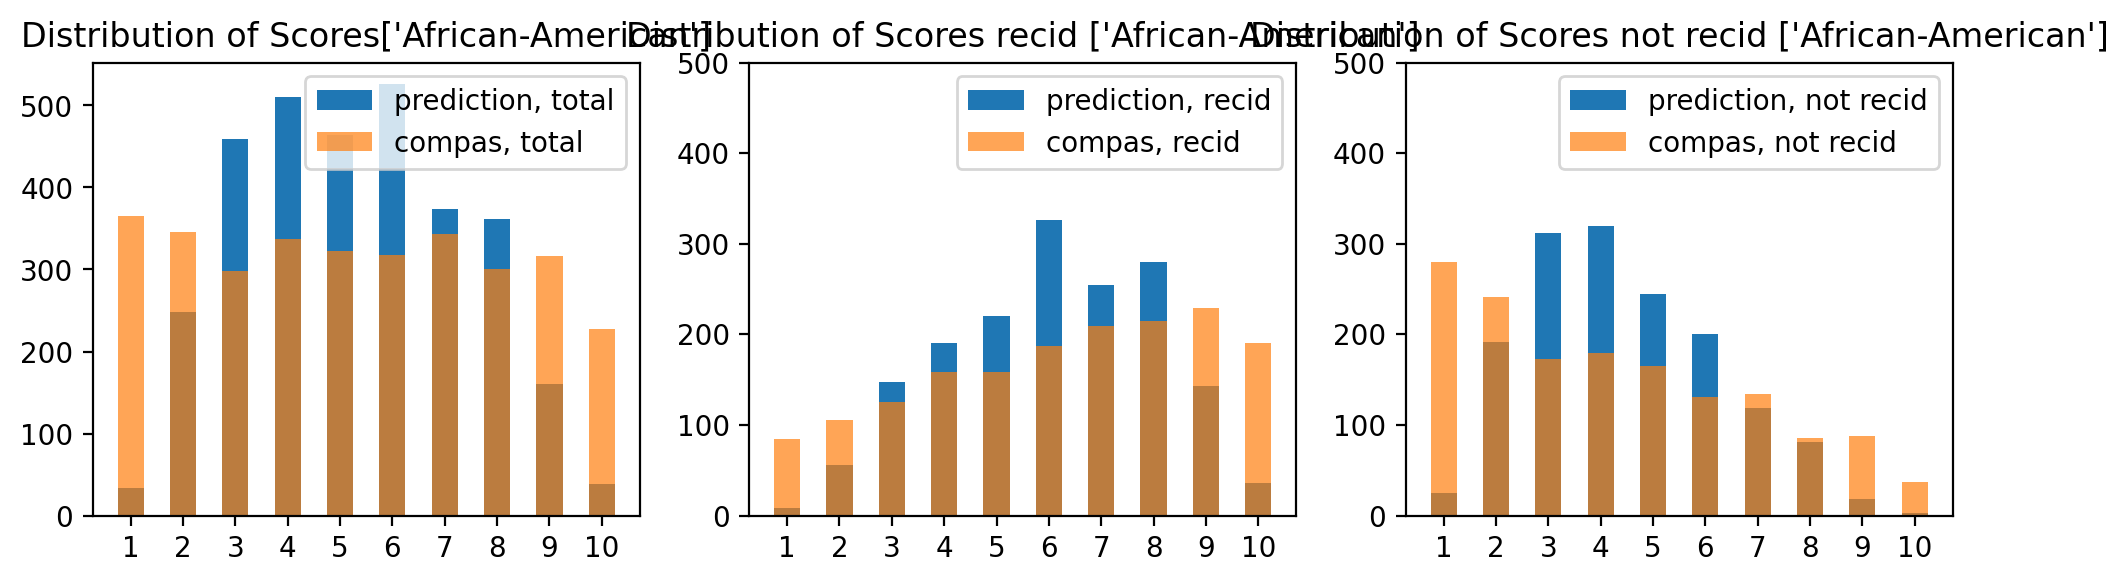

In [ ]:
plot_comparison(df_comparison,['African-American'],np.arange(0,600,100))

As expected, the overall center shifts upwards. This is unsurprising, since African Americans also scored higher on COMPAS. Interestingly, most of the score 9 predictions and nearly all of the score 10 seem to be of African American origin.

0.6513385826771654


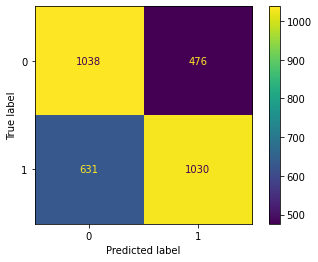

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_comparison[df_comparison['race'] == 'African-American']['two_year_recid'],df_comparison[df_comparison['race'] == 'African-American']['compas_recid'])).plot()
print(accuracy_score(df_comparison[df_comparison['race'] == 'African-American']['two_year_recid'],df_comparison[df_comparison['race'] == 'African-American']['compas_recid']))

0.6718110236220473


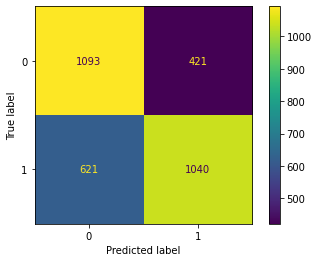

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(df_comparison[df_comparison['race'] == 'African-American']['two_year_recid'],df_comparison[df_comparison['race'] == 'African-American']['prediction_recid'])).plot()
print(accuracy_score(df_comparison[df_comparison['race'] == 'African-American']['two_year_recid'],df_comparison[df_comparison['race'] == 'African-American']['prediction_recid']))

The accuracy of both models is a little bit worse for African Americans, but XGB is outperforming on both false positives and negatives for this threshold.

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


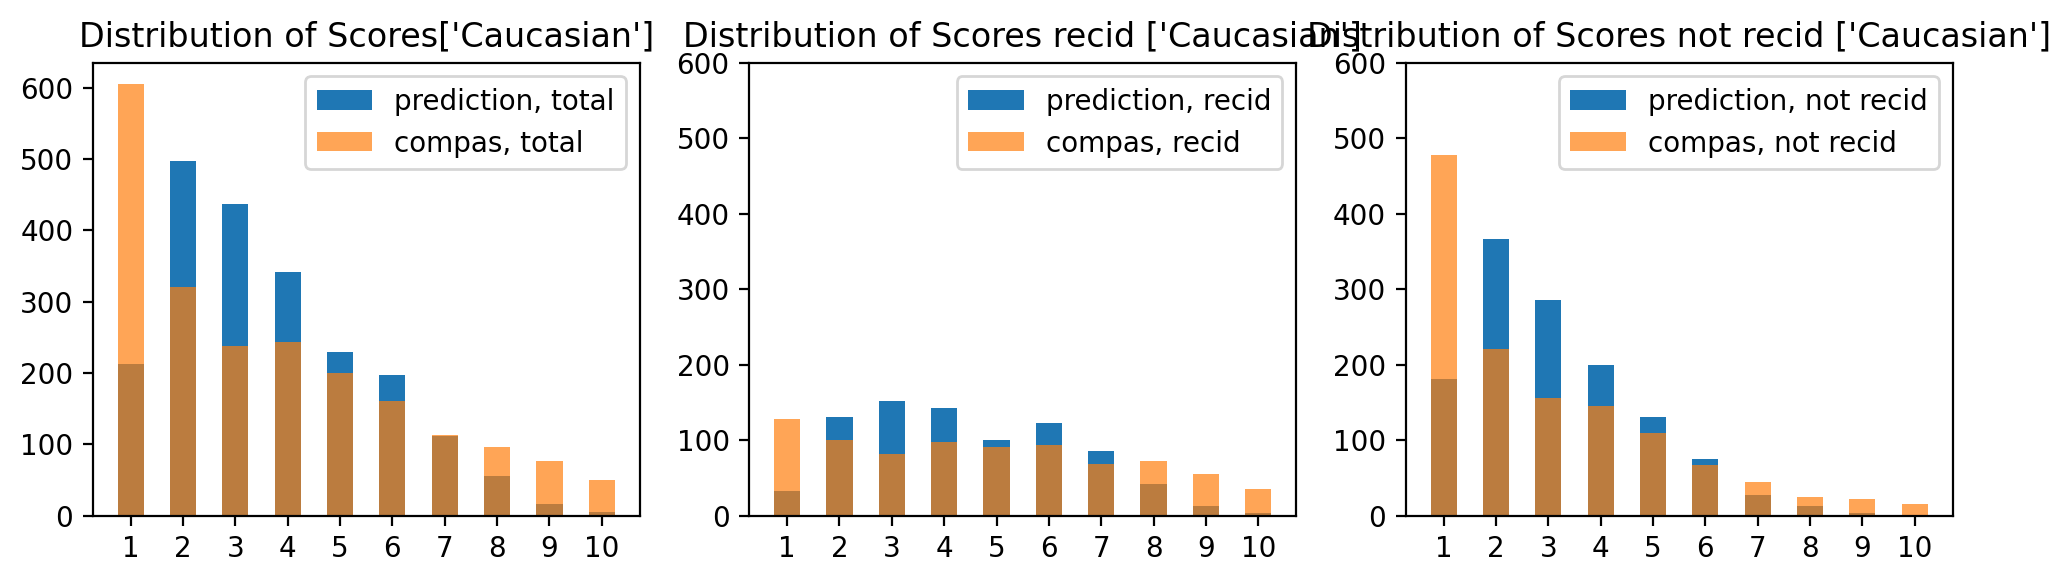

In [ ]:
plot_comparison(df_comparison,['Caucasian'],np.arange(0,700,100))

The distribution for Caucasians is very similar to the distribution of COMPAS-scores.

0.6804564907275321


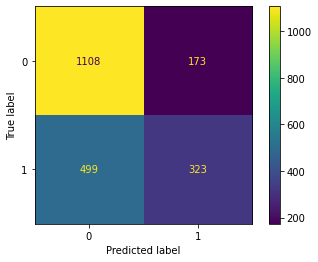

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_comparison[df_comparison['race'] == 'Caucasian']['two_year_recid'],df_comparison[df_comparison['race'] == 'Caucasian']['compas_recid'])).plot()
print(accuracy_score(df_comparison[df_comparison['race'] == 'Caucasian']['two_year_recid'],df_comparison[df_comparison['race'] == 'Caucasian']['compas_recid']))

0.6780789348549691


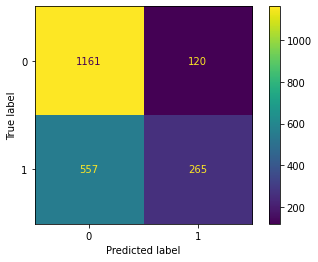

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(df_comparison[df_comparison['race'] == 'Caucasian']['two_year_recid'],df_comparison[df_comparison['race'] == 'Caucasian']['prediction_recid'])).plot()
print(accuracy_score(df_comparison[df_comparison['race'] == 'Caucasian']['two_year_recid'],df_comparison[df_comparison['race'] == 'Caucasian']['prediction_recid']))

The COMPAS-score has a bit higher accuracy-score for Caucasians then the XGB-Model. XGB again has lower false positives and higher false negatives.

# 7 Conclusion

What are our findings?
“On average, they got the right answer 63 percent of their time, and the group’s accuracy rose to 67 percent if their answers were pooled. COMPAS, by contrast, has an accuracy of 65 percent.“ - https://www.theatlantic.com/technology/archive/2018/01/equivant-compas-algorithm/550646/

Both for classification and the regressions task, the Extreme Gradient Boosting Models outperformed all other tested models. The XGB-Classifier had no problem outperforming the COMPAS-Score, even without hyperparameter tuning. After being tuned, the model was able to reach an accuracy of 69%, which then was able to outperform the group of untrained guessers. The Regressor was able to score an R2-score of 0.58 and a Mean absolute error of 1.42. This is because the model we designed had a bell-shaped distribution and did not really go into extremes.

Moreover, it shall be noted that our models seem to be biased with possible differences between the races. Based on fairness metrics, such as the average odds difference between the privileged and unprivileged groups, we are able to deduct that our models seem to provide unequal benefit for both classes.

The biggest problem for all our models is the reliance on very few features to predict the outcome. Extreme cases are evaluated differently by the machine when compared to common sense. Another problem for our models would be missing data. If a defendant with a large criminal background, that is unknown to the machine, would be evaluated, he would get a much lower score, even though his risk of recidivism might be very high. To give correct evaluations the model needs complete and correct information, the more the better.

Currently, most of the models are based on the age and past criminal activity of the defendants. To have more precise models, it would be important to get more information. Factors like the income of a defendant and other social and economic data could improve the accuracy of the models even more. But the better accuracy would come with a price. Is it worth to give up privacy just so a machine is better at predicting something?

Lastly, we believe that next steps should also include efforts to make our models not only perform better, but also to make them fairer e.g. by applying new pre- and in-processing techniques. 

# Appendix

## Appendix I: Predicting Recidivism

### Logistic Regression (no race features)

In [ ]:
df_lr = df
df_lr = df_lr.drop(columns=["v_decile_score","is_violent_recid","is_recid","decile_score"]).dropna(axis=1, how="any")
df_lr = df_lr[df_lr.columns.drop(list(df.filter(regex='race')))]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
!pip install shap
import shap
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [ ]:
# Load and split dataset
X = df_lr.drop(columns=["two_year_recid"])
y = df_lr.two_year_recid.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
# Standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Create and fit logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make prediction
y_pred = lr.predict(X_test)
print('The accuracy of logistic regression classifier on the test set is at {:.2f}'.format(lr.score(X_test, y_test)))

As the accuracy without race features is still at 69%, the deduction can be made that not using race features would not necessarily improve the model accuracy. However, it would be useful to consider them in the feature selection in case of any interactions or other blackbox relationships.

In [ ]:
# Confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
# Precision
print(classification_report(y_test, y_pred))

In [ ]:
# ROC curve
lr_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
# Cross validate AUC score
cv_scores = cross_val_score(lr, X_train, y_train, cv=5)
print('Cross-Validation Accuracy Scores:', cv_scores)
print(np.mean(cv_scores))

In [ ]:
# Log loss function
lr_probs = lr.predict_proba(X_test)
log_loss(y_test, lr_probs)

In [ ]:
# Global explanation
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=X.columns)

In [ ]:
#Local explanation
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

In [ ]:
plot_partial_dependence(lr, X_train, feature_names=X.columns, features = ['age_at_cscreening', 'case_m', 'priors_count', 'count_arrests', 'age_first_offense'])

In [ ]:
plot_partial_dependence(lr, X_train, feature_names=X.columns, features = ['age_at_cscreening', 'case_m', 'priors_count', 'count_arrests', 'age_first_offense'], kind='individual')

### KNN plot (with race features)

In [ ]:
def knn_comparison(data, k):
 X = df_knn[['age_at_cscreening', 'case_m']].values
 y = df_knn['two_year_recid'].values
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
 knn = KNeighborsClassifier(n_neighbors=k)
 knn.fit(X_train, y_train)
# Plotting decision region
 plot_decision_regions(X_train, y_train, clf=knn, legend=2)
# Adding axes annotations
 plt.xlabel('X')
 plt.ylabel('Y')
 plt.title('Knn with K='+ str(k))
 plt.ylim((0,50))
 plt.show()

for i in [1,5,20,40,80]:
    knn_comparison(df_knn, i)

As stated before, explaining the prediction with the K-nearest neighbors classifier cannot be performed with SHAP values or partial dependence plots. Therefore, we want to display the KNN plots taking into account the age at the compas screening and the count of misdemeanor charges. It becomes apparent that with k=1 or k=5 the model is very much overfitting by predicting all data points correct. However, as also the hyperparameter tuning has shown, k=40 would provide at least the most flexible fit.

### KNN (no race features)

In [ ]:
df_knn = df
df_knn = df_knn.drop(columns=["v_decile_score","is_violent_recid","is_recid","decile_score"]).dropna(axis=1, how="any")
df_knn = df_knn[df_knn.columns.drop(list(df.filter(regex='race')))]

In [ ]:
# Import libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score

In [ ]:
# Load and split dataset
X = df_knn.drop(columns=["two_year_recid"])
y = df_knn['two_year_recid'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [ ]:
# Create and fit k-NN classifier 
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

In [ ]:
# Evaluate algorithm
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# Tuning
parameters = {"n_neighbors": range(1, 100)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

In [ ]:
# Fit k-NN classifier to tuned parameter 'n_neighbors'
knn = KNeighborsClassifier(n_neighbors=45)
knn.fit(X_train, y_train)

# Make its predictions
y_pred = knn.predict(X_test)

In [ ]:
# Evaluate algorithm with new 'n_neighbors'
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# Accuracy
print("The accuracy equals to", knn.score(X_test, y_test))

As the accuracy without race features is here even at 68% being a bit lower than with race features, the deduction can be made that using race features would improve the model accuracy.

In [ ]:
# Probability estimates of the positive class
y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [ ]:
# Log loss function
knn_probs = knn.predict_proba(X_test)
log_loss(y_test, knn_probs)

## Appendix II: Predicting Compas Scores

###Linear Regression (no race features)

In [ ]:
# Import needed libraries
from sklearn.linear_model import LinearRegression

In [ ]:
# remove outliers 
Q1 = df_lin.quantile(0.005) 
Q3 = df_lin.quantile(0.995) 
IQR = Q3 - Q1

df_lin = df_lin[~((df_lin < (Q1 - 1.5 * IQR)) |(df_lin > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
#Select features for Linear Regression

variables = ['id','decile_score','two_year_recid','case_total','case_m',
                     'case_f','case_gambling','case_hard','case_drugs','time_in_prison','count_prison_stays','age_first_offense','count_arrests',
                     'age_at_cscreening','sex_Male','c_charge_degree_M']

df_reg = df_lin[variables]

In [ ]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6087 entries, 0 to 7213
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  6087 non-null   int64  
 1   decile_score        6087 non-null   int64  
 2   two_year_recid      6087 non-null   int64  
 3   case_total          6087 non-null   float64
 4   case_m              6087 non-null   float64
 5   case_f              6087 non-null   float64
 6   case_gambling       6087 non-null   float64
 7   case_hard           6087 non-null   float64
 8   case_drugs          6087 non-null   float64
 9   time_in_prison      6087 non-null   float64
 10  count_prison_stays  6087 non-null   float64
 11  age_first_offense   6087 non-null   float64
 12  count_arrests       6087 non-null   float64
 13  age_at_cscreening   6087 non-null   int64  
 14  sex_Male            6087 non-null   uint8  
 15  c_charge_degree_M   6087 non-null   uint8  
dtypes: flo

There are 19 features with 6090 non-null entries each. The model will be train on some of the strongest features to predict the target value: decile_score

In [ ]:
#plot correlation matrix
corr = df_reg.corr()
corr.style.background_gradient(cmap='coolwarm')

All-NaN slice encountered
All-NaN slice encountered


The first column shows the correlation of the 14 features compare to the target value: decile_score. Belolw are the features with:
*   positive correlations: two_year_recid,	case_total, case_m,	case_f,	case_hard,	case_drugs,	time_in_prison,	count_prison_stays, count_arrests (strongest with coefficience of 0.42), sex_Male
*  negative correlations: age_first_offense (strongest with coefficience of -0.52), age_at_cscreening,	sex_Male,	c_charge_degree_M,	race_Caucasian,	race_Hispanic,	race_Other
* no correlations: case_gambling




In [ ]:
#Select X and y to train the model
X = df_reg.drop("decile_score", axis=1)
y = df_reg["decile_score"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
X_train,X_test,y_train,y_test,train_id,test_id = id_split(X,y)

In [ ]:
# Standardization
#feature_names = X_train.columns
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#X_train = pd.DataFrame(X_train,columns=feature_names)
# Create and fit linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Make prediction
y_pred = reg.predict(X_test)
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(reg.score(X_test, y_test)))

Accuracy of linear regression classifier on test set: 0.46


In [ ]:
# Import Sequential Feature Selector
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
#Select top 10 feature which would best predict the Compas Score
sfs = SequentialFeatureSelector(reg, n_features_to_select=10)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=10)

In [ ]:
# Get a mask of the features selected.
sfs.get_support()

array([ True,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False,  True])

two_year_recid,	case_total,	case_m,	count_prison_stays,	age_first_offense,	count_arrests,	age_at_cscreening, c_charge_degree_M,	race_Caucasian, and race_Other are the most important features for Linear Regression model. They are selected by Sequential Feature Selector.	

In [ ]:
# Narrow down the dataframe into the selected features
sfs.transform(X_train)

array([[-0.90797089, -0.74996115, -0.61520203, ..., -0.53045994,
        -0.90663413,  1.33170473],
       [-0.90797089,  0.89356123, -0.02449715, ..., -0.18680951,
        -0.82106092, -0.75091721],
       [-0.90797089, -0.66345997, -0.41830041, ..., -0.44454733,
        -0.90663413, -0.75091721],
       ...,
       [-0.90797089, -0.74996115, -0.61520203, ..., -0.53045994,
        -1.07778056, -0.75091721],
       [ 1.1013569 , -0.57695879, -0.61520203, ..., -0.53045994,
        -1.16335377, -0.75091721],
       [-0.90797089, -0.74996115, -0.61520203, ..., -0.53045994,
        -0.73548771, -0.75091721]])

In [ ]:
positive = [True, False]
parameters = {
                 'positive': positive,
                 'fit_intercept':[True, False], 
                  'copy_X':[True, False],
             }

clf = GridSearchCV(reg, parameters)
clf.fit(X_train, y_train)
pipe = Pipeline(steps=[("sc", sc),("clf", clf)])

#View best params
# print("Linear Regression", clf.best_estimator_.get_params())

CV_Result = cross_val_score(pipe, X, y, n_jobs=-1, scoring = "r2")

print(CV_Result)
print(CV_Result.mean())
print(CV_Result.std())
print("r2 / variance : ", clf.best_score_)
print("Residual sum of squares: %.2f"
              % np.mean((clf.predict(X_test) - y_test) ** 2))

[0.47465783 0.48259635 0.48608899 0.44343521 0.4221755 ]
0.46179077363110677
0.02488024719684235
r2 / variance :  0.46564201238010866
Residual sum of squares: 4.31


In [ ]:
print("Train-R2-Score: ", str(reg.score(X_train,y_train)))
print("Test-R2-Score: ", str(reg.score(X_test,y_test)))

Train-R2-Score:  0.47045676604263953
Test-R2-Score:  0.4556199395450453


In [ ]:
# mean square error
mse = mean_squared_error(y_test, y_pred)
print("%.2f"% mse)

4.31


In [ ]:
# Precision
print(r2_score(y_test, y_pred))


#The max_error metric calculates the maximum residual error.
print(max_error(y_test, y_pred))

0.4556199395450453
8.070009759386302


In [ ]:
print(mean_absolute_error(y_test, y_pred))

1.690953242464655


In [ ]:
print(median_absolute_error(y_test, y_pred))

1.5016443626901683


Median absolute error output is non-negative floating point. The best value is 0.0.

In [ ]:
print(mean_absolute_percentage_error(y_test, y_pred))

0.6204940891281807


Note here that the output is not a percentage in the range [0, 100] and a value of 
100 does not mean 100% but 1e2. Furthermore, the output can be arbitrarily high when 
y_true is small (which is specific to the metric) or when abs(y_true - y_pred) is large (which is common for most regression metrics).


In [ ]:
# Cross validate score
cv_scores = cross_val_score(reg, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores:', cv_scores)
print(np.mean(cv_scores))

Cross-Validation Accuracy Scores: [0.44084429 0.47923178 0.50792981 0.46555276 0.4649622  0.5045963
 0.4291193  0.48622805 0.39430968 0.47427058]
0.4647044749097649


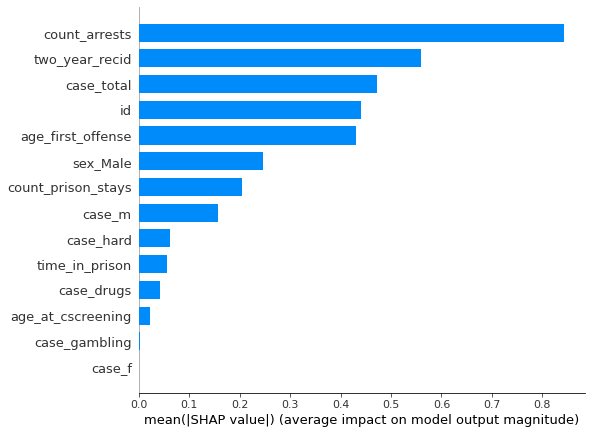

In [ ]:
# Global explanation
explainer = shap.LinearExplainer(reg, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=X.columns)

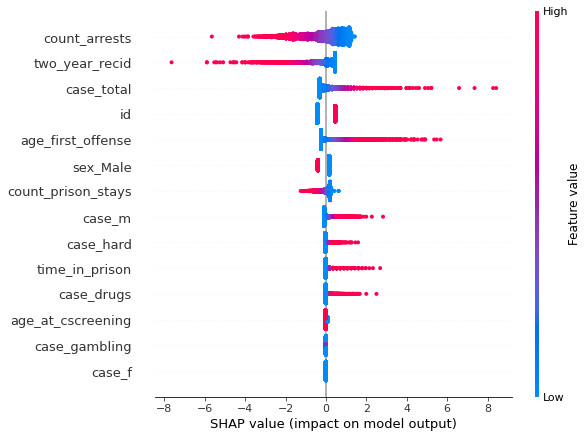

In [ ]:
#Local explanation
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

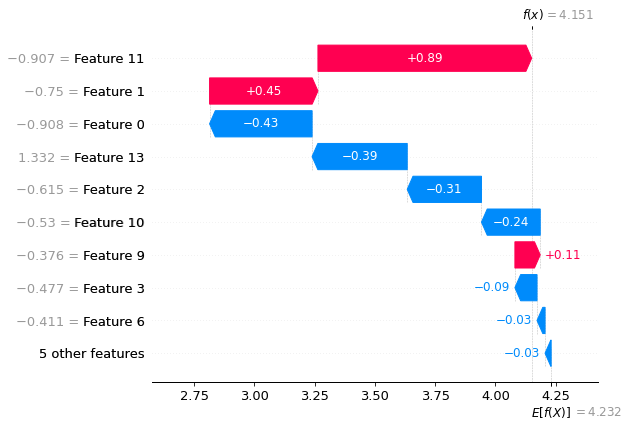

In [ ]:
# SHAP Waterfall Plot
#local1 = X_train[X_train['race_African-American']==1] 
#shap_values2 = explainer(local1.iloc[[0]])

explainer = shap.Explainer(reg, X_train)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


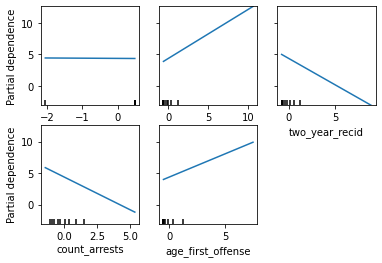

In [ ]:
# Linear Regression of each individual feature
plot_partial_dependence(reg, X_train, feature_names=X.columns, features = ['age_at_cscreening', 'case_total', 'two_year_recid', 'count_arrests', 'age_first_offense'])

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


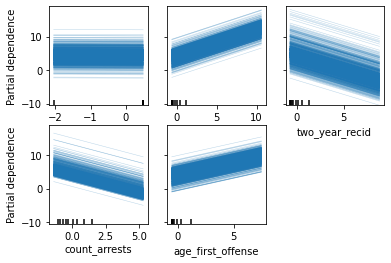

In [ ]:
plot_partial_dependence(reg, X_train, feature_names=X.columns, features = ['age_at_cscreening', 'case_total','two_year_recid', 'count_arrests', 'age_first_offense'], kind='individual')

### Elastic Net (no race features)

In [ ]:
# Import libraries
from sklearn.linear_model import ElasticNet

In [ ]:
df_en_nr = df_lin
df_en_nr = df_en_nr.drop(columns=["id", "two_year_recid", "race_Caucasian", "race_Hispanic", 
                                  "race_Native American", "race_Other"]).dropna(axis=1, how="any")

In [ ]:
#drop outliers
df_en_nr.drop(df_en_nr[df_en_nr.case_m == 169].index, inplace=True)
df_en_nr.drop(df_en_nr[df_en_nr.age_at_cscreening == 95].index, inplace=True)
df_en_nr.drop(df_en_nr[df_en_nr.juv_total_count == 20].index, inplace=True)

In [ ]:
# X is initalized with the features (independent variables), y with the labels (dependent variables)
X = df_en_nr.drop("decile_score", axis=1)
y = df_en_nr["decile_score"]


# Splitting the Date Frame into train / test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [ ]:
steps = [("scaler", StandardScaler()),
         ("elasticnet", ElasticNet())]

pipeline = Pipeline(steps)

#parameters for Elasticnet
parameters = {"elasticnet__l1_ratio": np.arange(0.1,1.0,0.1),
              "elasticnet__max_iter": [100000],
              "elasticnet__selection": ["cyclic", "random"],
              "elasticnet__alpha": np.arange(1e-4,1e-3,1e-4)}

clf = GridSearchCV(pipeline, parameters)
clf.fit(X_train, y_train)

#View best params
print("Elasticnet best parameters: ", clf.best_estimator_.get_params()["elasticnet"])

Elasticnet best parameters:  ElasticNet(alpha=0.0009000000000000001, l1_ratio=0.9, max_iter=100000)


In [ ]:
model_en = ElasticNet(alpha=0.0009, l1_ratio=0.9, selection='random', max_iter=100000, random_state=42)
model_en.fit(X_train, y_train)

CV_Result = cross_val_score(model, X, y, cv=10, scoring = "r2")

In [ ]:
y_pred = model_en.predict(X_test)
print("Train-R2-Score: ", str(model_en.score(X_train,y_train)))
print("Test-R2-Score: ", str(model_en.score(X_test,y_test)))
print("Mean squared error:",str(mean_squared_error(y_test,y_pred)))
print("Mean absolute percentage error:",str(mean_absolute_percentage_error(y_test,y_pred)))
print("Mean absolute error:",str(mean_absolute_error(y_test,y_pred)))
print("Median absolute error:",str(median_absolute_error(y_test,y_pred)))

Train-R2-Score:  0.4685293628582158
Test-R2-Score:  0.43566254683803385
Mean squared error: 4.533797357840995
Mean absolute percentage error: 0.6227317249081754
Mean absolute error: 1.7149291280033285
Median absolute error: 1.5252525975192759


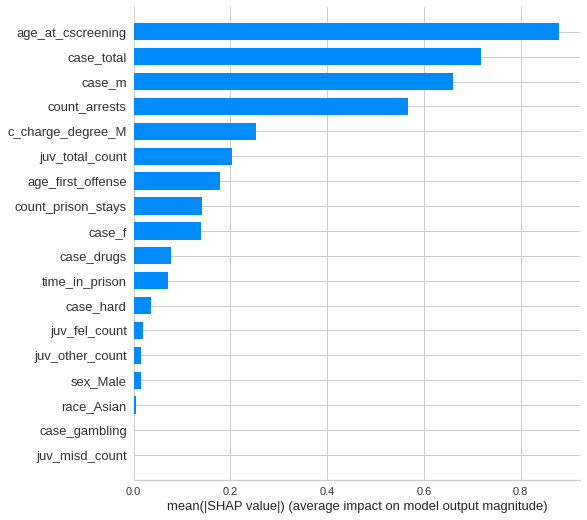

In [ ]:
# Global explanation
explainer = shap.LinearExplainer(model_en, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=X.columns)

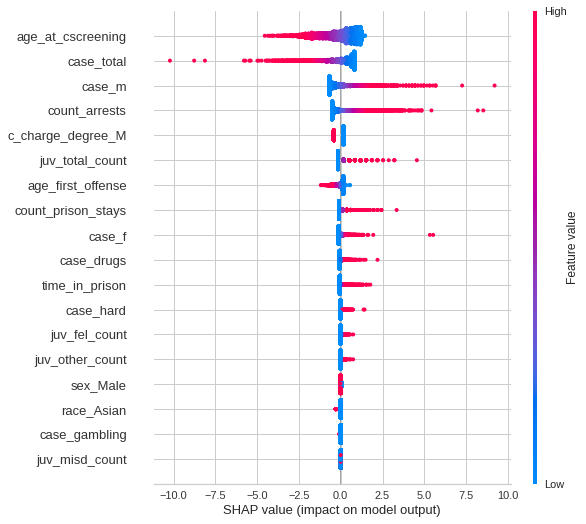

In [ ]:
#Local explanation
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead



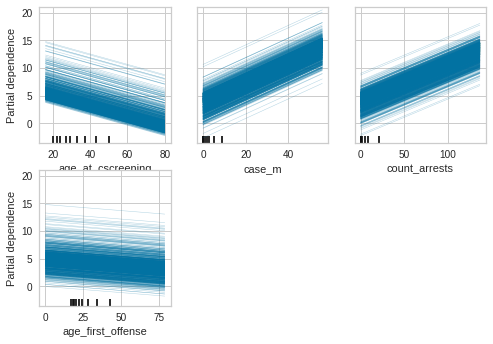

In [ ]:
plot_partial_dependence(model_en, X_train, feature_names=X.columns, features = ['age_at_cscreening', 'case_m', 'count_arrests', 'age_first_offense'], kind='individual')

### KNN Regressor (no race features)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
df_knnreg_nr = df_lin
df_knnreg_nr = df_knnreg_nr.drop(columns=["id", "two_year_recid", "race_Caucasian", "race_Hispanic", 
                                  "race_Native American", "race_Other"]).dropna(axis=1, how="any")

In [ ]:
#drop outliers
df_knnreg_nr.drop(df_knnreg_nr[df_knnreg_nr.case_m == 169].index, inplace=True)
df_knnreg_nr.drop(df_knnreg_nr[df_knnreg_nr.age_at_cscreening == 95].index, inplace=True)
df_knnreg_nr.drop(df_knnreg_nr[df_knnreg_nr.juv_total_count == 20].index, inplace=True)

In [ ]:
# X is initalized with the features (independent variables), y with the labels (dependent variables)
X = df_knnreg_nr.drop("decile_score", axis=1)
y = df_knnreg_nr["decile_score"]


# Splitting the Date Frame into train / test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [ ]:
#Building a pipeline and conduction GridSearchCV to get the best parameters for the model

steps = [("scaler", StandardScaler()),
         ("neigh", KNeighborsRegressor())]

pipeline = Pipeline(steps)

#parameters for KNN
parameters = {"neigh__n_neighbors": range(1, 100),
              "neigh__weights": ["uniform", "distance"],
              "neigh__metric" : ["manhattan", "euclidean"]}

neigh_clf = GridSearchCV(pipeline, parameters)
neigh_clf.fit(X_train, y_train)

#View best params
print("KNeighborsRegressor", neigh_clf.best_params_)

KNeighborsRegressor {'neigh__metric': 'manhattan', 'neigh__n_neighbors': 25, 'neigh__weights': 'uniform'}


In [ ]:
#Enter the best parameters into the KNeighborsRegressor 
model_neigh_clf = KNeighborsRegressor(metric= "manhattan", n_neighbors= 25, weights= "uniform")
model_neigh_clf.fit(X_train, y_train)

#conduct cross validation
pred_neigh = cross_val_score(model_neigh_clf, X, y, cv=10)
print(np.mean(pred_neigh))

0.5307478151815732


In [ ]:
y_pred = model_neigh_clf.predict(X_test)
print("Train-R2-Score: ", str(model_neigh_clf.score(X_train,y_train)))
print("Test-R2-Score: ", str(model_neigh_clf.score(X_test,y_test)))
print("Mean squared error:",str(mean_squared_error(y_test,y_pred)))
print("Mean absolute percentage error:",str(mean_absolute_percentage_error(y_test,y_pred)))
print("Mean absolute error:",str(mean_absolute_error(y_test,y_pred)))
print("Median absolute error:",str(median_absolute_error(y_test,y_pred)))

Train-R2-Score:  0.5666804080878081
Test-R2-Score:  0.5193036368169013
Mean squared error: 3.8618381415451104
Mean absolute percentage error: 0.5118579832437207
Mean absolute error: 1.5260507833603458
Median absolute error: 1.2400000000000002


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead



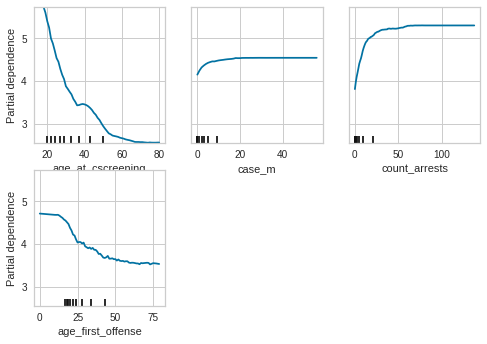

In [ ]:
plot_partial_dependence(model_neigh_clf, X_train, feature_names=X.columns, features = ['age_at_cscreening', 'case_m', 'count_arrests', 'age_first_offense'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead



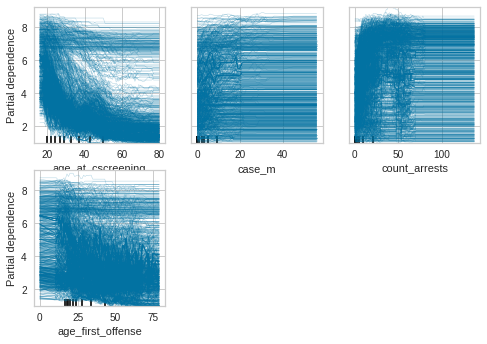

In [ ]:
plot_partial_dependence(model_neigh_clf, X_train, feature_names=X.columns, features = ['age_at_cscreening', 'case_m', 'count_arrests', 'age_first_offense'], kind='individual')

### XGB Regressor (no race features)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_validate

In [ ]:
df_compas_forest = df
df_compas_forest = df_compas_forest.drop(columns=["v_decile_score","two_year_recid","is_violent_recid","is_recid"]).dropna(axis=1, how="any")
df_compas_forest = df_compas_forest[df_compas_forest.columns.drop(list(df.filter(regex='race')))]

In [ ]:
# Train Test Split
y=df_compas_forest['decile_score']
X=df_compas_forest.drop('decile_score',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
# Define variables
count_trees = np.arange(1,51,1)
max_depth = np.arange(1,21,1)
cv=5
param_grid = {
                'max_depth': [3,6,10],
                'learning_rate': [0.05],
                'n_estimators': [100, 500, 1000],
                'colsample_bytree': [0.3],
                'objective': ['reg:squarederror']
             }

In [ ]:
xgb_reg = xgb.XGBRegressor()
clf = GridSearchCV(xgb_reg,param_grid,cv=cv)
clf.fit(X_train,y_train)

13 minutes

In [ ]:
# best xgb
clf.best_estimator_

In [ ]:
print("Train-Score: ", str(clf.score(X_train,y_train)))
print("Test-Score: ", str(clf.score(X_test,y_test)))

In [ ]:
feature_imp = pd.Series(clf.best_estimator_.feature_importances_,index = X.columns).sort_values(ascending=False)
feature_imp

In [ ]:
sns.barplot(x = feature_imp, y = feature_imp.index)

In [ ]:
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [ ]:
#Local explanation
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

### Random Forest (no race features)

Selecting columns to use

In [ ]:
df_compas_forest = df
df_compas_forest = df_compas_forest.drop(columns=["v_decile_score","two_year_recid","is_violent_recid","is_recid"]).dropna(axis=1, how="any")
df_compas_forest = df_compas_forest[df_compas_forest.columns.drop(list(df.filter(regex='race')))]

In [ ]:
# import Forest Regressor and stuff
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_validate

In [ ]:
# Train Test Split
y=df_compas_forest['decile_score']
X=df_compas_forest.drop('decile_score',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
# Define variables for GridSearchCV
count_trees = np.arange(1,51,1)
max_depth = np.arange(1,21,1)
min_samples_leaf = [5,10,15,20]
cv=5
param_grid = {
                 'n_estimators': 48,
                 'max_depth': 11,
                 'max_features': ['auto'],
                 'min_samples_leaf':5,
                 'bootstrap':[True]
             }
#param_grid = {
#                 'n_estimators': count_trees,
#                 'max_depth': max_depth,
#                 'max_features': ['auto', 'sqrt', 'log2'],
#                 'min_samples_leaf':min_samples_leaf,
#                 'bootstrap':[True,False]
#             }

In [ ]:
# Fit model
forest=RandomForestRegressor()
clf = GridSearchCV(forest,param_grid,cv=cv)
clf.fit(X_train,y_train)

In [ ]:
# best forest
clf.best_estimator_

In [ ]:
print("Train-Score: ", str(clf.score(X_train,y_train)))
print("Test-Score: ", str(clf.score(X_test,y_test)))

In [ ]:
feature_imp = pd.Series(clf.best_estimator_.feature_importances_,index = X.columns).sort_values(ascending=False)
feature_imp

In [ ]:
sns.barplot(x = feature_imp, y = feature_imp.index)

In [ ]:
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [ ]:
#Local explanation
shap.summary_plot(shap_values, X_train, feature_names=X.columns)